# Advanced Lane Finding

## Imports

In [175]:
import cv2
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
from os.path import splitext, basename, join

# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

%matplotlib inline

## Helpers

In [176]:
def to_rgb(img):
    return cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

def to_bgr(img):
    return cv2.cvtColor(img, cv2.COLOR_RGB2BGR)

def to_hls(img):
    return cv2.cvtColor(img, cv2.COLOR_RGB2HLS)

def read_image(path):
    return to_rgb(cv2.imread(path))

def plot_images(images, labels):
    rows = len(images)
    cols = len(images[0])
    cmap = None

    f, axes = plt.subplots(rows, cols, figsize=(12,20))
    
    for i, row in enumerate(images):
        for j, image in enumerate(row):
            label = labels[i][j]
            
            ax = axes[i, j] if rows > 1 else axes[j]
            
            if len(image.shape) < 3 or img.shape[-1] < 3:
                cmap = "gray"

            ax.imshow(image, cmap=cmap)
            ax.set_title(label, fontsize=20)

    plt.tight_layout()
    plt.show()
    
    return

def map_to_list(fn, args):
    return list(map(fn, args))

def zip_to_list(l1, l2):
    return list(zip(l1, l2))

## Camera calibration

In [177]:
def calibrate(img_pattern):
    # Arrays to store object points and image points from all the images
    obj_points = []
    img_points = []

    # Prepare object points
    objp = np.zeros((9*6, 3), np.float32)
    objp[:,:2] = np.mgrid[0:9, 0:6].T.reshape(-1, 2)

    calibration_images = glob.glob(img_pattern)

    for index, img_path in enumerate(calibration_images):
        img = cv2.imread(img_path)
        gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

        ret, corners = cv2.findChessboardCorners(gray_img, (9, 6), None)

        if ret == True:
            img_points.append(corners)
            obj_points.append(objp)
            
    # We know that the calibration and car images have the same size
    img_size = (1280, 720)
    
    # Do camera calibration given object points and image points
    # return obj_points, img_points
    return cv2.calibrateCamera(obj_points, img_points, img_size, None, None)


### Testing undistortion on chessboard

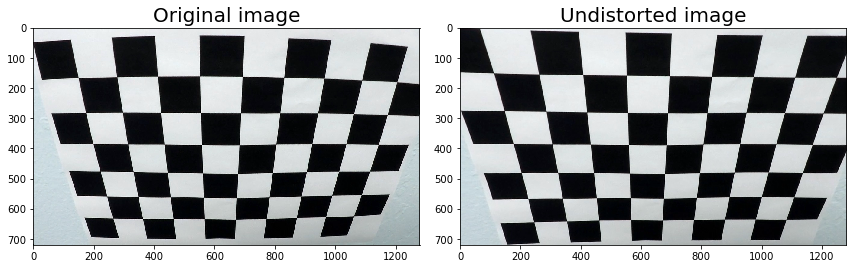

In [178]:
# calibrate the camera 
ret, mtx, dist, rvecs, tvecs = calibrate('camera_cal/calibration*.jpg')

def undistort(img, mtx, dist):
    return cv2.undistort(img, mtx, dist, None, mtx)

img = cv2.imread('camera_cal/calibration2.jpg')
undist = undistort(img, mtx, dist)

#cv2.imwrite('examples/undistorted.jpg', dst)

plot_images([[img, undist]], [['Original image', 'Undistorted image']])

### Undistorting test images

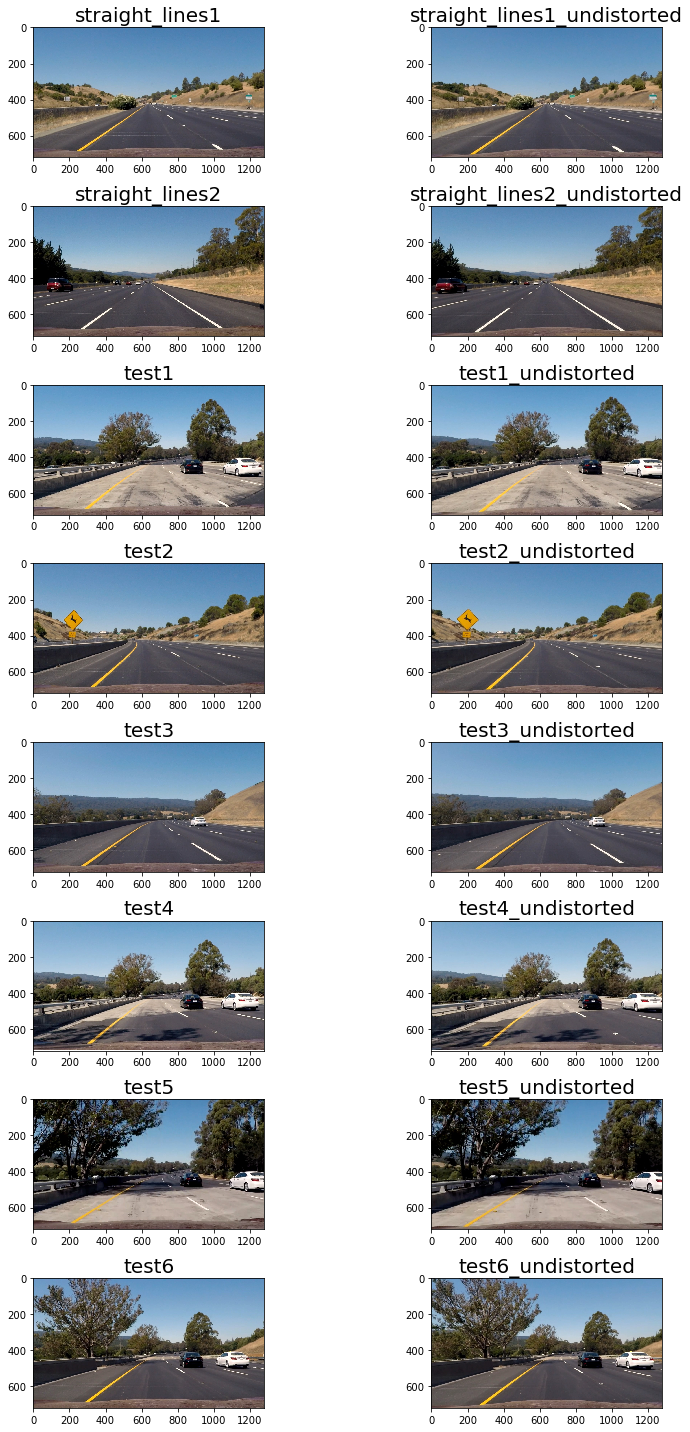

In [179]:
#img = cv2.imread('test_images/test1.jpg')
#dst = cv2.undistort(img, mtx, dist, None, mtx)

test_images_pattern = 'test_images/*.jpg'
test_images_paths = glob.glob(test_images_pattern)

test_images_labels = map_to_list(lambda path: splitext(basename(path))[0], test_images_paths)
undist_test_images_labels = map_to_list(lambda label: label + '_undistorted', test_images_labels)

test_images = map_to_list(lambda path: read_image(path), test_images_paths)
undist_test_images = map_to_list(lambda test_image: undistort(test_image, mtx, dist), test_images)

zipped_test_images = zip_to_list(test_images, undist_test_images)
zipped_test_labels = zip_to_list(test_images_labels, undist_test_images_labels)

plot_images(zipped_test_images, zipped_test_labels)

#cv2.imwrite('examples/test_image_undistorted.jpg', to_bgr(undist_test_images[0]))

# Thresholding

## Color thresholding

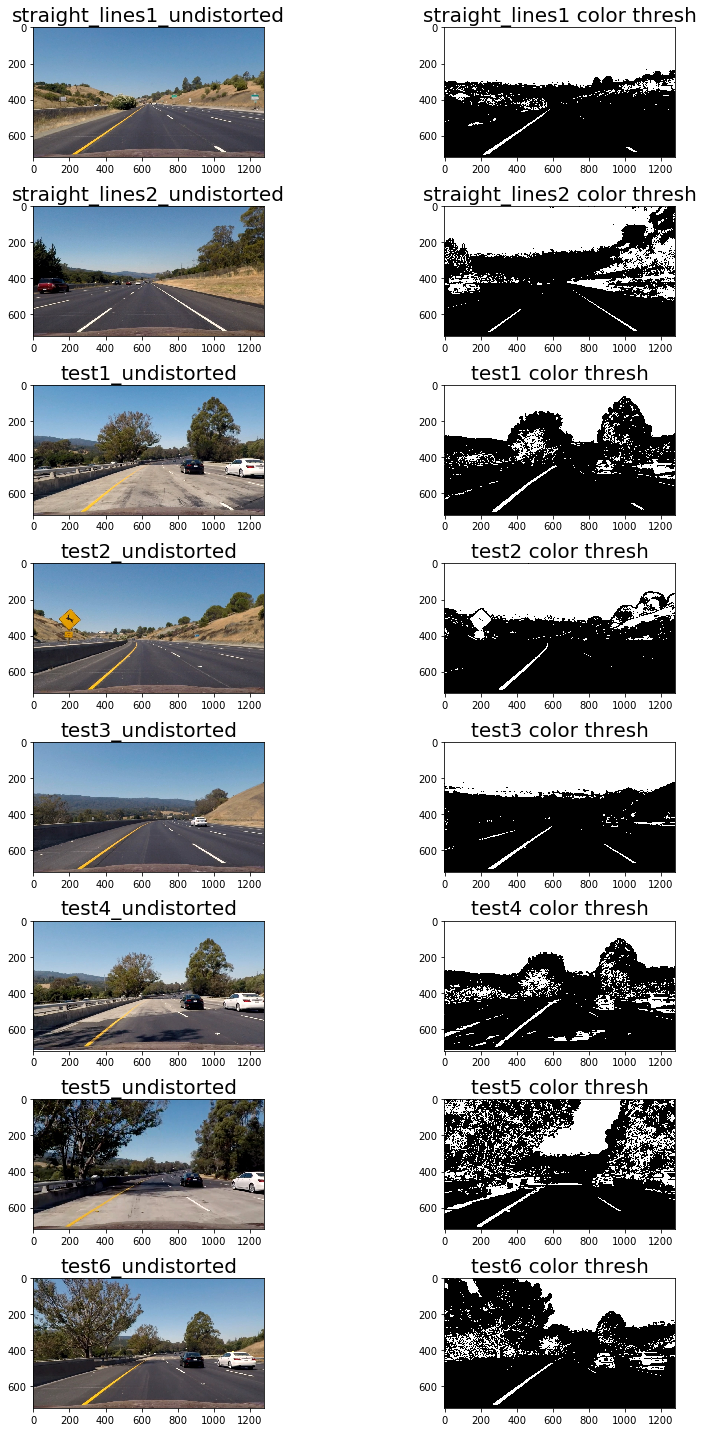

In [180]:
def color_thresholding(img):
    hls = to_hls(img)
    
    H = hls[:,:,0]
    L = hls[:,:,1]
    S = hls[:,:,2]
    
    thresh = (90, 255)
    
    binary = np.zeros_like(S)
    binary[(S > thresh[0]) & (S <= thresh[1])] = 1
    
    return binary

color_undist_test_images = map_to_list(lambda img: color_thresholding(img), undist_test_images)
color_undist_test_images_labels = map_to_list(lambda label: label + ' color thresh', test_images_labels)

zipped_color_undist_test_images = zip_to_list(undist_test_images, color_undist_test_images)
zipped_color_undist_test_labels = zip_to_list(undist_test_images_labels, color_undist_test_images_labels)

plot_images(zipped_color_undist_test_images, zipped_color_undist_test_labels)

## Gradient thresholding

In [181]:
def abs_sobel_thresh(gray_img, orient='x', sobel_kernel=3, thresh=(0, 255)):
    if orient == 'x':
        sobel = cv2.Sobel(gray_img, cv2.CV_64F, 1, 0)
    else:
        sobel = cv2.Sobel(gray_img, cv2.CV_64F, 0, 1)

    abs_sobel = np.absolute(sobel)
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    
    grad_binary = np.zeros_like(scaled_sobel)
    grad_binary[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1
    
    return grad_binary

def mag_thresh(gray_img, sobel_kernel=3, mag_thresh=(0, 255)):
    sobelx = cv2.Sobel(gray_img, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray_img, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    
    mag_sobel = np.sqrt(sobelx**2 + sobely**2)
    scaled_sobel = np.uint8(255*mag_sobel/np.max(mag_sobel))
    
    mag_binary = np.zeros_like(scaled_sobel)
    mag_binary[(scaled_sobel >= mag_thresh[0]) & (scaled_sobel <=  mag_thresh[1])] = 1
    
    return mag_binary

def dir_threshold(gray_img, sobel_kernel=3, thresh=(0, np.pi/2)):
    sobelx = cv2.Sobel(gray_img, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray_img, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    
    abs_sobelx = np.absolute(sobelx)
    abs_sobely = np.absolute(sobely)
    dir_sobel = np.arctan2(abs_sobely, abs_sobelx)
    
    dir_binary = np.zeros_like(dir_sobel)
    dir_binary[(dir_sobel >= thresh[0]) & (dir_sobel <=  thresh[1])] = 1
    
    return dir_binary

In [182]:
def gradient_thresholding(img):
    gray_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

    # Choose a Sobel kernel size
    ksize = 15 # Choose a larger odd number to smooth gradient measurements

    # Apply each of the thresholding functions
    gradx = abs_sobel_thresh(gray_img, orient='x', sobel_kernel=ksize, thresh=(80, 240))
    grady = abs_sobel_thresh(gray_img, orient='y', sobel_kernel=ksize, thresh=(80, 240))
    mag_binary = mag_thresh(gray_img, sobel_kernel=ksize, mag_thresh=(100, 180))
    dir_binary = dir_threshold(gray_img, sobel_kernel=ksize, thresh=(0.7, 1.3))

    combined = np.zeros_like(dir_binary)
    combined[((gradx == 1) & (grady == 1)) | ((mag_binary == 1) & (dir_binary == 1))] = 1
    
    return combined

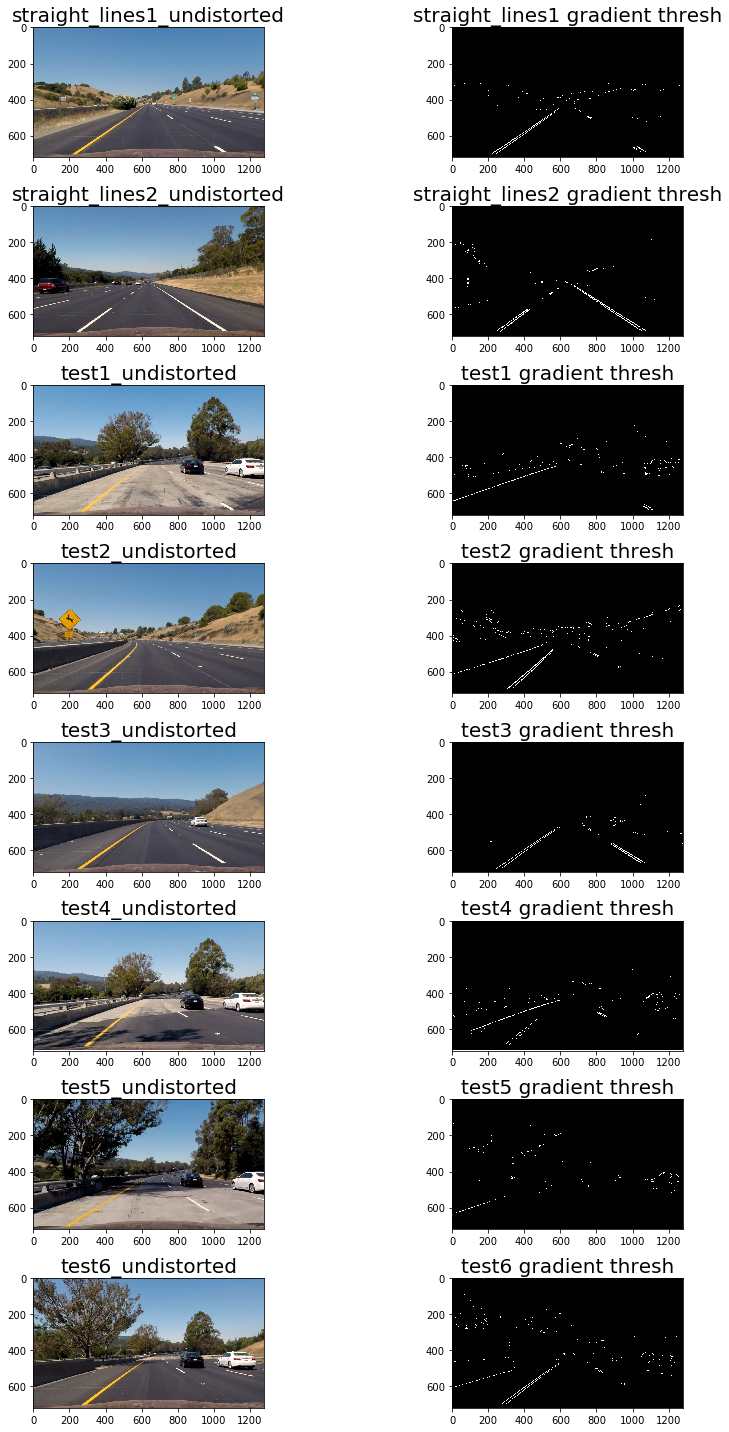

In [183]:
gradient_undist_test_images = map_to_list(lambda img: gradient_thresholding(img), undist_test_images)
gradient_undist_test_images_labels = map_to_list(lambda label: label + ' gradient thresh', test_images_labels)

zipped_gradient_undist_test_images = zip_to_list(undist_test_images, gradient_undist_test_images)
zipped_gradient_undist_test_labels = zip_to_list(undist_test_images_labels, gradient_undist_test_images_labels)

plot_images(zipped_gradient_undist_test_images, zipped_gradient_undist_test_labels)

## Combined color and gradient thresholding

In [184]:
def combined_thresholding(img):
    color_binary = color_thresholding(img)
    gradient_binary = gradient_thresholding(img)
    
    combined_binary = np.zeros_like(color_binary)
    combined_binary[(gradient_binary == 1) | (color_binary == 1)] = 1
        
    return combined_binary

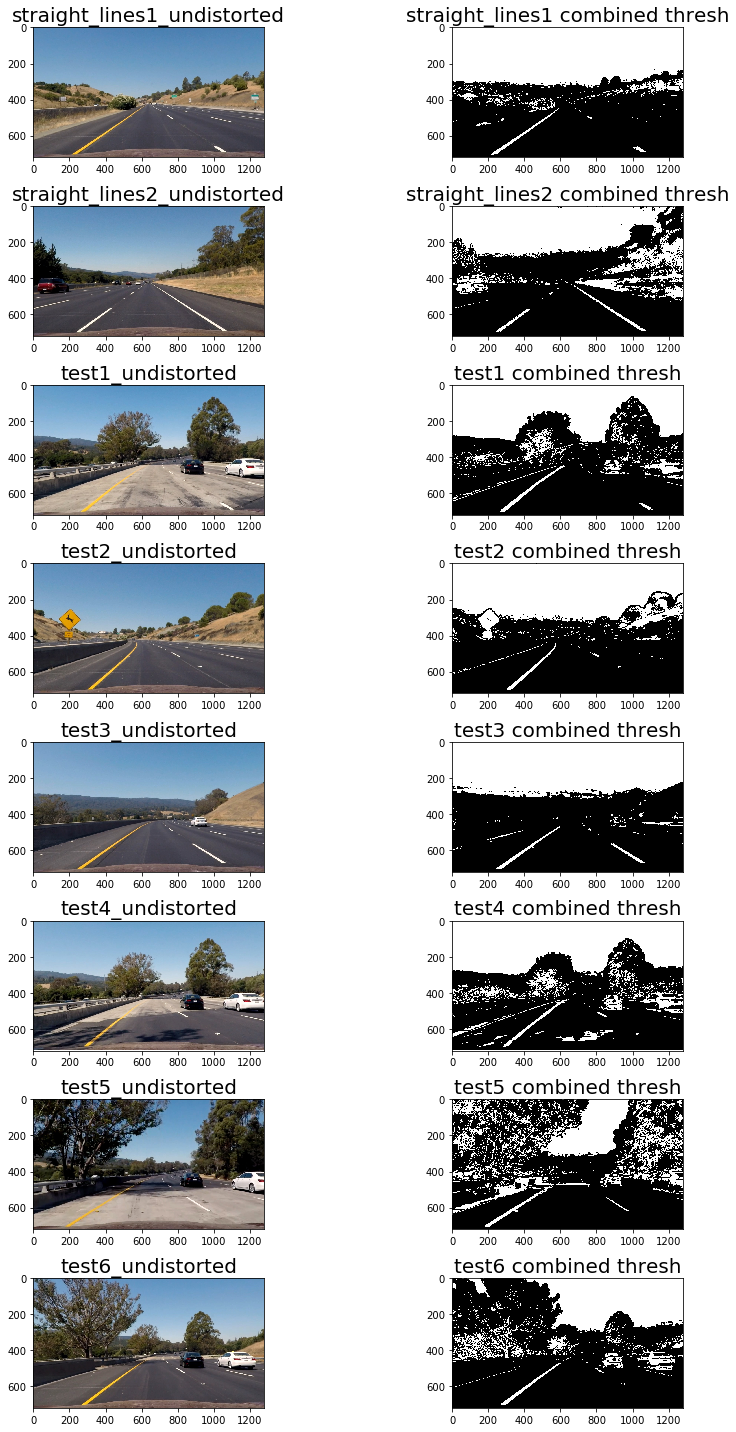

True

In [185]:
combined_undist_test_images = map_to_list(lambda img: combined_thresholding(img), undist_test_images)
combined_undist_test_images_labels = map_to_list(lambda label: label + ' combined thresh', test_images_labels)

zipped_combined_undist_test_images = zip_to_list(undist_test_images, combined_undist_test_images)
zipped_combined_undist_test_labels = zip_to_list(undist_test_images_labels, combined_undist_test_images_labels)

plot_images(zipped_combined_undist_test_images, zipped_combined_undist_test_labels)

cv2.imwrite('examples/test_image_combined.jpg', combined_undist_test_images[1])

# Perspective transform

In [186]:
def warp(img, src, dst):
    img_size = (img.shape[1], img.shape[0])
    M = cv2.getPerspectiveTransform(src, dst)
    return cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_NEAREST)

## Visualisation

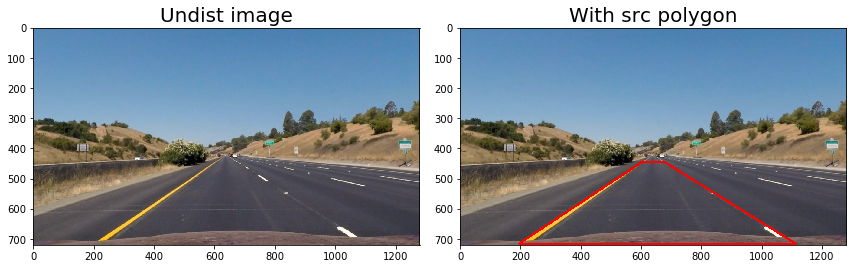

In [187]:
not_warped_test_img = np.copy(undist_test_images[0])
bottom_y = not_warped_test_img.shape[0] - 5

#src = np.array([[200, bottom_y], [600, 450], [680, 450], [1095, bottom_y]], np.float32)
src = np.array([[195, bottom_y], [602, 445], [675, 445], [1110, bottom_y]], np.float32)
#dst = np.array([[200, bottom_y], [200, 0], [1000, 0], [1000, bottom_y]], np.float32)
dst = np.array([[320, bottom_y], [320, 0], [960, 0], [960, bottom_y]], np.float32)

# draw src_points polygon on warp_test_img
src_polygon = src.astype(np.int32)
cv2.polylines(not_warped_test_img, [src_polygon], True, (255,0,0), 5)

plot_images([[undist_test_images[0], not_warped_test_img]], [['Undist image', 'With src polygon']])

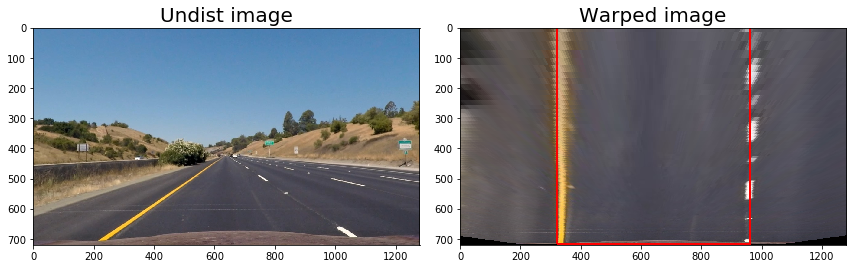

In [188]:
warped_test_img = warp(undist_test_images[0], src, dst)

# draw dst polygon on warp_test_img
dst_polygon = dst.astype(np.int32)
cv2.polylines(warped_test_img, [dst_polygon], True, (255,0,0), 5)

plot_images([[undist_test_images[0], warped_test_img]], [['Undist image', 'Warped image']])

#cv2.imwrite('examples/test_image_warped.jpg', to_bgr(warped_test_img))

## Applying on test images

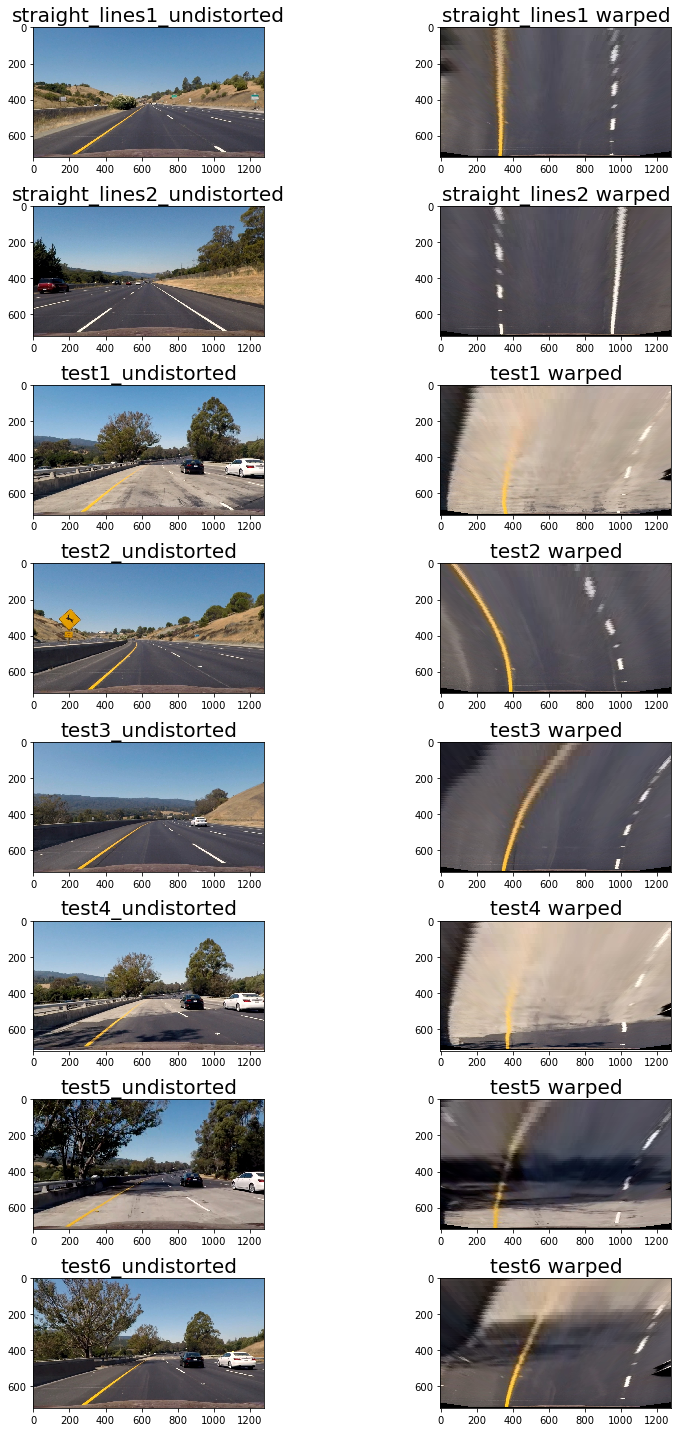

In [189]:
warped_undist_test_images = map_to_list(lambda img: warp(img, src, dst), undist_test_images)
warped_undist_test_images_labels = map_to_list(lambda label: label + ' warped', test_images_labels)

zipped_warped_undist_test_images = zip_to_list(undist_test_images, warped_undist_test_images)
zipped_warped_undist_test_labels = zip_to_list(undist_test_images_labels, warped_undist_test_images_labels)

plot_images(zipped_warped_undist_test_images, zipped_warped_undist_test_labels)

# Thresholding + warp

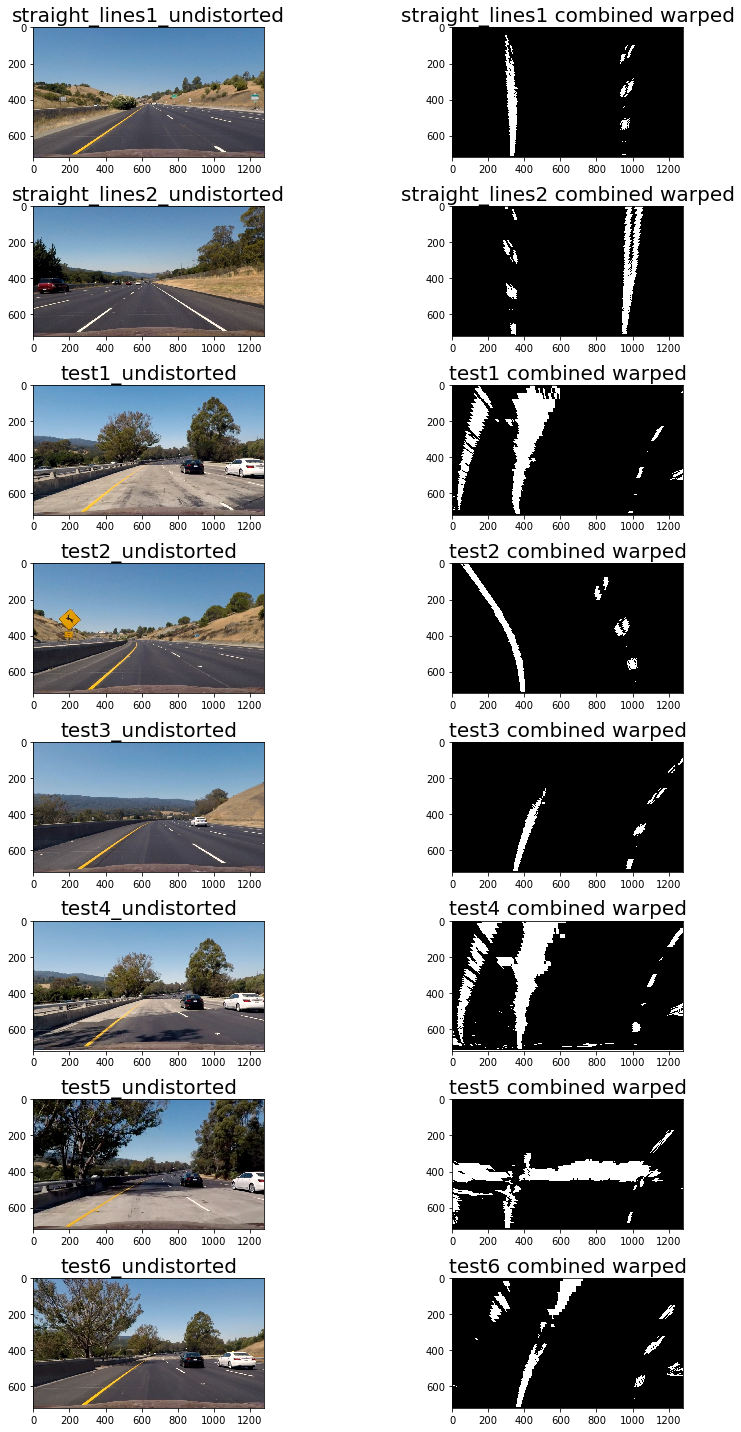

In [190]:
warped_combined_undist_test_images = map_to_list(lambda img: warp(img, src, dst), combined_undist_test_images)
warped_combined_undist_test_images_labels = map_to_list(lambda label: label + ' combined warped', test_images_labels)

zipped_warped_combined_undist_test_images = zip_to_list(undist_test_images, warped_combined_undist_test_images)
zipped_warped_combined_undist_test_labels = zip_to_list(undist_test_images_labels, warped_combined_undist_test_images_labels)

plot_images(zipped_warped_combined_undist_test_images, zipped_warped_combined_undist_test_labels)

# Pipeline

In [191]:
class LaneLine():
    def __init__(self):
        # was the line detected in the last iteration?
        self.detected = False
        # x values of the last n fits of the line
        self.recent_xfitted = []
        #average x values of the fitted line over the last n iterations
        self.bestx = None
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = None
        #polynomial coefficients for the most recent fit
        self.current_fit = [np.array([False])]
        #radius of curvature of the line in some units
        self.radius_of_curvature = None
        #distance in meters of vehicle center from the line
        self.line_base_pos = None
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float')
        #x values for detected line pixels
        self.allx = None
        #y values for detected line pixels
        self.ally = None

class LaneLineDetector:
    def __init__(self, mtx, dist, warp_src, warp_dst):
        self.mtx = mtx
        self.dist = dist
        self.warp_src = warp_src
        self.warp_dst = warp_dst
        
        self.perspective_M = cv2.getPerspectiveTransform(warp_src, warp_dst)
        self.inverse_perspective_M = cv2.getPerspectiveTransform(warp_dst, warp_src)
        
        # Define conversions in x and y from pixels space to meters
        self.ym_per_pix = 30 / 720 # meters per pixel in y dimension
        self.xm_per_pix = 3.7 / 700 # meters per pixel in x dimension
        
        self.left_lane = LaneLine()
        self.right_lane = LaneLine()
        
    def process_image(self, image):
        undist_image = undistort(image, self.mtx, self.dist)
        warped_image = warp(undist_image, self.warp_src, self.warp_dst)
        combined_image = combined_thresholding(warped_image)
        
        final_image = self.find_lane_lines(combined_image, undist_image)
        
        return final_image
    
    def find_lane_lines(self, image, undist_image):
        # Assuming you have created a warped binary image called "binary_warped"
        # Take a histogram of the bottom half of the image
        histogram = np.sum(image[image.shape[0]//2:,:], axis=0)
        
        # Create an output image to draw on and  visualize the result
        out_image = np.dstack((image, image, image))*255
        
        # Find the peak of the left and right halves of the histogram
        # These will be the starting point for the left and right lines
        midpoint = np.int(histogram.shape[0]/2)
        leftx_base = np.argmax(histogram[:midpoint])
        rightx_base = np.argmax(histogram[midpoint:]) + midpoint
        
        # Choose the number of sliding windows
        nwindows = 9
        
        # Set height of windows
        window_height = np.int(image.shape[0] / nwindows)
        
        # Identify the x and y positions of all nonzero pixels in the image
        nonzero = image.nonzero()
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        
        # Current positions to be updated for each window
        leftx_current = leftx_base
        rightx_current = rightx_base
        
        # Set the width of the windows +/- margin
        margin = 100
        
        # Set minimum number of pixels found to recenter window
        minpix = 50
        
        # Create empty lists to receive left and right lane pixel indices
        left_lane_inds = []
        right_lane_inds = []
        
        # Step through the windows one by one
        for window in range(nwindows):
            # Identify window boundaries in x and y (and right and left)
            win_y_low = image.shape[0] - (window + 1) * window_height
            win_y_high = image.shape[0] - window * window_height
            win_xleft_low = leftx_current - margin
            win_xleft_high = leftx_current + margin
            win_xright_low = rightx_current - margin
            win_xright_high = rightx_current + margin
            
            # Draw the windows on the visualization image
            cv2.rectangle(out_image, (win_xleft_low, win_y_low), (win_xleft_high, win_y_high), (0, 255, 0), 2) 
            cv2.rectangle(out_image, (win_xright_low, win_y_low), (win_xright_high, win_y_high), (0, 255, 0), 2) 
            
            # Identify the nonzero pixels in x and y within the window
            good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
            good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
            
            # Append these indices to the lists
            left_lane_inds.append(good_left_inds)
            right_lane_inds.append(good_right_inds)
            
            # If you found > minpix pixels, recenter next window on their mean position
            if len(good_left_inds) > minpix:
                leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
            if len(good_right_inds) > minpix:        
                rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

        # Concatenate the arrays of indices
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)

        # Extract left and right line pixel positions
        leftx = nonzerox[left_lane_inds]
        lefty = nonzeroy[left_lane_inds] 
        rightx = nonzerox[right_lane_inds]
        righty = nonzeroy[right_lane_inds] 

        # Fit a second order polynomial to each
        left_fit = np.polyfit(lefty, leftx, 2)
        right_fit = np.polyfit(righty, rightx, 2)
        
        ploty = np.linspace(0, image.shape[0] - 1, image.shape[0])
        left_fitx = left_fit[0] * ploty**2 + left_fit[1] * ploty + left_fit[2]
        right_fitx = right_fit[0] * ploty**2 + right_fit[1] * ploty + right_fit[2]
        
        self.left_lane.current_fit = left_fitx
        self.right_lane.current_fit = right_fitx

        out_image[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
        out_image[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
        plt.imshow(out_image)
        plt.plot(left_fitx, ploty, color='yellow')
        plt.plot(right_fitx, ploty, color='yellow')
        plt.xlim(0, 1280)
        plt.ylim(720, 0)
        cv2.imwrite('examples/test_image_sliding_window.jpg', to_bgr(out_image))
        
        left_curverad, right_curverad, center_offset_meters = self.compute_lane_lines_curvature(left_fitx, right_fitx, left_fit, right_fit)
        image_with_lane_lines = self.draw_lanes_area(image, undist_image, left_fitx, right_fitx)

        return image_with_lane_lines
        
    def compute_lane_lines_curvature(self, leftx, rightx, left_fit, right_fit):
        ploty = np.linspace(0, 719, num=720)
        # Define y-value where we want radius of curvature
        # I'll choose the maximum y-value, corresponding to the bottom of the image
        y_eval = np.max(ploty)
        
        # Fit new polynomials to x,y in world space
        left_fit_cr = np.polyfit(ploty * self.ym_per_pix, leftx * self.xm_per_pix, 2)
        right_fit_cr = np.polyfit(ploty * self.ym_per_pix, rightx * self.xm_per_pix, 2)
        
        # Calculate the new radii of curvature
        left_curverad = ((1 + (2 * left_fit_cr[0] * y_eval * self.ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2 * left_fit_cr[0])
        right_curverad = ((1 + (2 * right_fit_cr[0] * y_eval * self.ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2 * right_fit_cr[0])
        
        # Calculate the center offset
        center_offset = (((left_fit[0] * y_eval**2 + left_fit[1] * y_eval + left_fit[2]) + (right_fit[0] * y_eval**2 + right_fit[1] * y_eval + right_fit[2])) / 2) - 600
        center_offset_meters = center_offset * self.xm_per_pix
        
        # Now our radius of curvature is in meters
        print(left_curverad, 'm', right_curverad, 'm', center_offset_meters, 'm')
        return left_curverad, right_curverad, center_offset_meters
        # Example values: 632.1 m    626.2 m
        
    def draw_lanes_area(self, combined_image, undist_image, left_fitx, right_fitx):
        # Create an image to draw the lines on
        warp_zero = np.zeros_like(combined_image).astype(np.uint8)
        color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

        ploty = np.linspace(0, combined_image.shape[0] - 1, combined_image.shape[0])
        
        # Recast the x and y points into usable format for cv2.fillPoly()
        pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
        pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
        pts = np.hstack((pts_left, pts_right))
        
        # Draw the lane onto the warped blank image
        cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

        # Warp the blank back to original image space using inverse perspective matrix (Minv)
        new_warp = cv2.warpPerspective(color_warp, self.inverse_perspective_M, (combined_image.shape[1], combined_image.shape[0]))

        # Combine the result with the original image
        result = cv2.addWeighted(undist_image, 1, new_warp, 0.3, 0)
        
        return result
        

## Testing the pipeline on test images

10350.204372 m 7674.50313469 m 0.2301133898 m


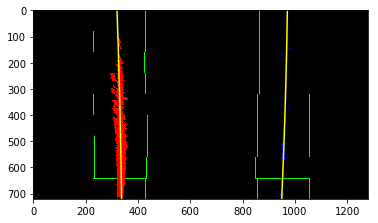

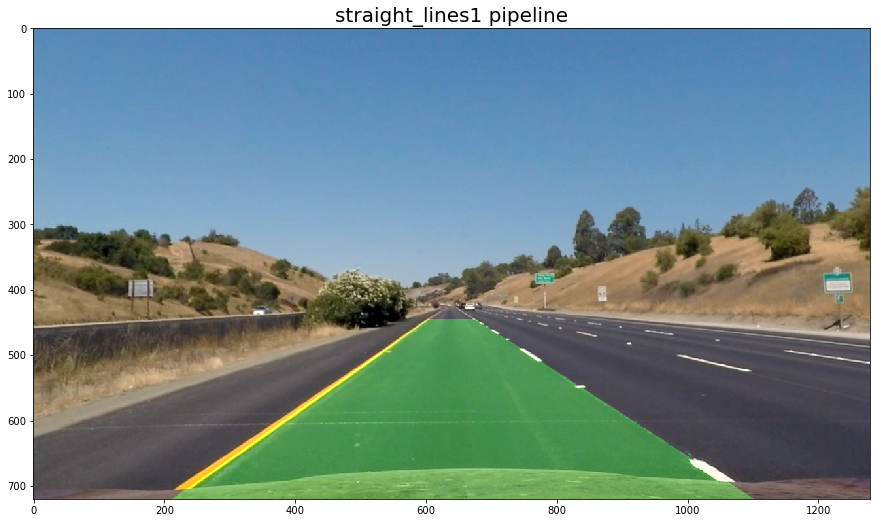

In [192]:
test_detector = LaneLineDetector(mtx, dist, src, dst)

pipeline_test_images = map_to_list(lambda img: test_detector.process_image(img), test_images[:1])
pipeline_test_images_labels = map_to_list(lambda label: label + ' pipeline', test_images_labels)

for i, image in enumerate(pipeline_test_images):
    label = pipeline_test_images_labels[i]
    plt.figure(figsize=(15,10))
    plt.imshow(image)
    plt.title(label, fontsize=20)
    plt.show()
    
    
#cv2.imwrite('examples/test_image_area.jpg', to_bgr(pipeline_test_images[0]))

# Testing on video

In [193]:
videos_path = 'test_videos'
videos_output_path = 'test_videos_output'

project_video_path = join(videos_path, 'project_video.mp4')
project_video_output_path = join(videos_output_path, 'project_video_output.mp4')

## Project video

277.717388681 m 455.047867193 m 0.56362691112 m
[MoviePy] >>>> Building video test_videos_output/project_video_output.mp4
[MoviePy] Writing video test_videos_output/project_video_output.mp4


  0%|          | 1/1261 [00:00<05:50,  3.60it/s]

277.717388681 m 455.047867193 m 0.56362691112 m


  0%|          | 2/1261 [00:00<05:57,  3.52it/s]

285.501604119 m 372.04842517 m 0.559088530428 m


  0%|          | 3/1261 [00:00<06:11,  3.38it/s]

281.973307245 m 304.000845551 m 0.554404255807 m


  0%|          | 4/1261 [00:01<06:07,  3.42it/s]

288.449120615 m 297.606557069 m 0.55797625177 m


  0%|          | 5/1261 [00:01<06:06,  3.43it/s]

284.321902997 m 298.466654591 m 0.559035093158 m


  0%|          | 6/1261 [00:01<06:18,  3.32it/s]

296.503643391 m 334.221460223 m 0.568438969015 m


  1%|          | 7/1261 [00:02<06:12,  3.36it/s]

303.746025467 m 314.235571124 m 0.569579674925 m


  1%|          | 8/1261 [00:02<06:09,  3.39it/s]

296.825020662 m 912.887031289 m 0.631147114338 m


  1%|          | 9/1261 [00:02<06:35,  3.16it/s]

309.964593274 m 929.244991971 m 0.624703835051 m


  1%|          | 10/1261 [00:03<06:43,  3.10it/s]

307.785050081 m 730.236053661 m 0.616885189606 m


  1%|          | 11/1261 [00:03<06:30,  3.20it/s]

308.64363924 m 494.500900108 m 0.598148833199 m


  1%|          | 12/1261 [00:03<06:41,  3.11it/s]

337.118989015 m 605.995983477 m 0.600553710279 m


  1%|          | 13/1261 [00:03<06:29,  3.21it/s]

326.756570955 m 583.597160657 m 0.594149131516 m


  1%|          | 14/1261 [00:04<06:21,  3.27it/s]

309.887575566 m 762.312607078 m 0.586949329105 m


  1%|          | 15/1261 [00:04<06:31,  3.18it/s]

285.837075462 m 462.063387097 m 0.567917984312 m


  1%|▏         | 16/1261 [00:04<06:16,  3.31it/s]

276.413620704 m 410.453209921 m 0.553763238081 m


  1%|▏         | 17/1261 [00:05<06:10,  3.36it/s]

270.955575464 m 418.411011286 m 0.543570641372 m


  1%|▏         | 18/1261 [00:05<06:14,  3.32it/s]

252.896361918 m 420.535838764 m 0.533859435411 m


  2%|▏         | 19/1261 [00:05<06:02,  3.42it/s]

266.124985619 m 404.881894037 m 0.530953977906 m


  2%|▏         | 20/1261 [00:06<05:55,  3.49it/s]

272.080553418 m 433.983375019 m 0.528554247288 m


  2%|▏         | 21/1261 [00:06<06:04,  3.41it/s]

283.515100634 m 742.779453059 m 0.551299471478 m


  2%|▏         | 22/1261 [00:06<06:02,  3.42it/s]

291.604578062 m 17510.1605169 m 0.55582823808 m


  2%|▏         | 23/1261 [00:06<06:00,  3.43it/s]

285.695718997 m 11309.7063481 m 0.54853449977 m


  2%|▏         | 24/1261 [00:07<06:22,  3.24it/s]

264.583812867 m 6261.32560218 m 0.527594817772 m


  2%|▏         | 25/1261 [00:07<06:23,  3.22it/s]

258.866058426 m 747.211227773 m 0.508667236061 m


  2%|▏         | 26/1261 [00:07<06:23,  3.22it/s]

260.96591107 m 585.525913836 m 0.503580338091 m


  2%|▏         | 27/1261 [00:08<06:36,  3.11it/s]

256.210772633 m 447.174421762 m 0.494272049845 m


  2%|▏         | 28/1261 [00:08<06:24,  3.21it/s]

266.760892701 m 391.885807509 m 0.48809975846 m


  2%|▏         | 29/1261 [00:08<07:13,  2.84it/s]

254.129358265 m 303.528858146 m 0.484986700237 m


  2%|▏         | 30/1261 [00:09<07:03,  2.91it/s]

235.101002365 m 301.146436184 m 0.483046605355 m


  2%|▏         | 31/1261 [00:09<06:40,  3.07it/s]

216.149219033 m 315.650626153 m 0.481426734383 m


  3%|▎         | 32/1261 [00:09<06:38,  3.09it/s]

206.520557587 m 265.247091393 m 0.477188429055 m


  3%|▎         | 33/1261 [00:10<06:22,  3.21it/s]

212.292546579 m 315.142693433 m 0.49228290749 m


  3%|▎         | 34/1261 [00:10<06:06,  3.35it/s]

211.917641722 m 1139.48977155 m 0.560479204592 m


  3%|▎         | 35/1261 [00:10<06:10,  3.31it/s]

209.768970184 m 535.983846308 m 0.539086613884 m


  3%|▎         | 36/1261 [00:11<06:05,  3.35it/s]

210.002168873 m 544.960001717 m 0.53847728475 m


  3%|▎         | 37/1261 [00:11<05:53,  3.47it/s]

208.784170107 m 682.329083566 m 0.529713685287 m


  3%|▎         | 38/1261 [00:11<06:06,  3.34it/s]

206.206007935 m 441.078672762 m 0.529248476857 m


  3%|▎         | 39/1261 [00:11<06:09,  3.30it/s]

201.040147933 m 343.303833076 m 0.516616260832 m


  3%|▎         | 40/1261 [00:12<06:03,  3.36it/s]

213.193933029 m 345.288749013 m 0.518748989516 m


  3%|▎         | 41/1261 [00:12<06:13,  3.26it/s]

210.521607749 m 282.436262861 m 0.514906598825 m


  3%|▎         | 42/1261 [00:12<06:08,  3.31it/s]

219.476413921 m 263.339226911 m 0.521404690223 m


  3%|▎         | 43/1261 [00:13<06:01,  3.37it/s]

234.576999363 m 317.704957525 m 0.531230465124 m


  3%|▎         | 44/1261 [00:13<06:08,  3.30it/s]

247.487574702 m 332.094529509 m 0.53181629665 m


  4%|▎         | 45/1261 [00:13<06:02,  3.35it/s]

269.065616019 m 281.951280472 m 0.540512698245 m


  4%|▎         | 46/1261 [00:14<05:55,  3.42it/s]

269.187365949 m 425.267999308 m 0.577607038445 m


  4%|▎         | 47/1261 [00:14<06:02,  3.35it/s]

275.575028763 m 653.292695341 m 0.589509726788 m


  4%|▍         | 48/1261 [00:14<06:04,  3.33it/s]

283.827347917 m 447.743511748 m 0.573140535971 m


  4%|▍         | 49/1261 [00:14<06:00,  3.36it/s]

298.733691938 m 429.583930398 m 0.566800563719 m


  4%|▍         | 50/1261 [00:15<06:16,  3.22it/s]

310.332919615 m 444.055286492 m 0.566155154415 m


  4%|▍         | 51/1261 [00:15<06:07,  3.29it/s]

314.943583581 m 513.751319955 m 0.564953387046 m


  4%|▍         | 52/1261 [00:15<05:57,  3.38it/s]

305.506065042 m 421.234273713 m 0.550458641614 m


  4%|▍         | 53/1261 [00:16<06:04,  3.31it/s]

309.751851949 m 378.137997256 m 0.539881132184 m


  4%|▍         | 54/1261 [00:16<06:01,  3.34it/s]

313.114294319 m 323.416429187 m 0.531813718928 m


  4%|▍         | 55/1261 [00:16<05:50,  3.44it/s]

305.472922693 m 271.65120715 m 0.522004350747 m


  4%|▍         | 56/1261 [00:17<06:05,  3.29it/s]

317.013883531 m 347.572877037 m 0.524013075581 m


  5%|▍         | 57/1261 [00:17<06:05,  3.30it/s]

305.486086637 m 313.058655869 m 0.515958666942 m


  5%|▍         | 58/1261 [00:17<06:02,  3.32it/s]

317.260325903 m 346.590791018 m 0.524731523965 m


  5%|▍         | 59/1261 [00:18<06:17,  3.18it/s]

297.764164725 m 386.419313099 m 0.534104522959 m


  5%|▍         | 60/1261 [00:18<06:10,  3.24it/s]

281.492405891 m 381.028975808 m 0.513700044346 m


  5%|▍         | 61/1261 [00:18<06:00,  3.33it/s]

279.400237335 m 408.579086601 m 0.50781562766 m


  5%|▍         | 62/1261 [00:18<06:10,  3.23it/s]

262.840434616 m 396.438332345 m 0.494108115087 m


  5%|▍         | 63/1261 [00:19<06:01,  3.31it/s]

277.383827763 m 421.702418153 m 0.487778550954 m


  5%|▌         | 64/1261 [00:19<05:52,  3.40it/s]

270.56473516 m 407.549114811 m 0.480160690528 m


  5%|▌         | 65/1261 [00:19<05:57,  3.35it/s]

279.553858519 m 393.369214358 m 0.470763938356 m


  5%|▌         | 66/1261 [00:20<05:49,  3.42it/s]

271.439177683 m 337.798530178 m 0.46019127729 m


  5%|▌         | 67/1261 [00:20<05:42,  3.49it/s]

266.228195835 m 370.055758194 m 0.448991137346 m


  5%|▌         | 68/1261 [00:20<05:55,  3.35it/s]

267.852082056 m 455.015061061 m 0.441355360957 m


  5%|▌         | 69/1261 [00:20<05:54,  3.36it/s]

271.81399364 m 352.401193555 m 0.438416651767 m


  6%|▌         | 70/1261 [00:21<05:46,  3.43it/s]

283.701583047 m 402.054335952 m 0.433925422458 m


  6%|▌         | 71/1261 [00:21<05:54,  3.36it/s]

282.689009762 m 428.747565594 m 0.444999763638 m


  6%|▌         | 72/1261 [00:21<05:52,  3.37it/s]

293.439440049 m 399.27010777 m 0.429823566793 m


  6%|▌         | 73/1261 [00:22<05:42,  3.47it/s]

296.647614107 m 438.080915349 m 0.429750439277 m


  6%|▌         | 74/1261 [00:22<05:49,  3.39it/s]

300.013855587 m 308.156261062 m 0.409105497956 m


  6%|▌         | 75/1261 [00:22<05:54,  3.34it/s]

330.77776087 m 300.990342277 m 0.409472687262 m


  6%|▌         | 76/1261 [00:23<05:49,  3.39it/s]

321.793180975 m 319.359897306 m 0.407654319411 m


  6%|▌         | 77/1261 [00:23<05:54,  3.34it/s]

354.678640491 m 309.717326299 m 0.406290452686 m


  6%|▌         | 78/1261 [00:23<05:56,  3.31it/s]

348.109566876 m 272.092082894 m 0.394389711233 m


  6%|▋         | 79/1261 [00:23<05:49,  3.38it/s]

344.269630261 m 337.972313883 m 0.39162523401 m


  6%|▋         | 80/1261 [00:24<06:02,  3.25it/s]

332.540356357 m 296.87750445 m 0.380420217755 m


  6%|▋         | 81/1261 [00:24<06:05,  3.23it/s]

309.100431952 m 278.111248898 m 0.368482360788 m


  7%|▋         | 82/1261 [00:24<06:02,  3.25it/s]

312.553672236 m 301.083914899 m 0.36360817326 m


  7%|▋         | 83/1261 [00:25<06:15,  3.14it/s]

310.57861031 m 322.59393639 m 0.368649678065 m


  7%|▋         | 84/1261 [00:25<06:18,  3.11it/s]

313.222548627 m 525.904911281 m 0.397166416925 m


  7%|▋         | 85/1261 [00:25<06:05,  3.22it/s]

303.613283383 m 501.13209577 m 0.387784932741 m


  7%|▋         | 86/1261 [00:26<06:08,  3.19it/s]

296.325920788 m 452.286037523 m 0.379350033 m


  7%|▋         | 87/1261 [00:26<06:01,  3.25it/s]

272.013467515 m 339.536255375 m 0.363910336863 m


  7%|▋         | 88/1261 [00:26<05:51,  3.34it/s]

251.114236068 m 335.657533095 m 0.362200702215 m


  7%|▋         | 89/1261 [00:27<06:01,  3.24it/s]

230.586404904 m 316.241149825 m 0.355651832488 m


  7%|▋         | 90/1261 [00:27<05:50,  3.34it/s]

208.944596004 m 300.69973224 m 0.352224339212 m


  7%|▋         | 91/1261 [00:27<05:40,  3.44it/s]

217.215470555 m 290.953468476 m 0.35315156058 m


  7%|▋         | 92/1261 [00:27<05:57,  3.27it/s]

219.729576777 m 327.891856289 m 0.357760112554 m


  7%|▋         | 93/1261 [00:28<06:00,  3.24it/s]

210.356466423 m 333.414945063 m 0.357190759009 m


  7%|▋         | 94/1261 [00:28<05:58,  3.25it/s]

207.065530989 m 330.60488515 m 0.357713122599 m


  8%|▊         | 95/1261 [00:28<06:08,  3.17it/s]

214.786089357 m 346.66353943 m 0.357753644101 m


  8%|▊         | 96/1261 [00:29<06:00,  3.23it/s]

221.61011335 m 470.257534417 m 0.384276327322 m


  8%|▊         | 97/1261 [00:29<05:52,  3.30it/s]

219.808054329 m 532.774504914 m 0.388305696006 m


  8%|▊         | 98/1261 [00:29<06:02,  3.21it/s]

227.46895117 m 383.786333133 m 0.371215090267 m


  8%|▊         | 99/1261 [00:30<05:52,  3.30it/s]

221.644354307 m 316.521533579 m 0.36750855722 m


  8%|▊         | 100/1261 [00:30<05:46,  3.35it/s]

222.782742888 m 282.805169174 m 0.360063551186 m


  8%|▊         | 101/1261 [00:30<05:48,  3.33it/s]

219.051860956 m 278.303163381 m 0.362721517344 m


  8%|▊         | 102/1261 [00:30<05:42,  3.38it/s]

220.432869475 m 251.401717947 m 0.36207519821 m


  8%|▊         | 103/1261 [00:31<05:36,  3.45it/s]

220.414701908 m 238.837631533 m 0.366762824633 m


  8%|▊         | 104/1261 [00:31<05:51,  3.29it/s]

218.290424999 m 237.617013469 m 0.373889082386 m


  8%|▊         | 105/1261 [00:31<05:49,  3.31it/s]

229.294042464 m 278.665653764 m 0.383041904475 m


  8%|▊         | 106/1261 [00:32<05:42,  3.37it/s]

236.641605467 m 292.356619632 m 0.389371606506 m


  8%|▊         | 107/1261 [00:32<05:51,  3.28it/s]

240.628510183 m 306.978560557 m 0.39839754445 m


  9%|▊         | 108/1261 [00:32<05:46,  3.33it/s]

230.83485155 m 306.528009489 m 0.410044065317 m


  9%|▊         | 109/1261 [00:33<05:41,  3.38it/s]

226.297298421 m 449.439119895 m 0.436148584982 m


  9%|▊         | 110/1261 [00:33<05:52,  3.26it/s]

228.912244609 m 419.603181311 m 0.436048974609 m


  9%|▉         | 111/1261 [00:33<05:47,  3.31it/s]

223.705948372 m 408.886702173 m 0.434052018043 m


  9%|▉         | 112/1261 [00:33<05:43,  3.34it/s]

242.184126656 m 374.46369473 m 0.436288253218 m


  9%|▉         | 113/1261 [00:34<06:27,  2.96it/s]

230.578274379 m 305.46900262 m 0.432066437627 m


  9%|▉         | 114/1261 [00:34<06:13,  3.07it/s]

230.033027992 m 352.65786352 m 0.442431665948 m


  9%|▉         | 115/1261 [00:34<06:00,  3.18it/s]

216.42779745 m 254.104597135 m 0.436989125074 m


  9%|▉         | 116/1261 [00:35<06:10,  3.09it/s]

216.705253021 m 249.364414999 m 0.43656682513 m


  9%|▉         | 117/1261 [00:35<06:04,  3.14it/s]

220.035363935 m 253.728041811 m 0.442386623675 m


  9%|▉         | 118/1261 [00:35<05:50,  3.26it/s]

221.792565405 m 237.302679564 m 0.445170170073 m


  9%|▉         | 119/1261 [00:36<06:00,  3.17it/s]

227.85570223 m 235.577298934 m 0.45183881768 m


 10%|▉         | 120/1261 [00:36<05:48,  3.27it/s]

219.51934726 m 223.543258408 m 0.456509516254 m


 10%|▉         | 121/1261 [00:36<05:39,  3.35it/s]

224.636181053 m 225.763924534 m 0.469216214544 m


 10%|▉         | 122/1261 [00:37<05:56,  3.20it/s]

222.108767178 m 280.460211467 m 0.493572163763 m


 10%|▉         | 123/1261 [00:37<05:44,  3.30it/s]

219.359641277 m 301.205246549 m 0.496088411422 m


 10%|▉         | 124/1261 [00:37<05:38,  3.36it/s]

220.817292826 m 241.814034493 m 0.489514528263 m


 10%|▉         | 125/1261 [00:38<05:47,  3.27it/s]

223.924470965 m 272.738380051 m 0.497987273964 m


 10%|▉         | 126/1261 [00:38<05:39,  3.34it/s]

240.962997449 m 356.940364296 m 0.516854957363 m


 10%|█         | 127/1261 [00:38<05:31,  3.42it/s]

242.161406855 m 384.305038957 m 0.522184854245 m


 10%|█         | 128/1261 [00:38<05:45,  3.28it/s]

255.994529749 m 327.038910369 m 0.518391566771 m


 10%|█         | 129/1261 [00:39<05:37,  3.35it/s]

233.453836188 m 234.48544169 m 0.508487086173 m


 10%|█         | 130/1261 [00:39<05:26,  3.46it/s]

246.197605599 m 228.617765346 m 0.504084704652 m


 10%|█         | 131/1261 [00:39<05:41,  3.31it/s]

245.663380221 m 274.254415077 m 0.51047091504 m


 10%|█         | 132/1261 [00:40<05:33,  3.39it/s]

239.213015029 m 268.10672775 m 0.513720701255 m


 11%|█         | 133/1261 [00:40<05:22,  3.50it/s]

241.963647757 m 260.377874818 m 0.517284949883 m


 11%|█         | 134/1261 [00:40<05:45,  3.26it/s]

239.11542723 m 434.372745912 m 0.562330912884 m


 11%|█         | 135/1261 [00:41<05:35,  3.35it/s]

256.40250468 m 364.921059938 m 0.5538225412 m


 11%|█         | 136/1261 [00:41<05:29,  3.42it/s]

260.447595433 m 424.76350696 m 0.561018923124 m


 11%|█         | 137/1261 [00:41<05:39,  3.32it/s]

273.578768825 m 394.718157957 m 0.552585521844 m


 11%|█         | 138/1261 [00:41<05:31,  3.39it/s]

286.760253388 m 339.61080211 m 0.544439723689 m


 11%|█         | 139/1261 [00:42<05:22,  3.48it/s]

284.759663271 m 505.361183043 m 0.545414642829 m


 11%|█         | 140/1261 [00:42<05:35,  3.34it/s]

298.827829872 m 388.858986593 m 0.538990908256 m


 11%|█         | 141/1261 [00:42<05:29,  3.40it/s]

299.564288747 m 418.277357378 m 0.538360081025 m


 11%|█▏        | 142/1261 [00:43<05:30,  3.38it/s]

295.513238642 m 399.739242062 m 0.531519503298 m


 11%|█▏        | 143/1261 [00:43<05:38,  3.30it/s]

276.381596415 m 365.012971731 m 0.522082581459 m


 11%|█▏        | 144/1261 [00:43<05:37,  3.31it/s]

280.073007944 m 374.796096557 m 0.517952236489 m


 11%|█▏        | 145/1261 [00:44<05:37,  3.30it/s]

280.977311867 m 389.998956358 m 0.514206142364 m


 12%|█▏        | 146/1261 [00:44<05:36,  3.32it/s]

262.602766577 m 383.533123204 m 0.515638534792 m


 12%|█▏        | 147/1261 [00:44<05:31,  3.36it/s]

264.366268691 m 651.177552239 m 0.546493371014 m


 12%|█▏        | 148/1261 [00:44<05:40,  3.27it/s]

243.531045942 m 1038.62318452 m 0.549836638301 m


 12%|█▏        | 149/1261 [00:45<05:36,  3.30it/s]

237.494818741 m 510.597530446 m 0.52891728264 m


 12%|█▏        | 150/1261 [00:45<05:26,  3.41it/s]

254.345793764 m 1491.41492647 m 0.561784704274 m


 12%|█▏        | 151/1261 [00:45<05:28,  3.38it/s]

258.287033026 m 785.441244708 m 0.534181911022 m


 12%|█▏        | 152/1261 [00:46<05:28,  3.38it/s]

265.220924441 m 453.751964601 m 0.518194349094 m


 12%|█▏        | 153/1261 [00:46<05:23,  3.42it/s]

250.71122177 m 669.054211036 m 0.510662610827 m


 12%|█▏        | 154/1261 [00:46<06:07,  3.01it/s]

260.925083882 m 272.08518686 m 0.494771369519 m


 12%|█▏        | 155/1261 [00:47<05:46,  3.19it/s]

273.460820537 m 283.147024928 m 0.49585739583 m


 12%|█▏        | 156/1261 [00:47<05:35,  3.29it/s]

273.174249817 m 355.880449854 m 0.495288128982 m


 12%|█▏        | 157/1261 [00:47<06:17,  2.92it/s]

267.050940292 m 311.267360865 m 0.487878533144 m


 13%|█▎        | 158/1261 [00:48<05:56,  3.10it/s]

249.007036449 m 262.135670735 m 0.473824108036 m


 13%|█▎        | 159/1261 [00:48<05:39,  3.25it/s]

250.887559041 m 414.480050939 m 0.499366885355 m


 13%|█▎        | 160/1261 [00:48<05:50,  3.14it/s]

242.972633887 m 379.912364199 m 0.48949468808 m


 13%|█▎        | 161/1261 [00:48<05:37,  3.26it/s]

251.354902503 m 320.353625209 m 0.483556193815 m


 13%|█▎        | 162/1261 [00:49<05:25,  3.38it/s]

244.597539245 m 342.481972487 m 0.479036619451 m


 13%|█▎        | 163/1261 [00:49<05:40,  3.22it/s]

256.129055018 m 383.638001515 m 0.481686440793 m


 13%|█▎        | 164/1261 [00:49<05:30,  3.32it/s]

248.911899716 m 415.546294412 m 0.483448943124 m


 13%|█▎        | 165/1261 [00:50<05:18,  3.44it/s]

226.431646031 m 626.380006681 m 0.477228543195 m


 13%|█▎        | 166/1261 [00:50<05:30,  3.32it/s]

225.366474705 m 245.234619884 m 0.455483628254 m


 13%|█▎        | 167/1261 [00:50<05:21,  3.40it/s]

212.327743087 m 277.512509151 m 0.455703224298 m


 13%|█▎        | 168/1261 [00:50<05:15,  3.46it/s]

224.665684895 m 297.69213574 m 0.455346725275 m


 13%|█▎        | 169/1261 [00:51<05:28,  3.33it/s]

225.813959567 m 337.721683125 m 0.45337825411 m


 13%|█▎        | 170/1261 [00:51<05:21,  3.39it/s]

239.342499323 m 411.020569861 m 0.446644646388 m


 14%|█▎        | 171/1261 [00:51<05:24,  3.36it/s]

242.497821963 m 339.322965913 m 0.442553713284 m


 14%|█▎        | 172/1261 [00:52<05:38,  3.22it/s]

238.747823685 m 363.344212436 m 0.442457818269 m


 14%|█▎        | 173/1261 [00:52<05:29,  3.31it/s]

226.386576072 m 252.088542541 m 0.409909941666 m


 14%|█▍        | 174/1261 [00:52<05:26,  3.33it/s]

210.176822177 m 234.992928593 m 0.401820789088 m


 14%|█▍        | 175/1261 [00:53<05:38,  3.21it/s]

199.761329042 m 295.497616247 m 0.402433364076 m


 14%|█▍        | 176/1261 [00:53<05:31,  3.27it/s]

195.903499003 m 171.561836416 m 0.376938171276 m


 14%|█▍        | 177/1261 [00:53<05:37,  3.21it/s]

211.717735854 m 193.588139015 m 0.387682520953 m


 14%|█▍        | 178/1261 [00:54<05:37,  3.21it/s]

215.380988224 m 202.379816523 m 0.395855967008 m


 14%|█▍        | 179/1261 [00:54<05:24,  3.34it/s]

210.895620481 m 195.832517083 m 0.398970725794 m


 14%|█▍        | 180/1261 [00:54<05:19,  3.38it/s]

211.749965404 m 178.378761577 m 0.404390523353 m


 14%|█▍        | 181/1261 [00:54<05:27,  3.30it/s]

196.844748125 m 191.240589876 m 0.407387976885 m


 14%|█▍        | 182/1261 [00:55<05:20,  3.37it/s]

203.271433801 m 186.012471873 m 0.406298954033 m


 15%|█▍        | 183/1261 [00:55<05:19,  3.37it/s]

192.701544478 m 177.942676432 m 0.408993562192 m


 15%|█▍        | 184/1261 [00:55<05:19,  3.37it/s]

181.494615227 m 210.058004471 m 0.446771949467 m


 15%|█▍        | 185/1261 [00:56<05:10,  3.46it/s]

172.488381138 m 196.019819728 m 0.429498103657 m


 15%|█▍        | 186/1261 [00:56<05:15,  3.40it/s]

158.258391514 m 184.29809355 m 0.425802645455 m


 15%|█▍        | 187/1261 [00:56<05:16,  3.40it/s]

157.406467395 m 172.954606726 m 0.424107240772 m


 15%|█▍        | 188/1261 [00:56<05:13,  3.43it/s]

154.622731874 m 209.815553594 m 0.442744353267 m


 15%|█▍        | 189/1261 [00:57<05:19,  3.36it/s]

158.459899623 m 211.785032578 m 0.444359158535 m


 15%|█▌        | 190/1261 [00:57<05:15,  3.40it/s]

158.738086267 m 227.069516415 m 0.451655820671 m


 15%|█▌        | 191/1261 [00:57<05:12,  3.42it/s]

157.634865578 m 239.579127429 m 0.45542812993 m


 15%|█▌        | 192/1261 [00:58<05:20,  3.34it/s]

162.272784239 m 292.012875099 m 0.461295787629 m


 15%|█▌        | 193/1261 [00:58<05:19,  3.35it/s]

160.258311069 m 265.119161179 m 0.467844918661 m


 15%|█▌        | 194/1261 [00:58<05:11,  3.42it/s]

167.22740827 m 256.882397812 m 0.471704037284 m


 15%|█▌        | 195/1261 [00:59<05:36,  3.17it/s]

165.869941425 m 253.18304514 m 0.469700603307 m


 16%|█▌        | 196/1261 [00:59<07:05,  2.51it/s]

195.612524551 m 367.427458061 m 0.502598038679 m


 16%|█▌        | 197/1261 [01:00<06:29,  2.73it/s]

227.757588499 m 370.190795222 m 0.494791500678 m


 16%|█▌        | 198/1261 [01:00<05:55,  2.99it/s]

253.173344608 m 422.823234269 m 0.495272630888 m


 16%|█▌        | 199/1261 [01:00<05:35,  3.16it/s]

278.929242132 m 1062.15152285 m 0.51467490808 m


 16%|█▌        | 200/1261 [01:00<05:22,  3.29it/s]

274.417737186 m 614.647076485 m 0.498437266618 m


 16%|█▌        | 201/1261 [01:01<05:09,  3.42it/s]

278.104213583 m 904.94100967 m 0.49410341902 m


 16%|█▌        | 202/1261 [01:01<05:02,  3.50it/s]

254.908437896 m 1161.41508446 m 0.479247166644 m


 16%|█▌        | 203/1261 [01:01<04:57,  3.56it/s]

245.294068937 m 347.392993726 m 0.454850651259 m


 16%|█▌        | 204/1261 [01:01<04:51,  3.62it/s]

250.279663836 m 270.713776832 m 0.446818148289 m


 16%|█▋        | 205/1261 [01:02<04:48,  3.66it/s]

236.075195668 m 270.464950274 m 0.442955724955 m


 16%|█▋        | 206/1261 [01:02<04:46,  3.69it/s]

226.648117254 m 322.300863885 m 0.447158405388 m


 16%|█▋        | 207/1261 [01:02<04:44,  3.71it/s]

206.818963281 m 281.907238785 m 0.441201321923 m


 16%|█▋        | 208/1261 [01:02<04:41,  3.74it/s]

193.116706373 m 452.534018 m 0.480246687925 m


 17%|█▋        | 209/1261 [01:03<04:37,  3.79it/s]

200.987838761 m 360.620200476 m 0.468491916719 m


 17%|█▋        | 210/1261 [01:03<04:35,  3.81it/s]

226.343845636 m 362.006158952 m 0.473610458501 m


 17%|█▋        | 211/1261 [01:03<04:35,  3.81it/s]

245.767691795 m 385.751110885 m 0.478391180278 m


 17%|█▋        | 212/1261 [01:04<04:35,  3.80it/s]

238.205257073 m 253.822273588 m 0.457390795844 m


 17%|█▋        | 213/1261 [01:04<04:33,  3.83it/s]

235.466436833 m 397.714879993 m 0.465686446807 m


 17%|█▋        | 214/1261 [01:04<04:32,  3.84it/s]

234.192114911 m 463.278198393 m 0.466227431669 m


 17%|█▋        | 215/1261 [01:04<04:31,  3.85it/s]

240.069225147 m 441.308256739 m 0.453813054706 m


 17%|█▋        | 216/1261 [01:05<04:31,  3.85it/s]

256.320524077 m 353.15646634 m 0.449721819183 m


 17%|█▋        | 217/1261 [01:05<04:29,  3.87it/s]

249.905911951 m 289.39128852 m 0.438002488485 m


 17%|█▋        | 218/1261 [01:05<04:31,  3.84it/s]

271.987733451 m 328.771810602 m 0.436087643913 m


 17%|█▋        | 219/1261 [01:05<04:33,  3.80it/s]

245.395380835 m 306.185474504 m 0.424663220388 m


 17%|█▋        | 220/1261 [01:06<04:32,  3.82it/s]

261.316086289 m 306.866484469 m 0.423476262843 m


 18%|█▊        | 221/1261 [01:06<04:33,  3.80it/s]

272.161601368 m 678.449543607 m 0.464368323898 m


 18%|█▊        | 222/1261 [01:06<04:36,  3.76it/s]

271.311221442 m 432.168223577 m 0.43654334752 m


 18%|█▊        | 223/1261 [01:06<04:35,  3.77it/s]

270.457131903 m 509.767798407 m 0.436589959617 m


 18%|█▊        | 224/1261 [01:07<04:35,  3.76it/s]

260.826152368 m 416.373491073 m 0.422161179544 m


 18%|█▊        | 225/1261 [01:07<04:32,  3.80it/s]

262.916935474 m 494.818013234 m 0.419835839471 m


 18%|█▊        | 226/1261 [01:07<04:33,  3.79it/s]

251.41158861 m 404.858369818 m 0.406391975751 m


 18%|█▊        | 227/1261 [01:07<04:32,  3.80it/s]

256.030382283 m 398.4321793 m 0.397442495763 m


 18%|█▊        | 228/1261 [01:08<04:31,  3.80it/s]

267.378984466 m 348.791156519 m 0.38869877432 m


 18%|█▊        | 229/1261 [01:08<04:32,  3.78it/s]

262.021986809 m 337.041394445 m 0.376298873666 m


 18%|█▊        | 230/1261 [01:08<04:33,  3.77it/s]

271.508770724 m 348.874988423 m 0.368693430001 m


 18%|█▊        | 231/1261 [01:08<04:31,  3.80it/s]

268.230999023 m 306.296694225 m 0.361702888681 m


 18%|█▊        | 232/1261 [01:09<04:30,  3.81it/s]

272.95947558 m 308.173680408 m 0.351147302273 m


 18%|█▊        | 233/1261 [01:09<04:31,  3.79it/s]

267.112729363 m 442.244499755 m 0.370781726592 m


 19%|█▊        | 234/1261 [01:09<04:31,  3.79it/s]

274.739573738 m 352.276580653 m 0.351847315096 m


 19%|█▊        | 235/1261 [01:10<04:27,  3.83it/s]

276.470802891 m 327.284176715 m 0.339352076844 m


 19%|█▊        | 236/1261 [01:10<04:28,  3.82it/s]

250.318177797 m 277.415864899 m 0.323059367491 m


 19%|█▉        | 237/1261 [01:10<04:28,  3.82it/s]

249.613875964 m 208.881244368 m 0.302835260422 m


 19%|█▉        | 238/1261 [01:10<04:30,  3.79it/s]

239.091431363 m 235.757546957 m 0.312018952954 m


 19%|█▉        | 239/1261 [01:11<04:26,  3.84it/s]

227.274815646 m 183.287951468 m 0.293593508797 m


 19%|█▉        | 240/1261 [01:11<04:26,  3.83it/s]

234.245361859 m 170.004497644 m 0.292878722405 m


 19%|█▉        | 241/1261 [01:11<04:26,  3.83it/s]

228.033825297 m 208.214599316 m 0.293555726824 m


 19%|█▉        | 242/1261 [01:11<04:26,  3.82it/s]

243.094611982 m 262.867120263 m 0.29735995757 m


 19%|█▉        | 243/1261 [01:12<04:23,  3.86it/s]

226.979019144 m 220.654439978 m 0.29397209061 m


 19%|█▉        | 244/1261 [01:12<04:26,  3.82it/s]

232.441714856 m 185.404327608 m 0.287876332354 m


 19%|█▉        | 245/1261 [01:12<04:29,  3.77it/s]

221.360660577 m 319.378814483 m 0.330267904059 m


 20%|█▉        | 246/1261 [01:12<04:26,  3.81it/s]

217.717013289 m 248.141657113 m 0.30052144783 m


 20%|█▉        | 247/1261 [01:13<04:49,  3.51it/s]

222.6003659 m 246.228281345 m 0.292259020492 m


 20%|█▉        | 248/1261 [01:13<04:40,  3.62it/s]

206.586133868 m 247.40233009 m 0.28303576107 m


 20%|█▉        | 249/1261 [01:13<04:35,  3.67it/s]

225.184434941 m 227.789963389 m 0.283675434393 m


 20%|█▉        | 250/1261 [01:14<04:29,  3.76it/s]

226.831257307 m 239.906946066 m 0.285998370021 m


 20%|█▉        | 251/1261 [01:14<04:24,  3.82it/s]

240.630664238 m 224.928038202 m 0.281574748594 m


 20%|█▉        | 252/1261 [01:14<04:24,  3.81it/s]

241.589849298 m 250.249351798 m 0.281989920822 m


 20%|██        | 253/1261 [01:14<04:22,  3.84it/s]

237.306308976 m 239.973702631 m 0.274301878628 m


 20%|██        | 254/1261 [01:15<04:21,  3.85it/s]

256.160189915 m 256.182088778 m 0.280542163372 m


 20%|██        | 255/1261 [01:15<04:21,  3.84it/s]

247.684336077 m 255.932684274 m 0.283744493126 m


 20%|██        | 256/1261 [01:15<04:20,  3.86it/s]

245.045860094 m 253.830826523 m 0.279614375424 m


 20%|██        | 257/1261 [01:15<04:19,  3.86it/s]

237.534114722 m 358.330619632 m 0.308648518626 m


 20%|██        | 258/1261 [01:16<04:17,  3.90it/s]

249.564074604 m 328.622623579 m 0.300014081474 m


 21%|██        | 259/1261 [01:16<04:17,  3.89it/s]

267.949114275 m 322.255239329 m 0.302051533383 m


 21%|██        | 260/1261 [01:16<04:18,  3.87it/s]

256.019469488 m 304.798972626 m 0.295706845274 m


 21%|██        | 261/1261 [01:16<04:21,  3.83it/s]

278.130918662 m 323.755114147 m 0.305018212642 m


 21%|██        | 262/1261 [01:17<04:19,  3.85it/s]

270.305987863 m 261.876461506 m 0.296643596581 m


 21%|██        | 263/1261 [01:17<04:19,  3.85it/s]

285.096646541 m 229.171080759 m 0.29552052693 m


 21%|██        | 264/1261 [01:17<04:18,  3.85it/s]

300.179800549 m 243.754981768 m 0.301525535705 m


 21%|██        | 265/1261 [01:17<04:20,  3.82it/s]

300.122268553 m 270.169794455 m 0.30116916174 m


 21%|██        | 266/1261 [01:18<04:17,  3.86it/s]

314.082571937 m 277.590875968 m 0.302767610075 m


 21%|██        | 267/1261 [01:18<04:19,  3.83it/s]

313.408175331 m 285.761251236 m 0.307725745368 m


 21%|██▏       | 268/1261 [01:18<04:17,  3.85it/s]

316.291936889 m 290.358915921 m 0.306857867639 m


 21%|██▏       | 269/1261 [01:18<04:17,  3.85it/s]

334.710619415 m 306.285888571 m 0.308698022771 m


 21%|██▏       | 270/1261 [01:19<04:15,  3.88it/s]

331.119752811 m 285.177034163 m 0.313913762858 m


 21%|██▏       | 271/1261 [01:19<04:17,  3.84it/s]

341.852502061 m 315.220412332 m 0.329574214652 m


 22%|██▏       | 272/1261 [01:19<04:16,  3.85it/s]

326.338216245 m 296.346705706 m 0.331747141167 m


 22%|██▏       | 273/1261 [01:19<04:17,  3.84it/s]

339.18442465 m 266.234191577 m 0.329930503896 m


 22%|██▏       | 274/1261 [01:20<04:17,  3.83it/s]

335.497002624 m 246.060598679 m 0.332111773994 m


 22%|██▏       | 275/1261 [01:20<04:17,  3.83it/s]

341.483397793 m 233.781344383 m 0.33147087758 m


 22%|██▏       | 276/1261 [01:20<04:18,  3.80it/s]

346.807026608 m 259.842380618 m 0.338156231525 m


 22%|██▏       | 277/1261 [01:21<04:18,  3.80it/s]

369.836556573 m 223.800865395 m 0.337855179105 m


 22%|██▏       | 278/1261 [01:21<04:18,  3.81it/s]

395.778083576 m 310.229546609 m 0.346901093562 m


 22%|██▏       | 279/1261 [01:21<04:15,  3.85it/s]

413.091068831 m 286.167926801 m 0.351732689056 m


 22%|██▏       | 280/1261 [01:21<04:15,  3.84it/s]

410.835480728 m 260.383799297 m 0.349107353565 m


 22%|██▏       | 281/1261 [01:22<04:14,  3.85it/s]

450.084685398 m 316.00641447 m 0.363451394942 m


 22%|██▏       | 282/1261 [01:22<04:12,  3.87it/s]

437.235832067 m 294.740901943 m 0.364095219775 m


 22%|██▏       | 283/1261 [01:22<04:12,  3.87it/s]

452.706016653 m 346.516007633 m 0.376498415841 m


 23%|██▎       | 284/1261 [01:22<04:14,  3.84it/s]

444.911790924 m 374.197510152 m 0.379604119742 m


 23%|██▎       | 285/1261 [01:23<04:14,  3.84it/s]

475.007165853 m 394.653660315 m 0.386182543145 m


 23%|██▎       | 286/1261 [01:23<04:11,  3.87it/s]

495.409225994 m 347.404557353 m 0.387239383325 m


 23%|██▎       | 287/1261 [01:23<04:15,  3.81it/s]

491.502690617 m 281.850201581 m 0.380361504427 m


 23%|██▎       | 288/1261 [01:23<04:15,  3.80it/s]

567.349591556 m 348.832645408 m 0.39533089308 m


 23%|██▎       | 289/1261 [01:24<04:15,  3.81it/s]

543.443330288 m 437.906159194 m 0.400885242924 m


 23%|██▎       | 290/1261 [01:24<04:15,  3.81it/s]

605.222296849 m 392.243546594 m 0.404866733557 m


 23%|██▎       | 291/1261 [01:24<04:13,  3.82it/s]

557.515285727 m 434.288729143 m 0.40616216324 m


 23%|██▎       | 292/1261 [01:24<04:14,  3.80it/s]

547.338351873 m 463.03131684 m 0.411158593666 m


 23%|██▎       | 293/1261 [01:25<04:15,  3.79it/s]

599.936598911 m 411.778977912 m 0.418654351754 m


 23%|██▎       | 294/1261 [01:25<04:15,  3.78it/s]

614.121445624 m 459.745707896 m 0.429885317078 m


 23%|██▎       | 295/1261 [01:25<04:14,  3.80it/s]

709.572440606 m 560.488493893 m 0.442550034072 m


 23%|██▎       | 296/1261 [01:26<04:15,  3.78it/s]

631.76288603 m 515.166391455 m 0.434433020212 m


 24%|██▎       | 297/1261 [01:26<04:16,  3.76it/s]

692.224947799 m 468.976241858 m 0.424720962616 m


 24%|██▎       | 298/1261 [01:26<04:15,  3.78it/s]

766.265466772 m 472.05128121 m 0.427533435426 m


 24%|██▎       | 299/1261 [01:26<04:16,  3.76it/s]

766.338255816 m 646.765414562 m 0.430043862555 m


 24%|██▍       | 300/1261 [01:27<04:16,  3.75it/s]

871.658748415 m 483.795945369 m 0.429548195298 m


 24%|██▍       | 301/1261 [01:27<04:19,  3.70it/s]

847.473836851 m 497.039638707 m 0.426609479205 m


 24%|██▍       | 302/1261 [01:27<04:22,  3.65it/s]

859.780575778 m 580.875543262 m 0.424985345855 m


 24%|██▍       | 303/1261 [01:27<04:24,  3.62it/s]

1043.78772087 m 539.016254666 m 0.427983383331 m


 24%|██▍       | 304/1261 [01:28<04:21,  3.66it/s]

785.073329156 m 504.933203178 m 0.420279499094 m


 24%|██▍       | 305/1261 [01:28<04:23,  3.63it/s]

884.130871856 m 1455.57322305 m 0.457236022597 m


 24%|██▍       | 306/1261 [01:28<04:24,  3.61it/s]

847.13618147 m 2220.4164829 m 0.455600667047 m


 24%|██▍       | 307/1261 [01:29<04:22,  3.64it/s]

870.639720116 m 1329.4100283 m 0.452160478138 m


 24%|██▍       | 308/1261 [01:29<04:20,  3.65it/s]

1054.59309639 m 1707.17290541 m 0.45952959777 m


 25%|██▍       | 309/1261 [01:29<04:18,  3.68it/s]

1537.37863346 m 19478.9835759 m 0.468903574734 m


 25%|██▍       | 310/1261 [01:29<04:22,  3.63it/s]

2288.24743044 m 6279.11595961 m 0.471475584556 m


 25%|██▍       | 311/1261 [01:30<04:26,  3.57it/s]

3125.23576818 m 3627.16830188 m 0.456715117973 m


 25%|██▍       | 312/1261 [01:30<04:22,  3.62it/s]

2610.87338754 m 2545.43520331 m 0.451628222663 m


 25%|██▍       | 313/1261 [01:30<04:20,  3.63it/s]

2391.23739855 m 4743.01888827 m 0.447188738133 m


 25%|██▍       | 314/1261 [01:30<04:19,  3.65it/s]

4410.98428833 m 1798.01896164 m 0.444896159872 m


 25%|██▍       | 315/1261 [01:31<04:20,  3.63it/s]

6730.49839063 m 987.028624217 m 0.442043712033 m


 25%|██▌       | 316/1261 [01:31<04:20,  3.63it/s]

8218.85033276 m 1193.36411257 m 0.441480637183 m


 25%|██▌       | 317/1261 [01:31<04:20,  3.62it/s]

4258.16812671 m 1072.17426559 m 0.442907486559 m


 25%|██▌       | 318/1261 [01:32<04:18,  3.65it/s]

10189.7168854 m 903.441935846 m 0.431151192893 m


 25%|██▌       | 319/1261 [01:32<04:20,  3.62it/s]

7396.06416213 m 897.240125202 m 0.432275902031 m


 25%|██▌       | 320/1261 [01:32<04:18,  3.64it/s]

37727.3884087 m 813.421149942 m 0.432836060882 m


 25%|██▌       | 321/1261 [01:32<04:18,  3.63it/s]

5613.30960879 m 1243.41749156 m 0.441676779449 m


 26%|██▌       | 322/1261 [01:33<04:20,  3.61it/s]

14566.8517365 m 708.305981523 m 0.436386175818 m


 26%|██▌       | 323/1261 [01:33<04:18,  3.63it/s]

17411.7516611 m 935.313242199 m 0.436154430023 m


 26%|██▌       | 324/1261 [01:33<04:11,  3.72it/s]

4012.31445053 m 1032.7628273 m 0.42896028684 m


 26%|██▌       | 325/1261 [01:33<04:11,  3.72it/s]

7555.4732785 m 1137.42115138 m 0.430559393059 m


 26%|██▌       | 326/1261 [01:34<04:15,  3.66it/s]

1883.02200653 m 914.261153232 m 0.425250683393 m


 26%|██▌       | 327/1261 [01:34<04:21,  3.57it/s]

3625.72632077 m 1054.68126731 m 0.427909651226 m


 26%|██▌       | 328/1261 [01:34<04:24,  3.53it/s]

3289.84113652 m 978.512876025 m 0.427716850085 m


 26%|██▌       | 329/1261 [01:35<04:19,  3.59it/s]

4094.89836513 m 22058.6980409 m 0.47972106806 m


 26%|██▌       | 330/1261 [01:35<04:20,  3.58it/s]

13516.8260128 m 19839.4709343 m 0.476347741233 m


 26%|██▌       | 331/1261 [01:35<04:21,  3.55it/s]

631725.729084 m 543857.021869 m 0.467940414738 m


 26%|██▋       | 332/1261 [01:35<04:16,  3.62it/s]

6505.35015608 m 33566.0140939 m 0.45962393357 m


 26%|██▋       | 333/1261 [01:36<04:17,  3.60it/s]

3446.94540437 m 9578.1244187 m 0.445329566472 m


 26%|██▋       | 334/1261 [01:36<04:13,  3.66it/s]

9855.37033564 m 20666.4490258 m 0.449722371167 m


 27%|██▋       | 335/1261 [01:36<04:17,  3.60it/s]

3865.41541477 m 4600.98242751 m 0.446382897005 m


 27%|██▋       | 336/1261 [01:37<04:19,  3.57it/s]

4202.6931386 m 6287.04792071 m 0.44692951793 m


 27%|██▋       | 337/1261 [01:37<04:17,  3.59it/s]

5352.58990562 m 1997.85235785 m 0.445158267146 m


 27%|██▋       | 338/1261 [01:37<04:16,  3.60it/s]

10193.2569471 m 3082.55177667 m 0.444396526996 m


 27%|██▋       | 339/1261 [01:37<04:14,  3.62it/s]

2288.94376103 m 8498.68470584 m 0.440036758589 m


 27%|██▋       | 340/1261 [01:38<04:13,  3.64it/s]

8582.79801268 m 43381.3401976 m 0.446030844974 m


 27%|██▋       | 341/1261 [01:38<04:13,  3.63it/s]

1683.02326541 m 2543.52758011 m 0.46219659949 m


 27%|██▋       | 342/1261 [01:38<04:07,  3.71it/s]

2035.99670371 m 1290.58491194 m 0.47029692121 m


 27%|██▋       | 343/1261 [01:38<04:04,  3.75it/s]

28333.5626378 m 3083.48323891 m 0.464422684384 m


 27%|██▋       | 344/1261 [01:39<04:04,  3.75it/s]

7460.9803652 m 2165.52532485 m 0.461263767579 m


 27%|██▋       | 345/1261 [01:39<03:59,  3.82it/s]

5353.39858827 m 8534.70545905 m 0.456153319798 m


 27%|██▋       | 346/1261 [01:39<03:57,  3.85it/s]

3126.51647787 m 8457.7410774 m 0.452494626625 m


 28%|██▊       | 347/1261 [01:39<03:56,  3.87it/s]

900.078235479 m 3467.2227272 m 0.438558533448 m


 28%|██▊       | 348/1261 [01:40<04:00,  3.80it/s]

1038.56719267 m 2283.6318918 m 0.439034167065 m


 28%|██▊       | 349/1261 [01:40<04:00,  3.79it/s]

1725.86582626 m 2223.02036735 m 0.440062564305 m


 28%|██▊       | 350/1261 [01:40<04:01,  3.77it/s]

1220.26955546 m 6001.08224715 m 0.437739865925 m


 28%|██▊       | 351/1261 [01:41<03:57,  3.83it/s]

1022.21725903 m 46895.4127004 m 0.437094736142 m


 28%|██▊       | 352/1261 [01:41<03:58,  3.82it/s]

1003.75071305 m 3093.52185905 m 0.435081259399 m


 28%|██▊       | 353/1261 [01:41<03:58,  3.81it/s]

814.241006672 m 5036.39694712 m 0.45424470454 m


 28%|██▊       | 354/1261 [01:41<03:54,  3.86it/s]

855.573039779 m 18347.8553891 m 0.452938162621 m


 28%|██▊       | 355/1261 [01:42<03:53,  3.88it/s]

968.620833698 m 4853.35594429 m 0.457798066121 m


 28%|██▊       | 356/1261 [01:42<03:55,  3.85it/s]

1156.80494719 m 5592.95670397 m 0.447026654859 m


 28%|██▊       | 357/1261 [01:42<03:54,  3.85it/s]

1517.80877314 m 1478.97517319 m 0.443821505222 m


 28%|██▊       | 358/1261 [01:42<04:00,  3.75it/s]

1330.29602328 m 2233.79776304 m 0.44375189345 m


 28%|██▊       | 359/1261 [01:43<03:58,  3.79it/s]

1966.5316292 m 1542.1668374 m 0.447762259913 m


 29%|██▊       | 360/1261 [01:43<03:57,  3.79it/s]

35697.702706 m 1888.76317069 m 0.454192616491 m


 29%|██▊       | 361/1261 [01:43<03:55,  3.82it/s]

1090.75692841 m 2125.61894851 m 0.468325666439 m


 29%|██▊       | 362/1261 [01:43<03:51,  3.88it/s]

888.717695527 m 1276.0262246 m 0.467452909623 m


 29%|██▉       | 363/1261 [01:44<03:49,  3.91it/s]

766.736181306 m 3997.86887395 m 0.47492337856 m


 29%|██▉       | 364/1261 [01:44<03:49,  3.91it/s]

785.134340024 m 5650.16229793 m 0.477067056828 m


 29%|██▉       | 365/1261 [01:44<03:50,  3.89it/s]

752.399375409 m 1034.42441389 m 0.528764325733 m


 29%|██▉       | 366/1261 [01:44<03:49,  3.91it/s]

795.212000925 m 2304.45458175 m 0.509289123919 m


 29%|██▉       | 367/1261 [01:45<03:50,  3.88it/s]

1643.601783 m 4655.52429111 m 0.481663726076 m


 29%|██▉       | 368/1261 [01:45<03:49,  3.90it/s]

1354.2172178 m 20890.9700325 m 0.474344934203 m


 29%|██▉       | 369/1261 [01:45<03:47,  3.92it/s]

2987.14351179 m 49481.7217352 m 0.456049319346 m


 29%|██▉       | 370/1261 [01:45<03:46,  3.94it/s]

5628.47506785 m 10250.2600769 m 0.446684807187 m


 29%|██▉       | 371/1261 [01:46<03:49,  3.88it/s]

7181.58792221 m 4796.86339134 m 0.439421464258 m


 30%|██▉       | 372/1261 [01:46<03:51,  3.84it/s]

2112.66559503 m 3557.98636799 m 0.424460840786 m


 30%|██▉       | 373/1261 [01:46<03:51,  3.84it/s]

2056.91666818 m 1488906.65728 m 0.416860459125 m


 30%|██▉       | 374/1261 [01:46<03:52,  3.82it/s]

1173.00339773 m 10651.1657704 m 0.401834022934 m


 30%|██▉       | 375/1261 [01:47<03:53,  3.79it/s]

1637.42518 m 5225.58528713 m 0.403183053359 m


 30%|██▉       | 376/1261 [01:47<03:57,  3.73it/s]

1042.88400424 m 10718.238315 m 0.396956655174 m


 30%|██▉       | 377/1261 [01:47<03:58,  3.70it/s]

915.992941235 m 5290.59811672 m 0.409780213496 m


 30%|██▉       | 378/1261 [01:48<03:59,  3.68it/s]

767.607604974 m 3058.072324 m 0.413051542804 m


 30%|███       | 379/1261 [01:48<03:54,  3.76it/s]

754.61252947 m 1500.55126846 m 0.418502992784 m


 30%|███       | 380/1261 [01:48<03:53,  3.77it/s]

563.751754343 m 2716.10043009 m 0.40733885603 m


 30%|███       | 381/1261 [01:48<03:53,  3.77it/s]

667.538677642 m 3467.05471063 m 0.41090579349 m


 30%|███       | 382/1261 [01:49<03:51,  3.79it/s]

813.30402323 m 2226.21629969 m 0.416012067569 m


 30%|███       | 383/1261 [01:49<03:49,  3.83it/s]

643.463124284 m 2233.53176223 m 0.411912917692 m


 30%|███       | 384/1261 [01:49<03:50,  3.81it/s]

742.893630872 m 1784.70004658 m 0.413183231076 m


 31%|███       | 385/1261 [01:49<03:46,  3.87it/s]

888.793802548 m 2983.52453782 m 0.417188222722 m


 31%|███       | 386/1261 [01:50<03:45,  3.88it/s]

979.872127517 m 4094.17434574 m 0.4173749803 m


 31%|███       | 387/1261 [01:50<03:44,  3.90it/s]

904.625821504 m 1960.35053624 m 0.416034153583 m


 31%|███       | 388/1261 [01:50<03:44,  3.89it/s]

937.569219011 m 27343.6157083 m 0.420391826423 m


 31%|███       | 389/1261 [01:50<03:44,  3.89it/s]

1324.25450783 m 2432.4425644 m 0.435733785734 m


 31%|███       | 390/1261 [01:51<03:47,  3.83it/s]

1605.56773202 m 958.705469835 m 0.462938144677 m


 31%|███       | 391/1261 [01:51<03:50,  3.77it/s]

3499.34020789 m 1197.07339151 m 0.458572424154 m


 31%|███       | 392/1261 [01:51<03:51,  3.76it/s]

2812.08690896 m 1152.26432413 m 0.453019980115 m


 31%|███       | 393/1261 [01:52<03:54,  3.70it/s]

3270.87208048 m 2389.98337607 m 0.438422090612 m


 31%|███       | 394/1261 [01:52<03:51,  3.74it/s]

1627.94091145 m 4602.86967564 m 0.425605368173 m


 31%|███▏      | 395/1261 [01:52<03:51,  3.73it/s]

2746.03494078 m 5988.00122747 m 0.424403752832 m


 31%|███▏      | 396/1261 [01:52<03:55,  3.67it/s]

2731.83613356 m 4158.57025736 m 0.419821156356 m


 31%|███▏      | 397/1261 [01:53<03:52,  3.72it/s]

3384.88223753 m 3644.83480361 m 0.41997350369 m


 32%|███▏      | 398/1261 [01:53<03:48,  3.78it/s]

2842.80822639 m 2725.05752703 m 0.415262386356 m


 32%|███▏      | 399/1261 [01:53<03:46,  3.80it/s]

2166.80477963 m 2667.01783783 m 0.410334935734 m


 32%|███▏      | 400/1261 [01:53<03:48,  3.77it/s]

1650.57436033 m 2578.22587139 m 0.405640544887 m


 32%|███▏      | 401/1261 [01:54<03:50,  3.73it/s]

2379.65794529 m 1841.04452787 m 0.412123280899 m


 32%|███▏      | 402/1261 [01:54<03:50,  3.72it/s]

2012.39487502 m 1125.29673682 m 0.429080600266 m


 32%|███▏      | 403/1261 [01:54<03:52,  3.69it/s]

3579.93657402 m 1968.54474338 m 0.414908126622 m


 32%|███▏      | 404/1261 [01:54<03:50,  3.72it/s]

4112.96521992 m 1636.62926739 m 0.415701987282 m


 32%|███▏      | 405/1261 [01:55<03:49,  3.73it/s]

3534.25717575 m 3352.26743968 m 0.399729167788 m


 32%|███▏      | 406/1261 [01:55<03:47,  3.76it/s]

2582.71983469 m 2811.2979542 m 0.389398450151 m


 32%|███▏      | 407/1261 [01:55<03:45,  3.79it/s]

4132.31543716 m 4782.76578431 m 0.387452288346 m


 32%|███▏      | 408/1261 [01:56<03:42,  3.83it/s]

3426.18069603 m 5469.49848505 m 0.378380046815 m


 32%|███▏      | 409/1261 [01:56<03:46,  3.76it/s]

3078.36799206 m 20413.5075774 m 0.372664434425 m


 33%|███▎      | 410/1261 [01:56<03:45,  3.78it/s]

2123.91002443 m 3965.39341645 m 0.366676321982 m


 33%|███▎      | 411/1261 [01:56<03:48,  3.73it/s]

2376.35332071 m 2658.76556466 m 0.363664661011 m


 33%|███▎      | 412/1261 [01:57<03:47,  3.74it/s]

2344.69699333 m 3681.27783973 m 0.361978566119 m


 33%|███▎      | 413/1261 [01:57<03:45,  3.76it/s]

2328.20298093 m 2804.86813197 m 0.362726133824 m


 33%|███▎      | 414/1261 [01:57<03:47,  3.73it/s]

2089.47999959 m 1372.79039497 m 0.376279104747 m


 33%|███▎      | 415/1261 [01:57<03:50,  3.67it/s]

2079.19684273 m 2778.99929908 m 0.354442278763 m


 33%|███▎      | 416/1261 [01:58<03:47,  3.71it/s]

1853.24051008 m 1957.33673546 m 0.355368570025 m


 33%|███▎      | 417/1261 [01:58<03:48,  3.70it/s]

1640.88096368 m 2548.47340202 m 0.350475640598 m


 33%|███▎      | 418/1261 [01:58<03:50,  3.65it/s]

1630.3646244 m 6729.98968043 m 0.344445766531 m


 33%|███▎      | 419/1261 [01:58<03:46,  3.71it/s]

2495.65662969 m 8578.32390758 m 0.344188353404 m


 33%|███▎      | 420/1261 [01:59<03:46,  3.72it/s]

1513.23877337 m 4875.6848664 m 0.33995064747 m


 33%|███▎      | 421/1261 [01:59<03:45,  3.72it/s]

2531.10734604 m 5666.94149754 m 0.343016669766 m


 33%|███▎      | 422/1261 [01:59<03:48,  3.68it/s]

1655.70967802 m 7149.78727059 m 0.334625668463 m


 34%|███▎      | 423/1261 [02:00<03:46,  3.70it/s]

1878.19780836 m 13396.0119987 m 0.331182524984 m


 34%|███▎      | 424/1261 [02:00<03:41,  3.77it/s]

1869.7255088 m 7705.50041711 m 0.325300472446 m


 34%|███▎      | 425/1261 [02:00<03:45,  3.71it/s]

2259.02189291 m 153773.86339 m 0.321357470668 m


 34%|███▍      | 426/1261 [02:00<03:42,  3.75it/s]

3226.31942038 m 226627.609698 m 0.32316423504 m


 34%|███▍      | 427/1261 [02:01<03:42,  3.74it/s]

3372.22500757 m 8042.9170544 m 0.318744290406 m


 34%|███▍      | 428/1261 [02:01<03:42,  3.75it/s]

2569.65738308 m 3732.37064167 m 0.307571112811 m


 34%|███▍      | 429/1261 [02:01<03:44,  3.70it/s]

3950.09399184 m 6383.89324635 m 0.304940830829 m


 34%|███▍      | 430/1261 [02:01<03:41,  3.74it/s]

3689.83419377 m 19520.838403 m 0.301937817316 m


 34%|███▍      | 431/1261 [02:02<03:43,  3.72it/s]

2079.98937945 m 23807.2787825 m 0.298607196381 m


 34%|███▍      | 432/1261 [02:02<03:42,  3.72it/s]

28486.5170868 m 18574.1432441 m 0.303418131254 m


 34%|███▍      | 433/1261 [02:02<03:42,  3.73it/s]

23398.9686658 m 2267.79855223 m 0.298779070831 m


 34%|███▍      | 434/1261 [02:03<03:41,  3.74it/s]

3813.96419058 m 2744.36512466 m 0.299601652576 m


 34%|███▍      | 435/1261 [02:03<03:42,  3.72it/s]

12966.1454704 m 3509.93010324 m 0.294338880225 m


 35%|███▍      | 436/1261 [02:03<03:40,  3.73it/s]

2317.11006861 m 7595.4080845 m 0.296249721253 m


 35%|███▍      | 437/1261 [02:03<03:37,  3.79it/s]

1772.44124492 m 1563.20890446 m 0.283997471158 m


 35%|███▍      | 438/1261 [02:04<03:38,  3.76it/s]

2191.60971001 m 1039.19188703 m 0.268284673106 m


 35%|███▍      | 439/1261 [02:04<03:38,  3.77it/s]

1604.22400268 m 1323.01792297 m 0.28216817121 m


 35%|███▍      | 440/1261 [02:04<03:38,  3.76it/s]

1311.43008989 m 2268.21316572 m 0.290976508573 m


 35%|███▍      | 441/1261 [02:04<03:37,  3.78it/s]

2193.65086965 m 3119.21778291 m 0.284773272718 m


 35%|███▌      | 442/1261 [02:05<03:34,  3.82it/s]

1760.7640525 m 3839.7404737 m 0.286243892826 m


 35%|███▌      | 443/1261 [02:05<03:33,  3.83it/s]

2275.16141613 m 4356.44408887 m 0.27783045849 m


 35%|███▌      | 444/1261 [02:05<03:33,  3.83it/s]

1090.84935122 m 1667.58884725 m 0.274984317112 m


 35%|███▌      | 445/1261 [02:05<03:33,  3.82it/s]

1221.00766605 m 1338.23206484 m 0.268020407233 m


 35%|███▌      | 446/1261 [02:06<03:33,  3.81it/s]

2032.69354258 m 1707.7063353 m 0.257300591048 m


 35%|███▌      | 447/1261 [02:06<03:32,  3.83it/s]

1974.58486474 m 2245.71015179 m 0.256679783239 m


 36%|███▌      | 448/1261 [02:06<03:35,  3.77it/s]

2328.99451855 m 2144.80380506 m 0.252001403604 m


 36%|███▌      | 449/1261 [02:06<03:34,  3.78it/s]

2474.44501613 m 5779.69468594 m 0.262096109764 m


 36%|███▌      | 450/1261 [02:07<03:31,  3.83it/s]

10172.0925691 m 11368.3329471 m 0.256068893817 m


 36%|███▌      | 451/1261 [02:07<03:30,  3.85it/s]

3447.09278103 m 22121.691783 m 0.246246393016 m


 36%|███▌      | 452/1261 [02:07<03:29,  3.86it/s]

2557.45730453 m 7263.29636285 m 0.238674269851 m


 36%|███▌      | 453/1261 [02:07<03:29,  3.85it/s]

2506.45198309 m 4156.4333474 m 0.239601904151 m


 36%|███▌      | 454/1261 [02:08<03:28,  3.87it/s]

2061.90765553 m 2076.11137032 m 0.239751006063 m


 36%|███▌      | 455/1261 [02:08<03:28,  3.87it/s]

1693.50808542 m 11048.3776805 m 0.246150780478 m


 36%|███▌      | 456/1261 [02:08<03:32,  3.79it/s]

1811.24075572 m 21372.8174235 m 0.247088864512 m


 36%|███▌      | 457/1261 [02:09<03:31,  3.79it/s]

1039.27478984 m 7563.31620026 m 0.241985807875 m


 36%|███▋      | 458/1261 [02:09<03:33,  3.76it/s]

1150.66069462 m 9813.13625276 m 0.246840649606 m


 36%|███▋      | 459/1261 [02:09<03:33,  3.76it/s]

1306.92945168 m 6877.88939785 m 0.255113264249 m


 36%|███▋      | 460/1261 [02:09<03:34,  3.74it/s]

1231.82109384 m 3604.21053136 m 0.255974315867 m


 37%|███▋      | 461/1261 [02:10<03:32,  3.76it/s]

1297.38672198 m 2075.75398059 m 0.271807033964 m


 37%|███▋      | 462/1261 [02:10<03:30,  3.80it/s]

994.063607495 m 1829.51628756 m 0.270225605144 m


 37%|███▋      | 463/1261 [02:10<03:28,  3.83it/s]

5697.69252361 m 906.487507092 m 0.303774804228 m


 37%|███▋      | 464/1261 [02:10<03:29,  3.81it/s]

3615.48820896 m 2006.57367782 m 0.283639371456 m


 37%|███▋      | 465/1261 [02:11<03:28,  3.82it/s]

3633.89923262 m 1152.98832263 m 0.287152502086 m


 37%|███▋      | 466/1261 [02:11<03:28,  3.81it/s]

2242.11539526 m 1302.35055692 m 0.284577368861 m


 37%|███▋      | 467/1261 [02:11<03:27,  3.83it/s]

2209.6726774 m 1580.39918227 m 0.281954556556 m


 37%|███▋      | 468/1261 [02:11<03:25,  3.85it/s]

2629.62231382 m 2948.41305482 m 0.280087879242 m


 37%|███▋      | 469/1261 [02:12<03:27,  3.82it/s]

2201.77969731 m 1125.90257511 m 0.281341599018 m


 37%|███▋      | 470/1261 [02:12<03:29,  3.77it/s]

2047.87407366 m 1550.96778927 m 0.275892075336 m


 37%|███▋      | 471/1261 [02:12<03:27,  3.80it/s]

10462.0263307 m 1440.06954825 m 0.28647200911 m


 37%|███▋      | 472/1261 [02:12<03:25,  3.84it/s]

9573.31616762 m 1479.54316977 m 0.28405443281 m


 38%|███▊      | 473/1261 [02:13<03:25,  3.83it/s]

14013.8454612 m 11538.3647034 m 0.268294765789 m


 38%|███▊      | 474/1261 [02:13<03:24,  3.84it/s]

12979.6204126 m 5511.74393347 m 0.265374335248 m


 38%|███▊      | 475/1261 [02:13<03:25,  3.82it/s]

11284.6670159 m 3471.22218097 m 0.280092921638 m


 38%|███▊      | 476/1261 [02:14<03:25,  3.82it/s]

13050.4301552 m 5322.54600823 m 0.278146240692 m


 38%|███▊      | 477/1261 [02:14<03:24,  3.84it/s]

9287.45232201 m 7627.64913494 m 0.28160968804 m


 38%|███▊      | 478/1261 [02:14<03:25,  3.82it/s]

15845.3676683 m 4581.59487498 m 0.276030967549 m


 38%|███▊      | 479/1261 [02:14<03:25,  3.80it/s]

14343.1437801 m 8660.01303532 m 0.283411048615 m


 38%|███▊      | 480/1261 [02:15<03:25,  3.80it/s]

10907.613445 m 9304.12681544 m 0.284684963052 m


 38%|███▊      | 481/1261 [02:15<03:23,  3.82it/s]

23906.1131127 m 2316.78363163 m 0.283316658984 m


 38%|███▊      | 482/1261 [02:15<03:25,  3.79it/s]

66043.0712048 m 37947.8483098 m 0.28357223588 m


 38%|███▊      | 483/1261 [02:15<03:48,  3.40it/s]

575483.343727 m 4202.69636864 m 0.28158080948 m


 38%|███▊      | 484/1261 [02:16<03:39,  3.54it/s]

12219.5483083 m 7802.21803007 m 0.282748285062 m


 38%|███▊      | 485/1261 [02:16<03:35,  3.60it/s]

36910.0235581 m 5423.26023635 m 0.311220153081 m


 39%|███▊      | 486/1261 [02:16<03:31,  3.66it/s]

14358.5050319 m 87387.0228859 m 0.301776397011 m


 39%|███▊      | 487/1261 [02:17<03:30,  3.68it/s]

3370.66753978 m 23074.5097883 m 0.297715596175 m


 39%|███▊      | 488/1261 [02:17<03:26,  3.74it/s]

5158.65221029 m 3287.11739935 m 0.289796985952 m


 39%|███▉      | 489/1261 [02:17<03:24,  3.77it/s]

4876.30695185 m 1874.90864822 m 0.289894322633 m


 39%|███▉      | 490/1261 [02:17<03:26,  3.74it/s]

2787.65534917 m 3224.79411273 m 0.284724292472 m


 39%|███▉      | 491/1261 [02:18<03:23,  3.78it/s]

4725.47405637 m 3101.77832754 m 0.292477831451 m


 39%|███▉      | 492/1261 [02:18<03:21,  3.82it/s]

4695.19287281 m 3754.98683005 m 0.291565595773 m


 39%|███▉      | 493/1261 [02:18<03:20,  3.84it/s]

2813.9733401 m 4566.20686339 m 0.291582125621 m


 39%|███▉      | 494/1261 [02:18<03:20,  3.83it/s]

2083.22771243 m 5420.11194735 m 0.288585533104 m


 39%|███▉      | 495/1261 [02:19<03:19,  3.84it/s]

1401.00915975 m 11188.2248892 m 0.288288872816 m


 39%|███▉      | 496/1261 [02:19<03:16,  3.88it/s]

1277.87821357 m 15742.2847102 m 0.289759821068 m


 39%|███▉      | 497/1261 [02:19<03:17,  3.88it/s]

877.608167079 m 1621.41031919 m 0.320334802107 m


 39%|███▉      | 498/1261 [02:19<03:18,  3.85it/s]

696.031239454 m 2602.32871448 m 0.301797047392 m


 40%|███▉      | 499/1261 [02:20<03:18,  3.83it/s]

708.908729808 m 9997.83502375 m 0.290000014394 m


 40%|███▉      | 500/1261 [02:20<03:19,  3.81it/s]

737.015924735 m 2311.15822852 m 0.298421455888 m


 40%|███▉      | 501/1261 [02:20<03:20,  3.79it/s]

843.87687007 m 2589.13246603 m 0.301698460131 m


 40%|███▉      | 502/1261 [02:20<03:21,  3.76it/s]

840.04509265 m 2714.72204076 m 0.301819800982 m


 40%|███▉      | 503/1261 [02:21<03:20,  3.78it/s]

623.665021425 m 3055.09228034 m 0.298011182748 m


 40%|███▉      | 504/1261 [02:21<03:19,  3.80it/s]

603.416486968 m 147211.53887 m 0.293617103183 m


 40%|████      | 505/1261 [02:21<03:18,  3.81it/s]

717.19449715 m 12613.3065681 m 0.299436786864 m


 40%|████      | 506/1261 [02:21<03:17,  3.82it/s]

931.085673482 m 5513.90639934 m 0.303737623228 m


 40%|████      | 507/1261 [02:22<03:17,  3.81it/s]

1228.79316721 m 4101.16998288 m 0.307560688687 m


 40%|████      | 508/1261 [02:22<03:18,  3.80it/s]

1560.70690285 m 8165.79062258 m 0.313782294011 m


 40%|████      | 509/1261 [02:22<03:18,  3.79it/s]

611.416850898 m 2905.77805653 m 0.314979558338 m


 40%|████      | 510/1261 [02:23<03:18,  3.78it/s]

791.11703268 m 4199.3642531 m 0.321341390995 m


 41%|████      | 511/1261 [02:23<03:16,  3.82it/s]

2000.45219264 m 14115.8886818 m 0.315707637089 m


 41%|████      | 512/1261 [02:23<03:18,  3.78it/s]

1787.51239472 m 5363.47921073 m 0.310686976846 m


 41%|████      | 513/1261 [02:23<03:18,  3.77it/s]

1372.95069193 m 3834.55426579 m 0.306805134456 m


 41%|████      | 514/1261 [02:24<03:19,  3.75it/s]

1564.80940837 m 2736.83310884 m 0.305143927241 m


 41%|████      | 515/1261 [02:24<03:26,  3.61it/s]

6866.60214361 m 2260.69939548 m 0.316239591612 m


 41%|████      | 516/1261 [02:24<03:33,  3.49it/s]

2351.07176872 m 6367.56802336 m 0.318477416286 m


 41%|████      | 517/1261 [02:25<03:33,  3.48it/s]

3131.2700728 m 4824.79247373 m 0.315870197011 m


 41%|████      | 518/1261 [02:25<03:29,  3.55it/s]

6337.10240349 m 2512.36034466 m 0.308128601412 m


 41%|████      | 519/1261 [02:25<03:23,  3.65it/s]

5070.39425236 m 3737.466355 m 0.307320852856 m


 41%|████      | 520/1261 [02:25<03:23,  3.64it/s]

2575.47260588 m 4424.27536392 m 0.309923730227 m


 41%|████▏     | 521/1261 [02:26<03:19,  3.71it/s]

9837.86825622 m 6998.13993308 m 0.350814756933 m


 41%|████▏     | 522/1261 [02:26<03:19,  3.70it/s]

3438.57179978 m 3840.74926273 m 0.352318469435 m


 41%|████▏     | 523/1261 [02:26<03:17,  3.74it/s]

3170.69795006 m 3940.0673148 m 0.347528666455 m


 42%|████▏     | 524/1261 [02:26<03:18,  3.72it/s]

1676.75189591 m 1797.14041551 m 0.343209431891 m


 42%|████▏     | 525/1261 [02:27<03:18,  3.70it/s]

1215.80677752 m 2094.27051648 m 0.325983897395 m


 42%|████▏     | 526/1261 [02:27<03:21,  3.65it/s]

3336.47080779 m 3028.27793874 m 0.329409837274 m


 42%|████▏     | 527/1261 [02:27<03:22,  3.63it/s]

1347.39516897 m 2408.33057927 m 0.313123532617 m


 42%|████▏     | 528/1261 [02:27<03:24,  3.59it/s]

1375.50394675 m 2732.37580361 m 0.306425714688 m


 42%|████▏     | 529/1261 [02:28<03:25,  3.56it/s]

815.050040936 m 2979.77185701 m 0.291485933742 m


 42%|████▏     | 530/1261 [02:28<03:26,  3.54it/s]

919.498351426 m 1909.10199585 m 0.299555761457 m


 42%|████▏     | 531/1261 [02:28<03:24,  3.57it/s]

1626.59148854 m 1838.36416401 m 0.314447104446 m


 42%|████▏     | 532/1261 [02:29<03:26,  3.53it/s]

1946.81657893 m 4793.2486548 m 0.33768396425 m


 42%|████▏     | 533/1261 [02:29<03:22,  3.60it/s]

1677.31249219 m 1858.36380476 m 0.364155955532 m


 42%|████▏     | 534/1261 [02:29<03:22,  3.59it/s]

1479.6006361 m 1613.37338293 m 0.371300060818 m


 42%|████▏     | 535/1261 [02:29<03:23,  3.56it/s]

1788.36267273 m 2232.97527165 m 0.360358528327 m


 43%|████▎     | 536/1261 [02:30<03:24,  3.55it/s]

1189.00568428 m 2846.38903238 m 0.36765943813 m


 43%|████▎     | 537/1261 [02:30<03:23,  3.55it/s]

2571.8918978 m 2919.16268331 m 0.353224550307 m


 43%|████▎     | 538/1261 [02:30<03:25,  3.52it/s]

2495.20756485 m 2739.7218108 m 0.362008135279 m


 43%|████▎     | 539/1261 [02:31<03:27,  3.49it/s]

2216.64924095 m 3018.62318006 m 0.358223965962 m


 43%|████▎     | 540/1261 [02:31<03:25,  3.50it/s]

22079.3017597 m 3562.97858673 m 0.338433831257 m


 43%|████▎     | 541/1261 [02:31<03:26,  3.49it/s]

3066.35133508 m 2596.03870919 m 0.351402489715 m


 43%|████▎     | 542/1261 [02:31<03:21,  3.56it/s]

3585.37131042 m 2350.60715263 m 0.357547500194 m


 43%|████▎     | 543/1261 [02:32<03:18,  3.61it/s]

1814.8566342 m 2680.43120153 m 0.340300862121 m


 43%|████▎     | 544/1261 [02:32<03:14,  3.68it/s]

3423.19287828 m 2203.0619786 m 0.342068063658 m


 43%|████▎     | 545/1261 [02:32<03:14,  3.68it/s]

3721.72904704 m 1662.94648604 m 0.351121686361 m


 43%|████▎     | 546/1261 [02:33<03:15,  3.67it/s]

17205.528871 m 15561.1457679 m 0.332506785263 m


 43%|████▎     | 547/1261 [02:33<03:14,  3.67it/s]

7126.17596301 m 55173.1739058 m 0.340900791382 m


 43%|████▎     | 548/1261 [02:33<03:20,  3.55it/s]

2886.80839037 m 15216.3787448 m 0.322153395576 m


 44%|████▎     | 549/1261 [02:33<03:17,  3.61it/s]

2500.22374179 m 16181.6758803 m 0.314118019188 m


 44%|████▎     | 550/1261 [02:34<03:14,  3.66it/s]

5646.10971279 m 2932.05529949 m 0.325843137049 m


 44%|████▎     | 551/1261 [02:34<03:12,  3.69it/s]

2798.05780194 m 10715.5787541 m 0.3112873383 m


 44%|████▍     | 552/1261 [02:34<03:12,  3.69it/s]

5012.0338691 m 28340.6527762 m 0.329819227966 m


 44%|████▍     | 553/1261 [02:35<03:27,  3.42it/s]

2481.74858031 m 4279.96262151 m 0.337046571018 m


 44%|████▍     | 554/1261 [02:35<03:23,  3.48it/s]

4465.16490558 m 2878.35818667 m 0.338658085702 m


 44%|████▍     | 555/1261 [02:35<03:23,  3.47it/s]

4812.33567613 m 1535.19391101 m 0.357816799529 m


 44%|████▍     | 556/1261 [02:35<03:18,  3.55it/s]

5053.70061858 m 1355.51866834 m 0.359583939151 m


 44%|████▍     | 557/1261 [02:36<03:12,  3.65it/s]

15854.5314364 m 1893.96299183 m 0.350165802981 m


 44%|████▍     | 558/1261 [02:36<03:09,  3.70it/s]

8667.66090828 m 1597.78902922 m 0.354198962991 m


 44%|████▍     | 559/1261 [02:36<03:08,  3.73it/s]

2161.04240115 m 1393.03985779 m 0.356457080802 m


 44%|████▍     | 560/1261 [02:36<03:10,  3.67it/s]

2648.88626805 m 6533.09595485 m 0.368679158063 m


 44%|████▍     | 561/1261 [02:37<03:11,  3.66it/s]

8248.44756591 m 3175.85598974 m 0.370124353945 m


 45%|████▍     | 562/1261 [02:37<03:12,  3.62it/s]

3716.01378763 m 1281.70039268 m 0.404362654336 m


 45%|████▍     | 563/1261 [02:37<03:11,  3.65it/s]

2639.61607263 m 1183.18512468 m 0.353755439576 m


 45%|████▍     | 564/1261 [02:38<03:10,  3.67it/s]

1110.63992765 m 1591.0051671 m 0.30919713004 m


 45%|████▍     | 565/1261 [02:38<03:07,  3.70it/s]

1707.78594867 m 1006.20654533 m 0.299953208924 m


 45%|████▍     | 566/1261 [02:38<03:05,  3.76it/s]

733.690785744 m 941.289770655 m 0.299468924671 m


 45%|████▍     | 567/1261 [02:38<03:04,  3.76it/s]

1013.72812957 m 847.73768402 m 0.305460311463 m


 45%|████▌     | 568/1261 [02:39<03:04,  3.76it/s]

5042.26161208 m 652.343504439 m 0.313054445213 m


 45%|████▌     | 569/1261 [02:39<03:03,  3.77it/s]

1137.92262369 m 673.959679601 m 0.311171487848 m


 45%|████▌     | 570/1261 [02:39<03:05,  3.73it/s]

1978.71384856 m 762.920205968 m 0.322493115305 m


 45%|████▌     | 571/1261 [02:39<03:05,  3.73it/s]

162582.753715 m 781.754904113 m 0.325817044324 m


 45%|████▌     | 572/1261 [02:40<03:04,  3.73it/s]

1501.40168872 m 809.967883808 m 0.335804128593 m


 45%|████▌     | 573/1261 [02:40<03:03,  3.76it/s]

1507.21931011 m 837.17659824 m 0.338190025554 m


 46%|████▌     | 574/1261 [02:40<03:04,  3.73it/s]

3236.76830185 m 1021.24329023 m 0.354475974553 m


 46%|████▌     | 575/1261 [02:40<03:05,  3.69it/s]

6268.40433355 m 913.413004645 m 0.358808788709 m


 46%|████▌     | 576/1261 [02:41<03:06,  3.68it/s]

1617.89308144 m 1235.54308069 m 0.376027227749 m


 46%|████▌     | 577/1261 [02:41<03:07,  3.65it/s]

756.464473352 m 336.739067448 m 0.483380083692 m


 46%|████▌     | 578/1261 [02:41<03:04,  3.70it/s]

1210.59250489 m 269.947346864 m 0.467506004161 m


 46%|████▌     | 579/1261 [02:42<03:01,  3.76it/s]

2013.57234716 m 203.863277175 m 0.474830277234 m


 46%|████▌     | 580/1261 [02:42<02:59,  3.80it/s]

4217.17707069 m 495.804372197 m 0.414226569172 m


 46%|████▌     | 581/1261 [02:42<02:57,  3.82it/s]

1760.11697782 m 158.377142035 m 0.471119381913 m


 46%|████▌     | 582/1261 [02:42<02:57,  3.84it/s]

2148.47297969 m 139.390047137 m 0.454694205113 m


 46%|████▌     | 583/1261 [02:43<02:58,  3.81it/s]

4478.95589529 m 187.910816166 m 0.410206157024 m


 46%|████▋     | 584/1261 [02:43<02:59,  3.77it/s]

830.273202966 m 707.378022501 m 0.365232244228 m


 46%|████▋     | 585/1261 [02:43<02:59,  3.76it/s]

1092.11430595 m 766.306029908 m 0.351520136776 m


 46%|████▋     | 586/1261 [02:43<02:58,  3.78it/s]

597.977796286 m 674.416825226 m 0.35553906085 m


 47%|████▋     | 587/1261 [02:44<02:56,  3.83it/s]

641.649680766 m 676.91821578 m 0.353844132366 m


 47%|████▋     | 588/1261 [02:44<02:54,  3.86it/s]

925.581303442 m 561.917057615 m 0.36820213683 m


 47%|████▋     | 589/1261 [02:44<02:52,  3.89it/s]

1043.26303519 m 300.834124634 m 0.442381011869 m


 47%|████▋     | 590/1261 [02:44<02:52,  3.90it/s]

1157.22004537 m 272.171045784 m 0.460879955012 m


 47%|████▋     | 591/1261 [02:45<02:52,  3.89it/s]

1030.42664948 m 324.664207684 m 0.409704180884 m


 47%|████▋     | 592/1261 [02:45<02:50,  3.92it/s]

610.421819665 m 494.386134074 m 0.354400869567 m


 47%|████▋     | 593/1261 [02:45<02:50,  3.91it/s]

699.432736553 m 325.017731924 m 0.366775225556 m


 47%|████▋     | 594/1261 [02:45<02:50,  3.92it/s]

558.942150893 m 747.424005635 m 0.31631233897 m


 47%|████▋     | 595/1261 [02:46<02:51,  3.88it/s]

610.548798642 m 670.385255314 m 0.30804323002 m


 47%|████▋     | 596/1261 [02:46<02:51,  3.88it/s]

8019.95231041 m 689.608000904 m 0.315305434542 m


 47%|████▋     | 597/1261 [02:46<02:51,  3.87it/s]

4469.99277034 m 654.575681979 m 0.314101437845 m


 47%|████▋     | 598/1261 [02:46<02:52,  3.84it/s]

587.548255762 m 860.997749965 m 0.296572442308 m


 48%|████▊     | 599/1261 [02:47<02:51,  3.85it/s]

5868.11260637 m 776.783193426 m 0.296271922536 m


 48%|████▊     | 600/1261 [02:47<02:51,  3.84it/s]

3861.99193648 m 454.645670461 m 0.335957685883 m


 48%|████▊     | 601/1261 [02:47<02:51,  3.84it/s]

478.831005632 m 199.440617523 m 0.462246532166 m


 48%|████▊     | 602/1261 [02:47<02:53,  3.81it/s]

554.31350265 m 223.5192238 m 0.428802496189 m


 48%|████▊     | 603/1261 [02:48<02:51,  3.85it/s]

588.32892704 m 320.060157337 m 0.356110030796 m


 48%|████▊     | 604/1261 [02:48<02:49,  3.88it/s]

401.087401365 m 323.227547571 m 0.344539763831 m


 48%|████▊     | 605/1261 [02:48<02:48,  3.90it/s]

448.878667195 m 390.673903018 m 0.306686835171 m


 48%|████▊     | 606/1261 [02:49<02:47,  3.90it/s]

531.857857252 m 309.604822854 m 0.290153012859 m


 48%|████▊     | 607/1261 [02:49<02:45,  3.94it/s]

611.972697073 m 312.834885234 m 0.266777595152 m


 48%|████▊     | 608/1261 [02:49<02:44,  3.97it/s]

824.5800567 m 304.288502999 m 0.253913922794 m


 48%|████▊     | 609/1261 [02:49<02:44,  3.96it/s]

176794.976594 m 370.930404736 m 0.232549520252 m


 48%|████▊     | 610/1261 [02:50<02:44,  3.96it/s]

245.249197196 m 352.686608182 m 0.243376681975 m


 48%|████▊     | 611/1261 [02:50<02:46,  3.91it/s]

208.595615464 m 309.64544598 m 0.264668580282 m


 49%|████▊     | 612/1261 [02:50<02:51,  3.79it/s]

203.793883491 m 295.925853187 m 0.262997691219 m


 49%|████▊     | 613/1261 [02:50<02:48,  3.84it/s]

192.558958179 m 265.457449701 m 0.274091130715 m


 49%|████▊     | 614/1261 [02:51<02:51,  3.78it/s]

122.794342934 m 280.611876006 m 0.253585685061 m


 49%|████▉     | 615/1261 [02:51<02:54,  3.69it/s]

113.561381087 m 267.758485892 m 0.258140284116 m


 49%|████▉     | 616/1261 [02:51<02:53,  3.72it/s]

140.280850556 m 365.192419036 m 0.169747385616 m


 49%|████▉     | 617/1261 [02:51<02:52,  3.74it/s]

164.292241847 m 434.356147074 m 0.148099495956 m


 49%|████▉     | 618/1261 [02:52<02:50,  3.78it/s]

151.434545136 m 504.504075907 m 0.151543821465 m


 49%|████▉     | 619/1261 [02:52<02:47,  3.83it/s]

214.328314263 m 383.209760785 m 0.158805261138 m


 49%|████▉     | 620/1261 [02:52<02:46,  3.86it/s]

185.461022344 m 284.284560814 m 0.195816735812 m


 49%|████▉     | 621/1261 [02:52<02:46,  3.83it/s]

146.703447574 m 234.88480512 m 0.217196288231 m


 49%|████▉     | 622/1261 [02:53<02:46,  3.84it/s]

149.390553945 m 234.274609304 m 0.226056330369 m


 49%|████▉     | 623/1261 [02:53<02:49,  3.75it/s]

196.720086721 m 584.611996543 m 0.165203287996 m


 49%|████▉     | 624/1261 [02:53<02:47,  3.81it/s]

234.805956663 m 387.094252839 m 0.184915856419 m


 50%|████▉     | 625/1261 [02:53<02:48,  3.78it/s]

118.87705205 m 334.957749761 m 0.207575144056 m


 50%|████▉     | 626/1261 [02:54<02:48,  3.77it/s]

113.690394887 m 316.003365136 m 0.223220920575 m


 50%|████▉     | 627/1261 [02:54<02:48,  3.76it/s]

109.34445963 m 335.459692368 m 0.222636058211 m


 50%|████▉     | 628/1261 [02:54<02:48,  3.77it/s]

217.05181524 m 253.186241677 m -0.56137315385 m


 50%|████▉     | 629/1261 [02:55<02:46,  3.80it/s]

436.254442593 m 194.956595865 m -0.624676934434 m


 50%|████▉     | 630/1261 [02:55<02:44,  3.83it/s]

166.203716083 m 213.771881582 m 0.331538244717 m


 50%|█████     | 631/1261 [02:55<02:43,  3.85it/s]

402.510402224 m 223.833079645 m 0.282495453668 m


 50%|█████     | 632/1261 [02:55<02:44,  3.82it/s]

753.200979982 m 179.184303586 m 0.282691276325 m


 50%|█████     | 633/1261 [02:56<02:43,  3.84it/s]

327.097305649 m 188.031269856 m 0.284930933013 m


 50%|█████     | 634/1261 [02:56<02:42,  3.85it/s]

343.22815435 m 353.581160696 m 0.236706334546 m


 50%|█████     | 635/1261 [02:56<02:43,  3.82it/s]

234.321302825 m 328.864764796 m 0.234691813247 m


 50%|█████     | 636/1261 [02:56<02:44,  3.81it/s]

244.469314984 m 280.302716762 m 0.238150832735 m


 51%|█████     | 637/1261 [02:57<02:42,  3.84it/s]

245.887558316 m 235.079379397 m 0.248331737195 m


 51%|█████     | 638/1261 [02:57<02:41,  3.85it/s]

244.581525065 m 224.037050948 m 0.260689414819 m


 51%|█████     | 639/1261 [02:57<02:46,  3.74it/s]

473.788787811 m 272.322922089 m 0.257736118095 m


 51%|█████     | 640/1261 [02:57<02:43,  3.79it/s]

564.378551202 m 321.440021777 m 0.26598503853 m


 51%|█████     | 641/1261 [02:58<02:43,  3.79it/s]

690.523841879 m 307.442564625 m 0.29202291063 m


 51%|█████     | 642/1261 [02:58<02:42,  3.81it/s]

1177.78347991 m 136.651825905 m 0.405071753583 m


 51%|█████     | 643/1261 [02:58<02:44,  3.76it/s]

809.391708616 m 162.912914978 m 0.376235588721 m


 51%|█████     | 644/1261 [02:58<02:43,  3.77it/s]

761.045798382 m 291.187819507 m 0.323359252504 m


 51%|█████     | 645/1261 [02:59<02:42,  3.79it/s]

743.556347839 m 282.306813517 m 0.327210357767 m


 51%|█████     | 646/1261 [02:59<02:41,  3.82it/s]

823.03707927 m 301.607089227 m 0.315228942504 m


 51%|█████▏    | 647/1261 [02:59<02:39,  3.86it/s]

816.781503371 m 329.453806795 m 0.316631361723 m


 51%|█████▏    | 648/1261 [03:00<02:39,  3.83it/s]

931.948400206 m 326.574451829 m 0.319864458834 m


 51%|█████▏    | 649/1261 [03:00<02:42,  3.76it/s]

980.568041271 m 318.862834111 m 0.321174676258 m


 52%|█████▏    | 650/1261 [03:00<02:43,  3.73it/s]

838.459988787 m 350.739827617 m 0.328452074858 m


 52%|█████▏    | 651/1261 [03:00<02:42,  3.76it/s]

866.369113667 m 307.55793082 m 0.334261892714 m


 52%|█████▏    | 652/1261 [03:01<02:44,  3.71it/s]

440.006057198 m 340.095431242 m 0.346939566737 m


 52%|█████▏    | 653/1261 [03:01<02:43,  3.72it/s]

522.926186101 m 324.198022744 m 0.353138495135 m


 52%|█████▏    | 654/1261 [03:01<02:42,  3.73it/s]

472.708386373 m 263.898290019 m 0.402334098454 m


 52%|█████▏    | 655/1261 [03:01<02:41,  3.76it/s]

413.117393844 m 252.78038205 m 0.412994472498 m


 52%|█████▏    | 656/1261 [03:02<02:43,  3.71it/s]

348.393236988 m 323.621940496 m 0.388395925729 m


 52%|█████▏    | 657/1261 [03:02<02:41,  3.75it/s]

303.181261177 m 373.446477738 m 0.382851130473 m


 52%|█████▏    | 658/1261 [03:02<02:41,  3.74it/s]

286.993787406 m 360.269111884 m 0.383350008142 m


 52%|█████▏    | 659/1261 [03:02<02:40,  3.75it/s]

305.905221031 m 371.461746368 m 0.376871436815 m


 52%|█████▏    | 660/1261 [03:03<02:41,  3.72it/s]

293.063762861 m 405.652261425 m 0.374825286647 m


 52%|█████▏    | 661/1261 [03:03<02:41,  3.71it/s]

271.62633527 m 446.246383886 m 0.37244424202 m


 52%|█████▏    | 662/1261 [03:03<02:40,  3.74it/s]

273.249104848 m 472.016093111 m 0.374327409301 m


 53%|█████▎    | 663/1261 [03:04<02:40,  3.72it/s]

285.065463512 m 452.051787882 m 0.373749064132 m


 53%|█████▎    | 664/1261 [03:04<02:38,  3.76it/s]

301.707983892 m 454.56431811 m 0.374150663584 m


 53%|█████▎    | 665/1261 [03:04<02:36,  3.80it/s]

302.082921717 m 396.3379767 m 0.389987518716 m


 53%|█████▎    | 666/1261 [03:04<02:35,  3.84it/s]

320.34462865 m 356.438003782 m 0.392056872175 m


 53%|█████▎    | 667/1261 [03:05<02:34,  3.84it/s]

342.95209808 m 267.443810306 m 0.432374164413 m


 53%|█████▎    | 668/1261 [03:05<02:33,  3.86it/s]

363.557716316 m 309.074656652 m 0.415341037696 m


 53%|█████▎    | 669/1261 [03:05<02:33,  3.86it/s]

405.560710544 m 315.651313036 m 0.409212611044 m


 53%|█████▎    | 670/1261 [03:05<02:33,  3.84it/s]

365.765012164 m 340.841822764 m 0.403860039538 m


 53%|█████▎    | 671/1261 [03:06<02:34,  3.82it/s]

490.052173444 m 353.903787374 m 0.395039605532 m


 53%|█████▎    | 672/1261 [03:06<02:35,  3.78it/s]

424.440273826 m 389.984615333 m 0.38888565267 m


 53%|█████▎    | 673/1261 [03:06<02:34,  3.80it/s]

552.9794515 m 399.214500841 m 0.381286014977 m


 53%|█████▎    | 674/1261 [03:06<02:36,  3.76it/s]

571.479568841 m 400.667656721 m 0.384990379801 m


 54%|█████▎    | 675/1261 [03:07<02:35,  3.77it/s]

510.551089288 m 399.208205683 m 0.389299664946 m


 54%|█████▎    | 676/1261 [03:07<02:35,  3.76it/s]

469.38628126 m 349.616009772 m 0.393229312333 m


 54%|█████▎    | 677/1261 [03:07<02:36,  3.73it/s]

474.412920343 m 377.398855372 m 0.399588934934 m


 54%|█████▍    | 678/1261 [03:07<02:34,  3.78it/s]

581.114944096 m 328.23356558 m 0.408894681267 m


 54%|█████▍    | 679/1261 [03:08<02:35,  3.75it/s]

561.604896524 m 281.05505575 m 0.44706314495 m


 54%|█████▍    | 680/1261 [03:08<02:41,  3.60it/s]

544.314965823 m 271.165789505 m 0.445100053994 m


 54%|█████▍    | 681/1261 [03:08<02:38,  3.65it/s]

516.086635119 m 316.3570019 m 0.420020943269 m


 54%|█████▍    | 682/1261 [03:09<02:35,  3.72it/s]

579.471947332 m 334.752550806 m 0.412305897638 m


 54%|█████▍    | 683/1261 [03:09<02:32,  3.78it/s]

619.208510571 m 336.869871794 m 0.41230207283 m


 54%|█████▍    | 684/1261 [03:09<02:30,  3.83it/s]

637.242205709 m 332.877858518 m 0.413617209361 m


 54%|█████▍    | 685/1261 [03:09<02:30,  3.83it/s]

577.17895338 m 338.229824193 m 0.414333553569 m


 54%|█████▍    | 686/1261 [03:10<02:29,  3.85it/s]

544.608499922 m 335.505813176 m 0.412306438297 m


 54%|█████▍    | 687/1261 [03:10<02:28,  3.86it/s]

437.278087753 m 324.568763771 m 0.414527439838 m


 55%|█████▍    | 688/1261 [03:10<02:29,  3.84it/s]

406.642428382 m 366.422580329 m 0.414611161808 m


 55%|█████▍    | 689/1261 [03:10<02:29,  3.84it/s]

436.911399367 m 378.960486297 m 0.41755324816 m


 55%|█████▍    | 690/1261 [03:11<02:31,  3.76it/s]

343.674560851 m 345.428416676 m 0.431261798156 m


 55%|█████▍    | 691/1261 [03:11<02:34,  3.69it/s]

266.64211431 m 315.578960614 m 0.449737350952 m


 55%|█████▍    | 692/1261 [03:11<02:31,  3.75it/s]

336.178182876 m 240.011933615 m 0.474247584583 m


 55%|█████▍    | 693/1261 [03:11<02:34,  3.68it/s]

286.599090701 m 299.394803072 m 0.448018429874 m


 55%|█████▌    | 694/1261 [03:12<02:33,  3.71it/s]

268.846851044 m 343.779324219 m 0.431726554909 m


 55%|█████▌    | 695/1261 [03:12<02:31,  3.73it/s]

267.94621418 m 339.249986409 m 0.425018534876 m


 55%|█████▌    | 696/1261 [03:12<02:31,  3.73it/s]

259.671759351 m 332.870351134 m 0.42227083171 m


 55%|█████▌    | 697/1261 [03:13<02:29,  3.77it/s]

260.023343136 m 332.388047227 m 0.419303121938 m


 55%|█████▌    | 698/1261 [03:13<02:29,  3.77it/s]

257.31475671 m 350.559768856 m 0.411441448762 m


 55%|█████▌    | 699/1261 [03:13<02:29,  3.76it/s]

272.555667638 m 326.436025191 m 0.413745124811 m


 56%|█████▌    | 700/1261 [03:13<02:28,  3.77it/s]

258.359292765 m 281.227691198 m 0.412493230935 m


 56%|█████▌    | 701/1261 [03:14<02:28,  3.78it/s]

236.669565997 m 304.940235312 m 0.412525926903 m


 56%|█████▌    | 702/1261 [03:14<02:26,  3.81it/s]

251.904986802 m 300.267050405 m 0.415735090613 m


 56%|█████▌    | 703/1261 [03:14<02:27,  3.78it/s]

255.880048785 m 269.908653345 m 0.428087098983 m


 56%|█████▌    | 704/1261 [03:14<02:27,  3.78it/s]

261.829336576 m 188.470114092 m 0.474801945748 m


 56%|█████▌    | 705/1261 [03:15<02:26,  3.78it/s]

275.572246234 m 247.087618975 m 0.421741916976 m


 56%|█████▌    | 706/1261 [03:15<02:27,  3.77it/s]

309.165835759 m 257.449658004 m 0.411623703552 m


 56%|█████▌    | 707/1261 [03:15<02:28,  3.73it/s]

362.499980556 m 276.712560128 m 0.396023252188 m


 56%|█████▌    | 708/1261 [03:15<02:27,  3.74it/s]

335.1953788 m 265.673846733 m 0.395002795975 m


 56%|█████▌    | 709/1261 [03:16<02:29,  3.70it/s]

339.890746323 m 274.667519196 m 0.38404997552 m


 56%|█████▋    | 710/1261 [03:16<02:27,  3.74it/s]

386.690809013 m 279.15612966 m 0.379412190268 m


 56%|█████▋    | 711/1261 [03:16<02:26,  3.74it/s]

424.71181088 m 281.752814816 m 0.378386102165 m


 56%|█████▋    | 712/1261 [03:17<02:27,  3.72it/s]

401.833112608 m 278.776042533 m 0.378274413716 m


 57%|█████▋    | 713/1261 [03:17<02:27,  3.72it/s]

393.337950352 m 296.257576445 m 0.377353265714 m


 57%|█████▋    | 714/1261 [03:17<02:27,  3.72it/s]

357.772819162 m 295.478419488 m 0.380239222678 m


 57%|█████▋    | 715/1261 [03:17<02:27,  3.70it/s]

447.909498789 m 301.865046358 m 0.369168913777 m


 57%|█████▋    | 716/1261 [03:18<02:26,  3.73it/s]

430.270623505 m 242.300736299 m 0.405509564858 m


 57%|█████▋    | 717/1261 [03:18<02:27,  3.68it/s]

388.412683868 m 258.34629566 m 0.399675024671 m


 57%|█████▋    | 718/1261 [03:18<02:30,  3.60it/s]

456.220585472 m 245.698121206 m 0.403988501483 m


 57%|█████▋    | 719/1261 [03:19<02:50,  3.19it/s]

432.185587819 m 361.246091786 m 0.377925727143 m


 57%|█████▋    | 720/1261 [03:19<02:42,  3.32it/s]

453.291595274 m 269.195702976 m 0.39005980316 m


 57%|█████▋    | 721/1261 [03:19<02:38,  3.40it/s]

366.409686754 m 339.987349543 m 0.392162392622 m


 57%|█████▋    | 722/1261 [03:19<02:35,  3.46it/s]

416.320100167 m 326.443663243 m 0.39160140437 m


 57%|█████▋    | 723/1261 [03:20<02:32,  3.53it/s]

403.272332447 m 337.276766428 m 0.397479808985 m


 57%|█████▋    | 724/1261 [03:20<02:27,  3.64it/s]

359.62897265 m 338.678837136 m 0.402910788062 m


 57%|█████▋    | 725/1261 [03:20<02:24,  3.70it/s]

359.417407875 m 382.206098573 m 0.406317588065 m


 58%|█████▊    | 726/1261 [03:20<02:23,  3.72it/s]

316.695861598 m 358.896433603 m 0.414196138432 m


 58%|█████▊    | 727/1261 [03:21<02:25,  3.67it/s]

376.70830468 m 350.877257687 m 0.413405994133 m


 58%|█████▊    | 728/1261 [03:21<02:27,  3.63it/s]

364.812227241 m 208.061898994 m 0.480547804442 m


 58%|█████▊    | 729/1261 [03:21<02:25,  3.66it/s]

296.291867134 m 189.12052677 m 0.485823418797 m


 58%|█████▊    | 730/1261 [03:22<02:25,  3.65it/s]

328.17635602 m 321.632735281 m 0.442897311185 m


 58%|█████▊    | 731/1261 [03:22<02:23,  3.68it/s]

305.51765586 m 340.269570036 m 0.440157303472 m


 58%|█████▊    | 732/1261 [03:22<02:22,  3.72it/s]

295.754965424 m 320.689463883 m 0.439283759526 m


 58%|█████▊    | 733/1261 [03:22<02:22,  3.71it/s]

289.19953765 m 311.090750363 m 0.446686281054 m


 58%|█████▊    | 734/1261 [03:23<02:19,  3.78it/s]

282.370651009 m 344.151434011 m 0.442866612459 m


 58%|█████▊    | 735/1261 [03:23<02:17,  3.82it/s]

271.507087461 m 325.742601896 m 0.449648388286 m


 58%|█████▊    | 736/1261 [03:23<02:26,  3.58it/s]

269.15669225 m 301.554808 m 0.452827959638 m


 58%|█████▊    | 737/1261 [03:23<02:26,  3.58it/s]

332.582686204 m 290.073145851 m 0.448474844316 m


 59%|█████▊    | 738/1261 [03:24<02:24,  3.61it/s]

286.561840049 m 280.961692874 m 0.456953372606 m


 59%|█████▊    | 739/1261 [03:24<02:22,  3.65it/s]

320.302569328 m 327.475718338 m 0.456988060246 m


 59%|█████▊    | 740/1261 [03:24<02:20,  3.70it/s]

309.635786396 m 210.875221496 m 0.502080572339 m


 59%|█████▉    | 741/1261 [03:25<02:19,  3.74it/s]

334.479575307 m 244.122704304 m 0.482479084124 m


 59%|█████▉    | 742/1261 [03:25<02:19,  3.73it/s]

335.959558619 m 231.134102473 m 0.48479259312 m


 59%|█████▉    | 743/1261 [03:25<02:17,  3.75it/s]

354.002436223 m 246.919473801 m 0.47594005662 m


 59%|█████▉    | 744/1261 [03:25<02:17,  3.76it/s]

350.048614859 m 260.155923166 m 0.476216331848 m


 59%|█████▉    | 745/1261 [03:26<02:16,  3.78it/s]

370.224970944 m 273.715263229 m 0.476147838417 m


 59%|█████▉    | 746/1261 [03:26<02:15,  3.80it/s]

347.948362025 m 277.94639127 m 0.482018177919 m


 59%|█████▉    | 747/1261 [03:26<02:15,  3.80it/s]

416.259957422 m 284.00211275 m 0.484119089162 m


 59%|█████▉    | 748/1261 [03:26<02:16,  3.75it/s]

565.564980503 m 268.828408147 m 0.485874043544 m


 59%|█████▉    | 749/1261 [03:27<02:16,  3.76it/s]

459.315301603 m 272.131720021 m 0.495893584345 m


 59%|█████▉    | 750/1261 [03:27<02:16,  3.74it/s]

426.845974898 m 293.228667665 m 0.500599901363 m


 60%|█████▉    | 751/1261 [03:27<02:20,  3.63it/s]

354.428238879 m 302.383258129 m 0.511979408254 m


 60%|█████▉    | 752/1261 [03:28<02:20,  3.63it/s]

381.912969023 m 183.498084059 m 0.568906843632 m


 60%|█████▉    | 753/1261 [03:28<02:18,  3.67it/s]

379.87767018 m 294.496356352 m 0.528197445107 m


 60%|█████▉    | 754/1261 [03:28<02:18,  3.67it/s]

367.719432044 m 327.317672934 m 0.527483171536 m


 60%|█████▉    | 755/1261 [03:28<02:17,  3.68it/s]

297.237825098 m 301.944355269 m 0.546437440715 m


 60%|█████▉    | 756/1261 [03:29<02:18,  3.64it/s]

348.543254853 m 328.298486202 m 0.545179646899 m


 60%|██████    | 757/1261 [03:29<02:18,  3.64it/s]

394.242345541 m 337.479198552 m 0.550726404242 m


 60%|██████    | 758/1261 [03:29<02:17,  3.67it/s]

352.531082403 m 388.456519365 m 0.556090564754 m


 60%|██████    | 759/1261 [03:29<02:17,  3.65it/s]

422.494963149 m 466.123062856 m 0.555032454249 m


 60%|██████    | 760/1261 [03:30<02:19,  3.60it/s]

334.95362737 m 450.269352471 m 0.573183844481 m


 60%|██████    | 761/1261 [03:30<02:18,  3.61it/s]

307.370351718 m 379.427069822 m 0.580209234318 m


 60%|██████    | 762/1261 [03:30<02:18,  3.60it/s]

366.79349789 m 389.412476099 m 0.581262643088 m


 61%|██████    | 763/1261 [03:31<02:20,  3.55it/s]

289.883126769 m 406.692564209 m 0.593542944889 m


 61%|██████    | 764/1261 [03:31<02:19,  3.56it/s]

388.454472451 m 294.285419304 m 0.629476526037 m


 61%|██████    | 765/1261 [03:31<02:17,  3.60it/s]

343.770803771 m 352.763302943 m 0.620544409596 m


 61%|██████    | 766/1261 [03:31<02:16,  3.63it/s]

309.901744238 m 415.271033725 m 0.598362765804 m


 61%|██████    | 767/1261 [03:32<02:17,  3.60it/s]

322.406093135 m 420.959703614 m 0.601898609458 m


 61%|██████    | 768/1261 [03:32<02:16,  3.60it/s]

304.177127883 m 439.781848836 m 0.600170682392 m


 61%|██████    | 769/1261 [03:32<02:16,  3.61it/s]

309.900074814 m 424.431964215 m 0.598729153085 m


 61%|██████    | 770/1261 [03:32<02:17,  3.58it/s]

284.238571375 m 493.18296071 m 0.604768102227 m


 61%|██████    | 771/1261 [03:33<02:20,  3.49it/s]

310.477303254 m 501.091559501 m 0.607538627881 m


 61%|██████    | 772/1261 [03:33<02:17,  3.56it/s]

307.786841957 m 496.752016548 m 0.616613959676 m


 61%|██████▏   | 773/1261 [03:33<02:15,  3.59it/s]

330.893636084 m 461.334387399 m 0.61141713196 m


 61%|██████▏   | 774/1261 [03:34<02:14,  3.63it/s]

359.355463766 m 410.373132971 m 0.615953665875 m


 61%|██████▏   | 775/1261 [03:34<02:12,  3.67it/s]

325.755274085 m 397.334495092 m 0.624187527368 m


 62%|██████▏   | 776/1261 [03:34<02:10,  3.70it/s]

334.725771666 m 325.315905308 m 0.647898175775 m


 62%|██████▏   | 777/1261 [03:34<02:10,  3.71it/s]

293.457399703 m 321.734806815 m 0.652600910044 m


 62%|██████▏   | 778/1261 [03:35<02:12,  3.64it/s]

387.253854554 m 267.506092578 m 0.645368634315 m


 62%|██████▏   | 779/1261 [03:35<02:14,  3.57it/s]

328.480507437 m 298.920218409 m 0.640850288237 m


 62%|██████▏   | 780/1261 [03:35<02:12,  3.63it/s]

332.519369996 m 364.584657776 m 0.6327112458 m


 62%|██████▏   | 781/1261 [03:36<02:12,  3.63it/s]

370.94672942 m 329.784552393 m 0.63746628932 m


 62%|██████▏   | 782/1261 [03:36<02:11,  3.63it/s]

392.892551409 m 344.319391621 m 0.633844642221 m


 62%|██████▏   | 783/1261 [03:36<02:09,  3.70it/s]

437.785141515 m 353.762603589 m 0.625950000713 m


 62%|██████▏   | 784/1261 [03:36<02:07,  3.73it/s]

418.310344851 m 343.730910182 m 0.628875213143 m


 62%|██████▏   | 785/1261 [03:37<02:08,  3.70it/s]

472.420196766 m 413.264487938 m 0.62259758645 m


 62%|██████▏   | 786/1261 [03:37<02:06,  3.74it/s]

444.850304347 m 355.032353262 m 0.6306549013 m


 62%|██████▏   | 787/1261 [03:37<02:06,  3.75it/s]

487.868305922 m 391.646938159 m 0.62679036441 m


 62%|██████▏   | 788/1261 [03:37<02:05,  3.76it/s]

486.458527085 m 302.841236534 m 0.662844752009 m


 63%|██████▎   | 789/1261 [03:38<02:07,  3.69it/s]

477.757276136 m 406.609129912 m 0.624682251992 m


 63%|██████▎   | 790/1261 [03:38<02:09,  3.63it/s]

574.954448584 m 452.194486889 m 0.609649561624 m


 63%|██████▎   | 791/1261 [03:38<02:10,  3.61it/s]

513.9533873 m 422.373706589 m 0.627889260289 m


 63%|██████▎   | 792/1261 [03:39<02:10,  3.59it/s]

577.687554804 m 483.96547853 m 0.613790761801 m


 63%|██████▎   | 793/1261 [03:39<02:09,  3.60it/s]

621.518858748 m 517.417650882 m 0.609996047485 m


 63%|██████▎   | 794/1261 [03:39<02:09,  3.59it/s]

816.001395294 m 455.692460858 m 0.609307996613 m


 63%|██████▎   | 795/1261 [03:39<02:11,  3.54it/s]

663.947333149 m 476.364565849 m 0.609978336156 m


 63%|██████▎   | 796/1261 [03:40<02:13,  3.49it/s]

634.488533336 m 482.347679847 m 0.613882218714 m


 63%|██████▎   | 797/1261 [03:40<02:11,  3.52it/s]

649.679157704 m 575.121135685 m 0.614391156527 m


 63%|██████▎   | 798/1261 [03:40<02:10,  3.55it/s]

682.07284272 m 603.709332472 m 0.614457433798 m


 63%|██████▎   | 799/1261 [03:40<02:10,  3.54it/s]

493.488595755 m 572.981271379 m 0.623492546224 m


 63%|██████▎   | 800/1261 [03:41<02:09,  3.55it/s]

617.36857069 m 445.382025223 m 0.646559376423 m


 64%|██████▎   | 801/1261 [03:41<02:09,  3.56it/s]

464.535044994 m 466.728609337 m 0.649345910959 m


 64%|██████▎   | 802/1261 [03:41<02:08,  3.58it/s]

483.599640139 m 520.193775624 m 0.636379097891 m


 64%|██████▎   | 803/1261 [03:42<02:08,  3.56it/s]

625.034471315 m 547.666745896 m 0.625416299641 m


 64%|██████▍   | 804/1261 [03:42<02:07,  3.60it/s]

409.210641132 m 376.692804334 m 0.649197105017 m


 64%|██████▍   | 805/1261 [03:42<02:06,  3.61it/s]

401.638330218 m 374.44965072 m 0.64112540287 m


 64%|██████▍   | 806/1261 [03:42<02:06,  3.61it/s]

438.635080393 m 401.220299974 m 0.630898122713 m


 64%|██████▍   | 807/1261 [03:43<02:03,  3.67it/s]

354.184912912 m 393.09870308 m 0.634800417088 m


 64%|██████▍   | 808/1261 [03:43<02:02,  3.69it/s]

290.180487434 m 384.585154937 m 0.638733493365 m


 64%|██████▍   | 809/1261 [03:43<02:01,  3.71it/s]

328.677580643 m 419.557422701 m 0.633900591358 m


 64%|██████▍   | 810/1261 [03:44<02:02,  3.68it/s]

292.758079603 m 366.391727682 m 0.640183059005 m


 64%|██████▍   | 811/1261 [03:44<02:04,  3.62it/s]

346.201275603 m 331.450303376 m 0.644287677409 m


 64%|██████▍   | 812/1261 [03:44<02:03,  3.63it/s]

341.319852051 m 278.680459877 m 0.678088158864 m


 64%|██████▍   | 813/1261 [03:44<02:02,  3.66it/s]

388.428422587 m 272.542108769 m 0.656612026747 m


 65%|██████▍   | 814/1261 [03:45<02:03,  3.62it/s]

416.734843021 m 283.702265594 m 0.642676437733 m


 65%|██████▍   | 815/1261 [03:45<02:05,  3.55it/s]

350.426610585 m 301.070261373 m 0.62525368822 m


 65%|██████▍   | 816/1261 [03:45<02:04,  3.59it/s]

350.156674631 m 262.159856459 m 0.61085376925 m


 65%|██████▍   | 817/1261 [03:45<02:04,  3.56it/s]

366.410931492 m 250.642285191 m 0.589657494587 m


 65%|██████▍   | 818/1261 [03:46<02:04,  3.55it/s]

361.587940142 m 244.01671606 m 0.580646713554 m


 65%|██████▍   | 819/1261 [03:46<02:05,  3.52it/s]

380.058084349 m 253.664748437 m 0.571158582376 m


 65%|██████▌   | 820/1261 [03:46<02:03,  3.56it/s]

392.294592389 m 265.978285067 m 0.555296041559 m


 65%|██████▌   | 821/1261 [03:47<02:02,  3.58it/s]

478.545774704 m 274.259931806 m 0.542752774023 m


 65%|██████▌   | 822/1261 [03:47<02:01,  3.61it/s]

581.035831701 m 284.695789234 m 0.529689921403 m


 65%|██████▌   | 823/1261 [03:47<02:01,  3.62it/s]

646.691693674 m 256.12548957 m 0.532069662479 m


 65%|██████▌   | 824/1261 [03:47<02:00,  3.63it/s]

668.117716996 m 258.453803485 m 0.515492157885 m


 65%|██████▌   | 825/1261 [03:48<02:00,  3.63it/s]

575.116271286 m 262.282507685 m 0.501204970598 m


 66%|██████▌   | 826/1261 [03:48<01:59,  3.64it/s]

494.205538625 m 263.339218581 m 0.491821647138 m


 66%|██████▌   | 827/1261 [03:48<01:58,  3.65it/s]

385.647818788 m 258.861612917 m 0.485413250265 m


 66%|██████▌   | 828/1261 [03:49<01:59,  3.61it/s]

476.779776274 m 272.235004645 m 0.469819012654 m


 66%|██████▌   | 829/1261 [03:49<02:01,  3.57it/s]

396.74026347 m 274.801911872 m 0.469653921196 m


 66%|██████▌   | 830/1261 [03:49<02:01,  3.56it/s]

375.248212156 m 262.542894921 m 0.467266806185 m


 66%|██████▌   | 831/1261 [03:49<02:02,  3.52it/s]

359.370562776 m 267.987514521 m 0.464320421738 m


 66%|██████▌   | 832/1261 [03:50<02:03,  3.49it/s]

344.04306446 m 279.082497098 m 0.462053277127 m


 66%|██████▌   | 833/1261 [03:50<02:01,  3.52it/s]

329.631990241 m 265.789280285 m 0.457958192537 m


 66%|██████▌   | 834/1261 [03:50<02:00,  3.54it/s]

330.18433719 m 254.281894969 m 0.462843092926 m


 66%|██████▌   | 835/1261 [03:51<02:00,  3.54it/s]

371.242225295 m 200.424772335 m 0.489462786999 m


 66%|██████▋   | 836/1261 [03:51<01:59,  3.55it/s]

335.963726314 m 279.101487392 m 0.450533597089 m


 66%|██████▋   | 837/1261 [03:51<01:59,  3.54it/s]

307.040057148 m 226.371755544 m 0.459878241758 m


 66%|██████▋   | 838/1261 [03:51<02:00,  3.50it/s]

327.670065511 m 319.877692956 m 0.41376317245 m


 67%|██████▋   | 839/1261 [03:52<02:01,  3.48it/s]

396.017892515 m 326.15042903 m 0.39084404836 m


 67%|██████▋   | 840/1261 [03:52<02:02,  3.43it/s]

318.26184566 m 343.497453327 m 0.380971407719 m


 67%|██████▋   | 841/1261 [03:52<02:02,  3.42it/s]

300.04873132 m 342.894627701 m 0.380370420835 m


 67%|██████▋   | 842/1261 [03:53<02:01,  3.45it/s]

308.985648427 m 401.901712306 m 0.370421613707 m


 67%|██████▋   | 843/1261 [03:53<02:00,  3.47it/s]

319.063614631 m 335.191927552 m 0.361542625051 m


 67%|██████▋   | 844/1261 [03:53<01:58,  3.51it/s]

333.509307589 m 347.278591849 m 0.357339830433 m


 67%|██████▋   | 845/1261 [03:53<01:56,  3.56it/s]

355.927578187 m 347.528688146 m 0.346106417249 m


 67%|██████▋   | 846/1261 [03:54<01:55,  3.58it/s]

390.356589291 m 274.423162984 m 0.349402389368 m


 67%|██████▋   | 847/1261 [03:54<01:56,  3.55it/s]

356.830426811 m 219.533128737 m 0.38620432746 m


 67%|██████▋   | 848/1261 [03:54<01:55,  3.56it/s]

444.085056507 m 276.743298647 m 0.346233936779 m


 67%|██████▋   | 849/1261 [03:54<01:55,  3.58it/s]

457.133770417 m 168.933897705 m 0.38219544525 m


 67%|██████▋   | 850/1261 [03:55<01:54,  3.58it/s]

481.513884644 m 275.311089885 m 0.323317833378 m


 67%|██████▋   | 851/1261 [03:55<01:54,  3.58it/s]

478.903062369 m 408.109125986 m 0.306208564378 m


 68%|██████▊   | 852/1261 [03:55<01:55,  3.55it/s]

509.949167078 m 397.718599935 m 0.304968996218 m


 68%|██████▊   | 853/1261 [03:56<01:53,  3.59it/s]

505.008207888 m 528.922614894 m 0.296261718209 m


 68%|██████▊   | 854/1261 [03:56<01:53,  3.59it/s]

490.324611558 m 644.746606091 m 0.3009736362 m


 68%|██████▊   | 855/1261 [03:56<01:51,  3.63it/s]

649.678830418 m 402.809980726 m 0.301134306581 m


 68%|██████▊   | 856/1261 [03:56<01:50,  3.68it/s]

622.360397069 m 424.586876219 m 0.30352423338 m


 68%|██████▊   | 857/1261 [03:57<01:49,  3.69it/s]

603.585488659 m 399.985646374 m 0.316080805574 m


 68%|██████▊   | 858/1261 [03:57<01:48,  3.71it/s]

560.785862815 m 273.994561522 m 0.333432975781 m


 68%|██████▊   | 859/1261 [03:57<01:48,  3.72it/s]

566.54076636 m 139.511235046 m 0.439899524274 m


 68%|██████▊   | 860/1261 [03:57<01:47,  3.74it/s]

503.918040114 m 182.659337516 m 0.383581241043 m


 68%|██████▊   | 861/1261 [03:58<01:47,  3.72it/s]

483.054464426 m 179.39710108 m 0.370825956396 m


 68%|██████▊   | 862/1261 [03:58<01:47,  3.70it/s]

549.80714234 m 181.277398756 m 0.359678900955 m


 68%|██████▊   | 863/1261 [03:58<01:49,  3.65it/s]

581.803841267 m 172.274497501 m 0.351563681371 m


 69%|██████▊   | 864/1261 [03:59<01:49,  3.64it/s]

573.525269871 m 274.108300942 m 0.32799209937 m


 69%|██████▊   | 865/1261 [03:59<01:49,  3.60it/s]

555.921541202 m 263.362391711 m 0.32368335901 m


 69%|██████▊   | 866/1261 [03:59<01:48,  3.64it/s]

577.164670187 m 383.710003368 m 0.309964357582 m


 69%|██████▉   | 867/1261 [03:59<01:47,  3.65it/s]

714.369560014 m 359.208806479 m 0.307229104499 m


 69%|██████▉   | 868/1261 [04:00<01:47,  3.66it/s]

665.640704503 m 444.805691947 m 0.30387949928 m


 69%|██████▉   | 869/1261 [04:00<01:46,  3.69it/s]

678.362095574 m 348.370301633 m 0.315380110627 m


 69%|██████▉   | 870/1261 [04:00<01:45,  3.72it/s]

467.012656071 m 230.064301472 m 0.362800580132 m


 69%|██████▉   | 871/1261 [04:00<01:44,  3.74it/s]

447.423609947 m 143.224449361 m 0.434206150393 m


 69%|██████▉   | 872/1261 [04:01<01:43,  3.74it/s]

508.36427637 m 166.830341716 m 0.397730640375 m


 69%|██████▉   | 873/1261 [04:01<01:43,  3.74it/s]

565.233151011 m 188.010188601 m 0.361537069128 m


 69%|██████▉   | 874/1261 [04:01<01:44,  3.70it/s]

499.495387112 m 160.848194981 m 0.377139146759 m


 69%|██████▉   | 875/1261 [04:02<01:46,  3.63it/s]

440.726187399 m 247.966727975 m 0.335391937842 m


 69%|██████▉   | 876/1261 [04:02<01:46,  3.63it/s]

395.142251388 m 340.903034719 m 0.324232950129 m


 70%|██████▉   | 877/1261 [04:02<01:44,  3.67it/s]

385.417925512 m 634.627093461 m 0.315703468251 m


 70%|██████▉   | 878/1261 [04:02<01:46,  3.61it/s]

494.133050591 m 622.580866261 m 0.305665467439 m


 70%|██████▉   | 879/1261 [04:03<01:45,  3.61it/s]

455.868331971 m 1060.77491463 m 0.311476527603 m


 70%|██████▉   | 880/1261 [04:03<01:44,  3.65it/s]

459.56679978 m 461.700896736 m 0.320722790946 m


 70%|██████▉   | 881/1261 [04:03<01:43,  3.68it/s]

492.322226895 m 685.521922501 m 0.329349315071 m


 70%|██████▉   | 882/1261 [04:03<01:41,  3.72it/s]

540.857874216 m 137.449239872 m 0.50379246946 m


 70%|███████   | 883/1261 [04:04<01:41,  3.73it/s]

689.946917711 m 185.251531544 m 0.411339212278 m


 70%|███████   | 884/1261 [04:04<01:40,  3.74it/s]

817.490122778 m 190.003966583 m 0.384870955252 m


 70%|███████   | 885/1261 [04:04<01:41,  3.72it/s]

645.172613409 m 205.265458012 m 0.370561205647 m


 70%|███████   | 886/1261 [04:05<01:46,  3.53it/s]

621.696714748 m 209.048936359 m 0.355203287389 m


 70%|███████   | 887/1261 [04:05<01:48,  3.44it/s]

732.278344031 m 621.432766032 m 0.307576262926 m


 70%|███████   | 888/1261 [04:05<01:49,  3.40it/s]

737.16215379 m 570.449569569 m 0.307240352421 m


 70%|███████   | 889/1261 [04:05<01:48,  3.43it/s]

884.744466212 m 634.921887937 m 0.308851869863 m


 71%|███████   | 890/1261 [04:06<01:48,  3.42it/s]

1495.62249984 m 431.258848755 m 0.310671979841 m


 71%|███████   | 891/1261 [04:06<01:48,  3.40it/s]

1639.78424051 m 483.710268107 m 0.314774630095 m


 71%|███████   | 892/1261 [04:06<01:47,  3.43it/s]

988.843264381 m 424.663816657 m 0.334912218287 m


 71%|███████   | 893/1261 [04:07<01:46,  3.45it/s]

1697.3316325 m 409.124659673 m 0.331898062832 m


 71%|███████   | 894/1261 [04:07<01:45,  3.49it/s]

846.58599748 m 129.527548347 m 0.508689325058 m


 71%|███████   | 895/1261 [04:07<01:43,  3.53it/s]

1380.86608967 m 228.077016455 m 0.399791047457 m


 71%|███████   | 896/1261 [04:07<01:42,  3.56it/s]

878.577103463 m 185.959328784 m 0.420468423125 m


 71%|███████   | 897/1261 [04:08<01:41,  3.59it/s]

1283.51151322 m 179.259834615 m 0.415215974547 m


 71%|███████   | 898/1261 [04:08<01:51,  3.24it/s]

1102.86727639 m 221.082460193 m 0.393000123393 m


 71%|███████▏  | 899/1261 [04:09<02:03,  2.93it/s]

1259.62987905 m 365.541913553 m 0.36910388727 m


 71%|███████▏  | 900/1261 [04:09<02:07,  2.84it/s]

896.591736313 m 522.939787055 m 0.362549476179 m


 71%|███████▏  | 901/1261 [04:09<02:01,  2.96it/s]

558.416993891 m 341.333243664 m 0.382170833281 m


 72%|███████▏  | 902/1261 [04:10<01:56,  3.08it/s]

636.237368585 m 359.48932453 m 0.377334064702 m


 72%|███████▏  | 903/1261 [04:10<01:52,  3.18it/s]

476.710106961 m 362.726398131 m 0.391500131876 m


 72%|███████▏  | 904/1261 [04:10<01:49,  3.26it/s]

497.373214111 m 361.387279998 m 0.401882359139 m


 72%|███████▏  | 905/1261 [04:10<01:47,  3.30it/s]

491.675806069 m 395.475012072 m 0.398316726103 m


 72%|███████▏  | 906/1261 [04:11<01:45,  3.35it/s]

453.605855812 m 131.199241634 m 0.55013081952 m


 72%|███████▏  | 907/1261 [04:11<01:43,  3.41it/s]

451.233463794 m 148.723655827 m 0.502492729291 m


 72%|███████▏  | 908/1261 [04:11<01:41,  3.48it/s]

558.439567332 m 159.678144647 m 0.448835309048 m


 72%|███████▏  | 909/1261 [04:12<01:38,  3.58it/s]

454.820333213 m 172.529432803 m 0.429738324677 m


 72%|███████▏  | 910/1261 [04:12<01:38,  3.56it/s]

361.95993744 m 293.294385613 m 0.387655635751 m


 72%|███████▏  | 911/1261 [04:12<01:37,  3.61it/s]

318.967469752 m 328.57876484 m 0.387001927733 m


 72%|███████▏  | 912/1261 [04:12<01:35,  3.65it/s]

510.408760683 m 317.911603614 m 0.362469002253 m


 72%|███████▏  | 913/1261 [04:13<01:35,  3.63it/s]

441.61688792 m 316.349921994 m 0.359409631695 m


 72%|███████▏  | 914/1261 [04:13<01:36,  3.60it/s]

377.183055495 m 333.521705939 m 0.362556958512 m


 73%|███████▎  | 915/1261 [04:13<01:34,  3.65it/s]

374.109434046 m 331.193752541 m 0.361625254746 m


 73%|███████▎  | 916/1261 [04:13<01:35,  3.60it/s]

497.551210269 m 322.158661507 m 0.348446783672 m


 73%|███████▎  | 917/1261 [04:14<01:35,  3.61it/s]

560.30045543 m 264.092690237 m 0.357672465885 m


 73%|███████▎  | 918/1261 [04:14<01:35,  3.61it/s]

460.372373713 m 189.014542856 m 0.406393064954 m


 73%|███████▎  | 919/1261 [04:14<01:35,  3.59it/s]

414.960603423 m 168.036252541 m 0.409983740045 m


 73%|███████▎  | 920/1261 [04:15<01:36,  3.52it/s]

429.302011519 m 205.825265491 m 0.365067295304 m


 73%|███████▎  | 921/1261 [04:15<01:37,  3.50it/s]

559.771026856 m 417.025243913 m 0.313535720522 m


 73%|███████▎  | 922/1261 [04:15<01:35,  3.54it/s]

454.693232833 m 510.953893453 m 0.305525883005 m


 73%|███████▎  | 923/1261 [04:15<01:35,  3.55it/s]

405.832738202 m 552.000166572 m 0.30663629025 m


 73%|███████▎  | 924/1261 [04:16<01:34,  3.56it/s]

597.605368221 m 474.512749201 m 0.297343044382 m


 73%|███████▎  | 925/1261 [04:16<01:35,  3.53it/s]

530.617564044 m 452.997293829 m 0.298732287521 m


 73%|███████▎  | 926/1261 [04:16<01:33,  3.57it/s]

457.830646066 m 440.744823562 m 0.303452902088 m


 74%|███████▎  | 927/1261 [04:17<01:33,  3.56it/s]

553.326314084 m 418.309785975 m 0.3018805412 m


 74%|███████▎  | 928/1261 [04:17<01:32,  3.59it/s]

537.798277707 m 396.397990956 m 0.306250181933 m


 74%|███████▎  | 929/1261 [04:17<01:32,  3.59it/s]

612.390709644 m 329.159563599 m 0.325151772349 m


 74%|███████▍  | 930/1261 [04:17<01:31,  3.61it/s]

733.584621088 m 172.45997745 m 0.398703172013 m


 74%|███████▍  | 931/1261 [04:18<01:31,  3.61it/s]

613.861276238 m 187.543174378 m 0.379137833253 m


 74%|███████▍  | 932/1261 [04:18<01:33,  3.53it/s]

522.025183432 m 181.976218722 m 0.383402416458 m


 74%|███████▍  | 933/1261 [04:18<01:33,  3.51it/s]

577.378167588 m 279.505068878 m 0.349069368452 m


 74%|███████▍  | 934/1261 [04:19<01:32,  3.55it/s]

802.280133695 m 330.893919115 m 0.337047720602 m


 74%|███████▍  | 935/1261 [04:19<01:33,  3.50it/s]

513.247785736 m 324.19365153 m 0.34811452583 m


 74%|███████▍  | 936/1261 [04:19<01:31,  3.56it/s]

454.380338018 m 321.639571503 m 0.35453014222 m


 74%|███████▍  | 937/1261 [04:19<01:30,  3.58it/s]

401.287751094 m 278.415221549 m 0.364341266699 m


 74%|███████▍  | 938/1261 [04:20<01:29,  3.59it/s]

452.382453513 m 283.408416772 m 0.358499877934 m


 74%|███████▍  | 939/1261 [04:20<01:30,  3.56it/s]

424.817218043 m 254.056707565 m 0.361420426711 m


 75%|███████▍  | 940/1261 [04:20<01:30,  3.56it/s]

512.205763698 m 250.736096638 m 0.355301379815 m


 75%|███████▍  | 941/1261 [04:20<01:32,  3.47it/s]

499.529737692 m 108.347382084 m 0.513686004353 m


 75%|███████▍  | 942/1261 [04:21<01:30,  3.52it/s]

668.846414861 m 142.335626467 m 0.42573723669 m


 75%|███████▍  | 943/1261 [04:21<01:36,  3.29it/s]

713.644608117 m 121.605837636 m 0.422710385305 m


 75%|███████▍  | 944/1261 [04:21<01:35,  3.32it/s]

466.6901061 m 135.98772122 m 0.410694364935 m


 75%|███████▍  | 945/1261 [04:22<01:32,  3.41it/s]

1086.06240386 m 338.818485075 m 0.307251341154 m


 75%|███████▌  | 946/1261 [04:22<01:32,  3.41it/s]

935.659551849 m 410.49751447 m 0.309997632182 m


 75%|███████▌  | 947/1261 [04:22<01:31,  3.43it/s]

980.16823458 m 215.415511396 m 0.331282347075 m


 75%|███████▌  | 948/1261 [04:23<01:29,  3.48it/s]

1793.84774049 m 365.095919447 m 0.306995857757 m


 75%|███████▌  | 949/1261 [04:23<01:29,  3.50it/s]

3181.97374286 m 390.689292814 m 0.304923247086 m


 75%|███████▌  | 950/1261 [04:23<01:29,  3.48it/s]

2544.29566605 m 415.73094035 m 0.303667219937 m


 75%|███████▌  | 951/1261 [04:23<01:29,  3.48it/s]

2977.52425327 m 373.561480353 m 0.318628181202 m


 75%|███████▌  | 952/1261 [04:24<01:27,  3.53it/s]

31706.9304037 m 417.714872051 m 0.319292706266 m


 76%|███████▌  | 953/1261 [04:24<01:26,  3.58it/s]

2191.29660847 m 261.07113689 m 0.377652352838 m


 76%|███████▌  | 954/1261 [04:24<01:26,  3.55it/s]

8683.59681554 m 387.014025928 m 0.333217872795 m


 76%|███████▌  | 955/1261 [04:25<01:27,  3.49it/s]

2009.56600206 m 153.755654512 m 0.408800846838 m


 76%|███████▌  | 956/1261 [04:25<01:26,  3.54it/s]

3893.18323821 m 460.462760634 m 0.330399908841 m


 76%|███████▌  | 957/1261 [04:25<01:25,  3.57it/s]

12623.9380287 m 504.472848977 m 0.334582612044 m


 76%|███████▌  | 958/1261 [04:25<01:25,  3.56it/s]

5375.41565414 m 473.486649097 m 0.344066166565 m


 76%|███████▌  | 959/1261 [04:26<01:24,  3.56it/s]

1357.19557611 m 615.894034403 m 0.356780130207 m


 76%|███████▌  | 960/1261 [04:26<01:23,  3.59it/s]

663.668505236 m 540.91442819 m 0.377884273639 m


 76%|███████▌  | 961/1261 [04:26<01:23,  3.60it/s]

1063.29698882 m 626.849622501 m 0.370582055422 m


 76%|███████▋  | 962/1261 [04:26<01:24,  3.52it/s]

1329.82238163 m 483.74532108 m 0.389814024542 m


 76%|███████▋  | 963/1261 [04:27<01:27,  3.39it/s]

497.249594 m 500.489095277 m 0.430987769406 m


 76%|███████▋  | 964/1261 [04:27<01:26,  3.42it/s]

495.346280397 m 490.900882854 m 0.448106413765 m


 77%|███████▋  | 965/1261 [04:27<01:25,  3.45it/s]

589.196705364 m 404.970856915 m 0.470594072642 m


 77%|███████▋  | 966/1261 [04:28<01:25,  3.45it/s]

726.584049822 m 224.755429453 m 0.496678074453 m


 77%|███████▋  | 967/1261 [04:28<01:24,  3.47it/s]

1215.517684 m 360.906581203 m 0.446184522465 m


 77%|███████▋  | 968/1261 [04:28<01:23,  3.49it/s]

1595.3864526 m 452.85055799 m 0.437257570549 m


 77%|███████▋  | 969/1261 [04:29<01:22,  3.52it/s]

1722.38062621 m 469.269092081 m 0.439677654523 m


 77%|███████▋  | 970/1261 [04:29<01:22,  3.51it/s]

1175.92163538 m 483.810472939 m 0.448819508431 m


 77%|███████▋  | 971/1261 [04:29<01:22,  3.51it/s]

1233.4562544 m 499.441861545 m 0.451520239961 m


 77%|███████▋  | 972/1261 [04:29<01:22,  3.48it/s]

1254.92458165 m 499.400643783 m 0.459840910747 m


 77%|███████▋  | 973/1261 [04:30<01:23,  3.46it/s]

4271.9844053 m 498.644298696 m 0.451559608328 m


 77%|███████▋  | 974/1261 [04:30<01:22,  3.46it/s]

4506.68844591 m 532.570115198 m 0.465284334964 m


 77%|███████▋  | 975/1261 [04:30<01:22,  3.47it/s]

14291.4438484 m 486.342236734 m 0.468494277761 m


 77%|███████▋  | 976/1261 [04:31<01:22,  3.45it/s]

2816.89523682 m 298.49096312 m 0.546121663203 m


 77%|███████▋  | 977/1261 [04:31<01:22,  3.44it/s]

4218.1904196 m 297.362465422 m 0.549639685603 m


 78%|███████▊  | 978/1261 [04:31<01:22,  3.44it/s]

2856.42255786 m 276.325230474 m 0.526531734556 m


 78%|███████▊  | 979/1261 [04:31<01:21,  3.45it/s]

3396.67554158 m 281.48838982 m 0.544332159017 m


 78%|███████▊  | 980/1261 [04:32<01:21,  3.44it/s]

3651.34226342 m 265.819894793 m 0.523448609028 m


 78%|███████▊  | 981/1261 [04:32<01:21,  3.46it/s]

8128.2538733 m 281.648625456 m 0.526668952429 m


 78%|███████▊  | 982/1261 [04:32<01:21,  3.44it/s]

845.010012431 m 286.981319881 m 0.555154598038 m


 78%|███████▊  | 983/1261 [04:33<01:18,  3.52it/s]

512.788297566 m 328.354858721 m 0.560929252768 m


 78%|███████▊  | 984/1261 [04:33<01:17,  3.55it/s]

488.962216586 m 303.801065797 m 0.557592306477 m


 78%|███████▊  | 985/1261 [04:33<01:16,  3.59it/s]

337.717118237 m 291.061443499 m 0.574051287714 m


 78%|███████▊  | 986/1261 [04:33<01:19,  3.48it/s]

648.945476309 m 302.310147464 m 0.530829591684 m


 78%|███████▊  | 987/1261 [04:34<01:19,  3.43it/s]

617.5074197 m 387.146995669 m 0.505551054435 m


 78%|███████▊  | 988/1261 [04:34<01:20,  3.41it/s]

481.181474867 m 347.146942673 m 0.516216712367 m


 78%|███████▊  | 989/1261 [04:34<01:19,  3.43it/s]

449.200312797 m 571.62485914 m 0.432898661594 m


 79%|███████▊  | 990/1261 [04:35<01:18,  3.44it/s]

495.811809294 m 467.650734817 m 0.473520033371 m


 79%|███████▊  | 991/1261 [04:35<01:19,  3.40it/s]

799.969439115 m 350.203150684 m 0.459084639189 m


 79%|███████▊  | 992/1261 [04:35<01:19,  3.38it/s]

616.47937582 m 384.131399927 m 0.47611761187 m


 79%|███████▊  | 993/1261 [04:35<01:18,  3.40it/s]

594.139681358 m 334.583755868 m 0.466553122638 m


 79%|███████▉  | 994/1261 [04:36<01:18,  3.39it/s]

563.715807576 m 314.112031276 m 0.469373927564 m


 79%|███████▉  | 995/1261 [04:36<01:18,  3.37it/s]

831.015197787 m 285.581041469 m 0.441252345452 m


 79%|███████▉  | 996/1261 [04:36<01:18,  3.38it/s]

639.430891739 m 287.359821444 m 0.429537339499 m


 79%|███████▉  | 997/1261 [04:37<01:18,  3.38it/s]

750.176940609 m 300.776828423 m 0.425484840346 m


 79%|███████▉  | 998/1261 [04:37<01:28,  2.97it/s]

728.275098055 m 297.967989695 m 0.413341918554 m


 79%|███████▉  | 999/1261 [04:37<01:25,  3.06it/s]

554.78521958 m 324.159898616 m 0.414228700678 m


 79%|███████▉  | 1000/1261 [04:38<01:23,  3.13it/s]

693.211753995 m 276.584704411 m 0.421013572506 m


 79%|███████▉  | 1001/1261 [04:38<01:21,  3.21it/s]

820.113364806 m 146.197975 m 0.566942303739 m


 79%|███████▉  | 1002/1261 [04:38<01:19,  3.26it/s]

9573.09065836 m 143.733943756 m 0.530779489032 m


 80%|███████▉  | 1003/1261 [04:39<01:17,  3.32it/s]

3683.35770635 m 172.996392412 m 0.470573718741 m


 80%|███████▉  | 1004/1261 [04:39<01:16,  3.38it/s]

2448.10527834 m 179.105612694 m 0.472874463936 m


 80%|███████▉  | 1005/1261 [04:39<01:15,  3.38it/s]

4108.95075794 m 170.281482175 m 0.450061410528 m


 80%|███████▉  | 1006/1261 [04:39<01:15,  3.38it/s]

571.071850898 m 149.129910111 m 0.464445654952 m


 80%|███████▉  | 1007/1261 [04:40<01:14,  3.43it/s]

476.100693188 m 131.289416949 m 0.490506651168 m


 80%|███████▉  | 1008/1261 [04:40<01:13,  3.45it/s]

600.567834695 m 270.928892819 m 0.371731307625 m


 80%|████████  | 1009/1261 [04:40<01:12,  3.50it/s]

5626.71917128 m 276.304479299 m 0.319232703469 m


 80%|████████  | 1010/1261 [04:41<01:12,  3.47it/s]

3297.83974201 m 295.998684279 m 0.282418238488 m


 80%|████████  | 1011/1261 [04:41<01:11,  3.49it/s]

379.409851402 m 279.96121752 m 0.327190183869 m


 80%|████████  | 1012/1261 [04:41<01:11,  3.49it/s]

1762.42139782 m 348.168807009 m 0.281931157229 m


 80%|████████  | 1013/1261 [04:41<01:11,  3.47it/s]

413.987715353 m 290.366120268 m 0.324042855934 m


 80%|████████  | 1014/1261 [04:42<01:11,  3.46it/s]

353.422751085 m 282.9777491 m 0.335663992605 m


 80%|████████  | 1015/1261 [04:42<01:10,  3.48it/s]

898.303609763 m 194.517554498 m 0.338022412657 m


 81%|████████  | 1016/1261 [04:42<01:10,  3.48it/s]

360.149375162 m 150.007129434 m 0.3992476632 m


 81%|████████  | 1017/1261 [04:43<01:09,  3.50it/s]

38011.8984852 m 259.850380223 m 0.0702923362189 m


 81%|████████  | 1018/1261 [04:43<01:10,  3.46it/s]

875.477930002 m 248.652854697 m 0.0740669441443 m


 81%|████████  | 1019/1261 [04:43<01:10,  3.45it/s]

702.773071684 m 244.407675275 m 0.104572455134 m


 81%|████████  | 1020/1261 [04:43<01:09,  3.47it/s]

652.432954437 m 219.429844635 m 0.111679702422 m


 81%|████████  | 1021/1261 [04:44<01:08,  3.49it/s]

11245.8007841 m 368.530443665 m 0.241514463411 m


 81%|████████  | 1022/1261 [04:44<01:08,  3.48it/s]

2379.99389499 m 262.410129952 m 0.21798772678 m


 81%|████████  | 1023/1261 [04:44<01:08,  3.48it/s]

5305.82292747 m 343.851519144 m 0.236936893671 m


 81%|████████  | 1024/1261 [04:45<01:07,  3.50it/s]

344.310931205 m 361.422534367 m 0.178656518609 m


 81%|████████▏ | 1025/1261 [04:45<01:08,  3.47it/s]

266.722682932 m 280.494832424 m 0.158815806537 m


 81%|████████▏ | 1026/1261 [04:45<01:08,  3.44it/s]

162.058914441 m 241.888112898 m 0.142296680946 m


 81%|████████▏ | 1027/1261 [04:46<01:08,  3.43it/s]

759.253206698 m 415.698511458 m 0.298435662627 m


 82%|████████▏ | 1028/1261 [04:46<01:07,  3.46it/s]

243.295797164 m 773.640310615 m 0.227428479991 m


 82%|████████▏ | 1029/1261 [04:46<01:07,  3.44it/s]

135.382641678 m 288.351648695 m 0.179700536364 m


 82%|████████▏ | 1030/1261 [04:46<01:07,  3.43it/s]

507.798115263 m 152.886597916 m 0.153994547619 m


 82%|████████▏ | 1031/1261 [04:47<01:07,  3.42it/s]

215.611493759 m 197.564415234 m 0.323933197709 m


 82%|████████▏ | 1032/1261 [04:47<01:06,  3.43it/s]

170.078827679 m 371.674321612 m 0.267206195212 m


 82%|████████▏ | 1033/1261 [04:47<01:05,  3.46it/s]

1091.43982477 m 1870.51020072 m 0.249794906245 m


 82%|████████▏ | 1034/1261 [04:48<01:05,  3.48it/s]

105.1297907 m 294.351847948 m 0.342526819108 m


 82%|████████▏ | 1035/1261 [04:48<01:04,  3.49it/s]

121.240543987 m 273.786661598 m 0.361847311988 m


 82%|████████▏ | 1036/1261 [04:48<01:05,  3.46it/s]

1540.88341952 m 119.311134889 m 0.233865640081 m


 82%|████████▏ | 1037/1261 [04:48<01:04,  3.45it/s]

86.4285262611 m 373.620682604 m 0.280478978825 m


 82%|████████▏ | 1038/1261 [04:49<01:04,  3.43it/s]

89.7877816637 m 82.0160802663 m -0.0283637671206 m


 82%|████████▏ | 1039/1261 [04:49<01:05,  3.41it/s]

89.7089726521 m 86.5998033397 m 0.185899397782 m


 82%|████████▏ | 1040/1261 [04:49<01:04,  3.40it/s]

112.856406466 m 82.1246553546 m 0.161233700177 m


 83%|████████▎ | 1041/1261 [04:50<01:05,  3.36it/s]

183.956010942 m 154.668411694 m 0.0974319585132 m


 83%|████████▎ | 1042/1261 [04:50<01:04,  3.39it/s]

151.275228825 m 605.394531171 m -0.0120846050805 m


 83%|████████▎ | 1043/1261 [04:50<01:02,  3.46it/s]

198.947047295 m 1664.42251619 m 0.05806627001 m


 83%|████████▎ | 1044/1261 [04:50<01:02,  3.46it/s]

260.524630872 m 332.011012223 m 0.122717097834 m


 83%|████████▎ | 1045/1261 [04:51<01:03,  3.42it/s]

189.433868987 m 96.6933741857 m 0.181170006162 m


 83%|████████▎ | 1046/1261 [04:51<01:02,  3.46it/s]

135.254824672 m 179.059469328 m 0.221119976799 m


 83%|████████▎ | 1047/1261 [04:51<01:01,  3.49it/s]

227.904422466 m 141.032445987 m 0.151715760084 m


 83%|████████▎ | 1048/1261 [04:52<01:00,  3.52it/s]

372.39849067 m 210.04711463 m 0.0372053955462 m


 83%|████████▎ | 1049/1261 [04:52<00:59,  3.56it/s]

562.844721092 m 39.8406953995 m -0.551194234881 m


 83%|████████▎ | 1050/1261 [04:52<00:59,  3.57it/s]

938.271076137 m 15.1231534802 m 0.00449209236793 m


 83%|████████▎ | 1051/1261 [04:52<01:03,  3.32it/s]

281.881534113 m 456.785602941 m 0.20532516292 m


 83%|████████▎ | 1052/1261 [04:53<01:01,  3.37it/s]

345.255244622 m 322.507075512 m 0.201613442362 m


 84%|████████▎ | 1053/1261 [04:53<00:59,  3.48it/s]

282.353238652 m 92.2928210734 m 0.3441257365 m


 84%|████████▎ | 1054/1261 [04:53<00:59,  3.51it/s]

510.328186964 m 594.671871815 m 0.164029462047 m


 84%|████████▎ | 1055/1261 [04:54<00:57,  3.56it/s]

1535.39979694 m 496.04401054 m 0.163705619087 m


 84%|████████▎ | 1056/1261 [04:54<00:56,  3.61it/s]

1010.25068031 m 549.506160053 m 0.174964049203 m


 84%|████████▍ | 1057/1261 [04:54<00:56,  3.64it/s]

1044.99642247 m 433.686541959 m 0.187820926459 m


 84%|████████▍ | 1058/1261 [04:54<00:55,  3.64it/s]

1478.17270364 m 372.144243351 m 0.203130598422 m


 84%|████████▍ | 1059/1261 [04:55<00:55,  3.63it/s]

743.543940391 m 336.518724827 m 0.230812412708 m


 84%|████████▍ | 1060/1261 [04:55<00:55,  3.64it/s]

690.806548108 m 193.404306617 m 0.316060990774 m


 84%|████████▍ | 1061/1261 [04:55<00:54,  3.68it/s]

460.519842537 m 228.820312822 m 0.288780474147 m


 84%|████████▍ | 1062/1261 [04:55<00:54,  3.65it/s]

359.705682775 m 220.786777402 m 0.311767332645 m


 84%|████████▍ | 1063/1261 [04:56<00:53,  3.67it/s]

467.144585934 m 254.976127796 m 0.318901545642 m


 84%|████████▍ | 1064/1261 [04:56<00:53,  3.68it/s]

564.056620001 m 335.971842562 m 0.311449326674 m


 84%|████████▍ | 1065/1261 [04:56<00:53,  3.65it/s]

788.242028157 m 409.14305295 m 0.307468072102 m


 85%|████████▍ | 1066/1261 [04:57<00:54,  3.60it/s]

1076.75261927 m 462.698528662 m 0.305117612854 m


 85%|████████▍ | 1067/1261 [04:57<00:55,  3.48it/s]

1853.7134106 m 898.306372649 m 0.29566447782 m


 85%|████████▍ | 1068/1261 [04:57<00:55,  3.47it/s]

29793.5486462 m 603.603959788 m 0.303554689626 m


 85%|████████▍ | 1069/1261 [04:57<00:55,  3.46it/s]

1433.17240554 m 396.373764105 m 0.319636748531 m


 85%|████████▍ | 1070/1261 [04:58<00:55,  3.46it/s]

1907.24025114 m 388.804643904 m 0.322021806276 m


 85%|████████▍ | 1071/1261 [04:58<00:55,  3.44it/s]

1538.39120739 m 383.628919253 m 0.339915279862 m


 85%|████████▌ | 1072/1261 [04:58<00:54,  3.47it/s]

1357.42158964 m 183.161337525 m 0.413114739018 m


 85%|████████▌ | 1073/1261 [04:59<00:54,  3.47it/s]

4071.51274847 m 216.437750594 m 0.381739566428 m


 85%|████████▌ | 1074/1261 [04:59<00:54,  3.46it/s]

844.564488029 m 243.689769311 m 0.376486256381 m


 85%|████████▌ | 1075/1261 [04:59<00:53,  3.45it/s]

1016.33001952 m 265.62741386 m 0.36238364974 m


 85%|████████▌ | 1076/1261 [05:00<00:52,  3.51it/s]

734.082084256 m 322.062214784 m 0.364426783451 m


 85%|████████▌ | 1077/1261 [05:00<00:52,  3.53it/s]

712.854839199 m 384.298760569 m 0.35920147528 m


 85%|████████▌ | 1078/1261 [05:00<00:51,  3.52it/s]

847.22873875 m 415.769896149 m 0.364943980504 m


 86%|████████▌ | 1079/1261 [05:00<00:51,  3.51it/s]

537.981994584 m 406.451610001 m 0.378447263834 m


 86%|████████▌ | 1080/1261 [05:01<00:51,  3.50it/s]

808.076991505 m 417.694861694 m 0.382607743254 m


 86%|████████▌ | 1081/1261 [05:01<00:51,  3.49it/s]

521.711936931 m 453.413653099 m 0.401074160431 m


 86%|████████▌ | 1082/1261 [05:01<00:51,  3.50it/s]

1605.07675623 m 933.083472556 m 0.380634276124 m


 86%|████████▌ | 1083/1261 [05:01<00:50,  3.52it/s]

927.869843809 m 322.549052131 m 0.421854839506 m


 86%|████████▌ | 1084/1261 [05:02<00:50,  3.48it/s]

704.916078699 m 204.858860563 m 0.483187394177 m


 86%|████████▌ | 1085/1261 [05:02<00:50,  3.46it/s]

843.479002325 m 236.895663401 m 0.446776115716 m


 86%|████████▌ | 1086/1261 [05:02<00:50,  3.45it/s]

889.219611827 m 218.754493226 m 0.453218692867 m


 86%|████████▌ | 1087/1261 [05:03<00:50,  3.47it/s]

1266.82724883 m 308.849905863 m 0.403448803621 m


 86%|████████▋ | 1088/1261 [05:03<00:49,  3.49it/s]

1324.81203663 m 224.31865407 m 0.423735173226 m


 86%|████████▋ | 1089/1261 [05:03<00:49,  3.51it/s]

2226.0267183 m 390.096009848 m 0.395030799857 m


 86%|████████▋ | 1090/1261 [05:04<00:49,  3.43it/s]

2849.46594824 m 398.161256631 m 0.395945586506 m


 87%|████████▋ | 1091/1261 [05:04<00:49,  3.44it/s]

33493.8040519 m 537.661978827 m 0.387440356646 m


 87%|████████▋ | 1092/1261 [05:04<00:48,  3.48it/s]

1581.55515854 m 486.436442283 m 0.406790894793 m


 87%|████████▋ | 1093/1261 [05:04<00:48,  3.47it/s]

15252.3196434 m 367.625646148 m 0.398051922686 m


 87%|████████▋ | 1094/1261 [05:05<00:47,  3.51it/s]

10569.6818032 m 288.872014724 m 0.409637779525 m


 87%|████████▋ | 1095/1261 [05:05<00:48,  3.42it/s]

3562.7804972 m 321.519849968 m 0.413885810188 m


 87%|████████▋ | 1096/1261 [05:05<00:48,  3.43it/s]

1961.99331035 m 251.160874066 m 0.417199594951 m


 87%|████████▋ | 1097/1261 [05:06<00:47,  3.48it/s]

11344.8035056 m 394.604752975 m 0.397443238493 m


 87%|████████▋ | 1098/1261 [05:06<00:47,  3.45it/s]

4579.10325006 m 397.114510874 m 0.39651061374 m


 87%|████████▋ | 1099/1261 [05:06<00:46,  3.45it/s]

5929.60549166 m 675.892719092 m 0.384112453746 m


 87%|████████▋ | 1100/1261 [05:06<00:47,  3.41it/s]

2007.85622674 m 662.418293022 m 0.401159643305 m


 87%|████████▋ | 1101/1261 [05:07<00:46,  3.42it/s]

2602.26644293 m 604.197724324 m 0.409718597895 m


 87%|████████▋ | 1102/1261 [05:07<00:46,  3.41it/s]

1387.3368608 m 1600.31229966 m 0.427837479307 m


 87%|████████▋ | 1103/1261 [05:07<00:45,  3.45it/s]

1316.53927837 m 633.407974151 m 0.443052647692 m


 88%|████████▊ | 1104/1261 [05:08<00:45,  3.42it/s]

1245.14629692 m 612.786686742 m 0.451744507798 m


 88%|████████▊ | 1105/1261 [05:08<00:45,  3.42it/s]

1616.36867791 m 712.314504211 m 0.455717165113 m


 88%|████████▊ | 1106/1261 [05:08<00:44,  3.45it/s]

2678.28668835 m 437.60269006 m 0.476448666623 m


 88%|████████▊ | 1107/1261 [05:08<00:44,  3.47it/s]

2027.71336569 m 273.401178768 m 0.533574012191 m


 88%|████████▊ | 1108/1261 [05:09<00:44,  3.46it/s]

2336.16349322 m 235.156865989 m 0.535901342088 m


 88%|████████▊ | 1109/1261 [05:09<00:44,  3.43it/s]

2200.75664449 m 315.853922715 m 0.506181040657 m


 88%|████████▊ | 1110/1261 [05:09<00:44,  3.42it/s]

2287.92987909 m 311.580348178 m 0.495889495801 m


 88%|████████▊ | 1111/1261 [05:10<00:43,  3.48it/s]

841.840190063 m 326.077192889 m 0.508159891986 m


 88%|████████▊ | 1112/1261 [05:10<00:42,  3.47it/s]

1007.06043407 m 317.638073982 m 0.492798396565 m


 88%|████████▊ | 1113/1261 [05:10<00:42,  3.50it/s]

1013.45239649 m 297.146225432 m 0.485417634093 m


 88%|████████▊ | 1114/1261 [05:10<00:41,  3.54it/s]

1386.45069589 m 263.361794024 m 0.470773704568 m


 88%|████████▊ | 1115/1261 [05:11<00:41,  3.52it/s]

817.945051893 m 268.776508172 m 0.476020125989 m


 89%|████████▊ | 1116/1261 [05:11<00:41,  3.53it/s]

750.330588481 m 221.802506377 m 0.474710832196 m


 89%|████████▊ | 1117/1261 [05:11<00:40,  3.51it/s]

594.339146547 m 208.995828001 m 0.480065857554 m


 89%|████████▊ | 1118/1261 [05:12<00:40,  3.53it/s]

582.160339516 m 234.477547879 m 0.468076705514 m


 89%|████████▊ | 1119/1261 [05:12<00:40,  3.49it/s]

785.892129408 m 445.837043872 m 0.419153706351 m


 89%|████████▉ | 1120/1261 [05:12<00:40,  3.49it/s]

882.401534193 m 219.373085218 m 0.458604390593 m


 89%|████████▉ | 1121/1261 [05:12<00:39,  3.51it/s]

775.711246801 m 209.807574148 m 0.466880070634 m


 89%|████████▉ | 1122/1261 [05:13<00:39,  3.48it/s]

783.383928344 m 254.329662258 m 0.448020706003 m


 89%|████████▉ | 1123/1261 [05:13<00:39,  3.49it/s]

753.636642466 m 370.964059451 m 0.436491625753 m


 89%|████████▉ | 1124/1261 [05:13<00:39,  3.48it/s]

635.765668171 m 368.873640384 m 0.442515321351 m


 89%|████████▉ | 1125/1261 [05:14<00:38,  3.50it/s]

818.715915353 m 463.178373372 m 0.431949041617 m


 89%|████████▉ | 1126/1261 [05:14<00:38,  3.51it/s]

576.655066807 m 402.200210406 m 0.445606506637 m


 89%|████████▉ | 1127/1261 [05:14<00:38,  3.48it/s]

581.358278786 m 438.655266805 m 0.438715338386 m


 89%|████████▉ | 1128/1261 [05:14<00:37,  3.52it/s]

705.808148016 m 458.340087879 m 0.432523717736 m


 90%|████████▉ | 1129/1261 [05:15<00:37,  3.52it/s]

504.155206675 m 252.696479419 m 0.489874948164 m


 90%|████████▉ | 1130/1261 [05:15<00:37,  3.53it/s]

638.662848665 m 229.688158445 m 0.474299312449 m


 90%|████████▉ | 1131/1261 [05:15<00:37,  3.49it/s]

574.748906638 m 297.921111443 m 0.448657174697 m


 90%|████████▉ | 1132/1261 [05:16<00:37,  3.48it/s]

520.561602656 m 386.090066584 m 0.425564046652 m


 90%|████████▉ | 1133/1261 [05:16<00:36,  3.49it/s]

831.511055059 m 321.984284868 m 0.414352716194 m


 90%|████████▉ | 1134/1261 [05:16<00:36,  3.51it/s]

729.765540704 m 632.763266034 m 0.392967141492 m


 90%|█████████ | 1135/1261 [05:16<00:35,  3.51it/s]

1406.90198099 m 707.396180445 m 0.380552900892 m


 90%|█████████ | 1136/1261 [05:17<00:35,  3.52it/s]

1196.400452 m 576.558407765 m 0.38617275259 m


 90%|█████████ | 1137/1261 [05:17<00:34,  3.57it/s]

1168.24471384 m 431.955089561 m 0.390940233453 m


 90%|█████████ | 1138/1261 [05:17<00:34,  3.53it/s]

738.46150167 m 452.225754527 m 0.406204588349 m


 90%|█████████ | 1139/1261 [05:18<00:34,  3.52it/s]

898.139227739 m 373.066240846 m 0.401231964982 m


 90%|█████████ | 1140/1261 [05:18<00:34,  3.56it/s]

14976.8809978 m 352.517229666 m 0.386407333226 m


 90%|█████████ | 1141/1261 [05:18<00:34,  3.53it/s]

617.004351925 m 218.288059769 m 0.48412490525 m


 91%|█████████ | 1142/1261 [05:18<00:33,  3.51it/s]

680.482951961 m 334.918554965 m 0.440817536563 m


 91%|█████████ | 1143/1261 [05:19<00:33,  3.53it/s]

951.541032861 m 254.878477473 m 0.442357714819 m


 91%|█████████ | 1144/1261 [05:19<00:33,  3.54it/s]

1284.74826204 m 415.834740848 m 0.411183979293 m


 91%|█████████ | 1145/1261 [05:19<00:32,  3.56it/s]

1112.90113091 m 324.724168932 m 0.422168281885 m


 91%|█████████ | 1146/1261 [05:20<00:32,  3.51it/s]

823.497745157 m 417.110630152 m 0.420722202016 m


 91%|█████████ | 1147/1261 [05:20<00:32,  3.51it/s]

873.196028086 m 388.59904923 m 0.420487657777 m


 91%|█████████ | 1148/1261 [05:20<00:32,  3.49it/s]

1125.45409893 m 335.809036283 m 0.419185673354 m


 91%|█████████ | 1149/1261 [05:20<00:32,  3.49it/s]

780.923007828 m 365.626242182 m 0.429417993672 m


 91%|█████████ | 1150/1261 [05:21<00:31,  3.51it/s]

915.676866057 m 349.248277544 m 0.422492702137 m


 91%|█████████▏| 1151/1261 [05:21<00:31,  3.51it/s]

1312.29864474 m 322.555154007 m 0.418540866345 m


 91%|█████████▏| 1152/1261 [05:21<00:31,  3.45it/s]

1293.05012954 m 208.287326597 m 0.481646205272 m


 91%|█████████▏| 1153/1261 [05:22<00:31,  3.47it/s]

1073.27320297 m 165.632149609 m 0.495721386572 m


 92%|█████████▏| 1154/1261 [05:22<00:30,  3.52it/s]

559.123841039 m 216.852184175 m 0.474939093863 m


 92%|█████████▏| 1155/1261 [05:22<00:30,  3.52it/s]

834.547960361 m 216.30198506 m 0.44356856615 m


 92%|█████████▏| 1156/1261 [05:22<00:30,  3.48it/s]

737.867666177 m 210.318777931 m 0.441111002276 m


 92%|█████████▏| 1157/1261 [05:23<00:29,  3.50it/s]

646.346362627 m 347.268121288 m 0.416348178292 m


 92%|█████████▏| 1158/1261 [05:23<00:30,  3.41it/s]

559.081317592 m 508.994051854 m 0.409052957731 m


 92%|█████████▏| 1159/1261 [05:23<00:30,  3.40it/s]

593.429367436 m 469.112772853 m 0.404860769675 m


 92%|█████████▏| 1160/1261 [05:24<00:29,  3.44it/s]

560.666229907 m 305.834539123 m 0.402820218031 m


 92%|█████████▏| 1161/1261 [05:24<00:28,  3.45it/s]

486.210039634 m 292.36191506 m 0.395572821374 m


 92%|█████████▏| 1162/1261 [05:24<00:28,  3.47it/s]

715.413280754 m 349.167703339 m 0.382448538636 m


 92%|█████████▏| 1163/1261 [05:24<00:28,  3.46it/s]

784.477765687 m 166.167834151 m 0.451925906363 m


 92%|█████████▏| 1164/1261 [05:25<00:27,  3.48it/s]

722.937127641 m 144.551165732 m 0.458780148501 m


 92%|█████████▏| 1165/1261 [05:25<00:27,  3.54it/s]

1156.47212407 m 178.903210163 m 0.403449952777 m


 92%|█████████▏| 1166/1261 [05:25<00:27,  3.49it/s]

2250.63112154 m 175.319488698 m 0.385054524399 m


 93%|█████████▎| 1167/1261 [05:26<00:27,  3.45it/s]

1081.71923496 m 187.93982059 m 0.377633294653 m


 93%|█████████▎| 1168/1261 [05:26<00:26,  3.45it/s]

1235.66338754 m 265.369844652 m 0.346665630378 m


 93%|█████████▎| 1169/1261 [05:26<00:26,  3.42it/s]

1130.30929161 m 229.608516773 m 0.350866054711 m


 93%|█████████▎| 1170/1261 [05:26<00:26,  3.48it/s]

2115.1900528 m 380.074199526 m 0.331484842386 m


 93%|█████████▎| 1171/1261 [05:27<00:26,  3.46it/s]

899.29464181 m 324.911761564 m 0.353820555032 m


 93%|█████████▎| 1172/1261 [05:27<00:25,  3.47it/s]

884.168316001 m 329.416798236 m 0.359486731012 m


 93%|█████████▎| 1173/1261 [05:27<00:24,  3.53it/s]

1295.70941796 m 342.191776207 m 0.364051918827 m


 93%|█████████▎| 1174/1261 [05:28<00:24,  3.58it/s]

1715.78588551 m 211.333595653 m 0.40571959659 m


 93%|█████████▎| 1175/1261 [05:28<00:23,  3.59it/s]

1278.59440212 m 145.693251833 m 0.469693969054 m


 93%|█████████▎| 1176/1261 [05:28<00:23,  3.60it/s]

1258.78341198 m 197.977734687 m 0.431156311416 m


 93%|█████████▎| 1177/1261 [05:28<00:23,  3.53it/s]

1230.79788499 m 203.858270214 m 0.420162537876 m


 93%|█████████▎| 1178/1261 [05:29<00:23,  3.50it/s]

1122.58428536 m 298.540927194 m 0.401480269241 m


 93%|█████████▎| 1179/1261 [05:29<00:23,  3.50it/s]

1791.03985258 m 392.527387994 m 0.387099993325 m


 94%|█████████▎| 1180/1261 [05:29<00:23,  3.44it/s]

889.99204659 m 539.234377562 m 0.397119851186 m


 94%|█████████▎| 1181/1261 [05:30<00:23,  3.43it/s]

1308.3684799 m 2094.78086722 m 0.392334660527 m


 94%|█████████▎| 1182/1261 [05:30<00:23,  3.41it/s]

1009.46233787 m 667.444503798 m 0.415561828946 m


 94%|█████████▍| 1183/1261 [05:30<00:22,  3.42it/s]

663.642715584 m 772.471838867 m 0.438060363614 m


 94%|█████████▍| 1184/1261 [05:31<00:22,  3.44it/s]

610.861309014 m 607.725986833 m 0.45541965332 m


 94%|█████████▍| 1185/1261 [05:31<00:21,  3.47it/s]

557.200961888 m 285.483326315 m 0.475165534721 m


 94%|█████████▍| 1186/1261 [05:31<00:21,  3.51it/s]

689.819154432 m 119.363953894 m 0.633102105532 m


 94%|█████████▍| 1187/1261 [05:31<00:20,  3.54it/s]

664.089360462 m 141.557873918 m 0.580732987721 m


 94%|█████████▍| 1188/1261 [05:32<00:20,  3.57it/s]

477.997423927 m 145.888654445 m 0.56773823031 m


 94%|█████████▍| 1189/1261 [05:32<00:20,  3.56it/s]

473.594427968 m 167.813794544 m 0.541825740821 m


 94%|█████████▍| 1190/1261 [05:32<00:19,  3.58it/s]

506.475347023 m 302.974621958 m 0.495242422765 m


 94%|█████████▍| 1191/1261 [05:32<00:19,  3.52it/s]

523.310592014 m 180.795460786 m 0.507070849133 m


 95%|█████████▍| 1192/1261 [05:33<00:19,  3.50it/s]

443.919867219 m 397.305817982 m 0.482719530384 m


 95%|█████████▍| 1193/1261 [05:33<00:19,  3.47it/s]

493.343514119 m 321.099505239 m 0.486440720031 m


 95%|█████████▍| 1194/1261 [05:33<00:19,  3.44it/s]

599.275115425 m 372.648108377 m 0.480759658179 m


 95%|█████████▍| 1195/1261 [05:34<00:19,  3.41it/s]

461.564056017 m 321.79179272 m 0.484151948658 m


 95%|█████████▍| 1196/1261 [05:34<00:18,  3.42it/s]

426.663856343 m 308.415540813 m 0.4858937647 m


 95%|█████████▍| 1197/1261 [05:34<00:18,  3.39it/s]

439.295657722 m 125.404245681 m 0.631190235171 m


 95%|█████████▌| 1198/1261 [05:35<00:18,  3.39it/s]

623.031113413 m 139.264513933 m 0.586960026019 m


 95%|█████████▌| 1199/1261 [05:35<00:18,  3.40it/s]

564.740809721 m 179.222767165 m 0.558644557238 m


 95%|█████████▌| 1200/1261 [05:35<00:17,  3.40it/s]

696.673852192 m 221.564373028 m 0.534995723848 m


 95%|█████████▌| 1201/1261 [05:35<00:17,  3.41it/s]

523.254363414 m 185.115629133 m 0.551306658212 m


 95%|█████████▌| 1202/1261 [05:36<00:17,  3.45it/s]

502.263516342 m 273.125724189 m 0.529986574585 m


 95%|█████████▌| 1203/1261 [05:36<00:16,  3.44it/s]

586.098525505 m 301.937614318 m 0.519218234888 m


 95%|█████████▌| 1204/1261 [05:36<00:16,  3.37it/s]

555.987837362 m 269.6924696 m 0.524501825859 m


 96%|█████████▌| 1205/1261 [05:37<00:16,  3.32it/s]

488.667114026 m 337.933470421 m 0.524051862575 m


 96%|█████████▌| 1206/1261 [05:37<00:16,  3.37it/s]

360.383517781 m 260.665088836 m 0.543461714122 m


 96%|█████████▌| 1207/1261 [05:37<00:15,  3.40it/s]

451.297370118 m 219.494048965 m 0.531939197142 m


 96%|█████████▌| 1208/1261 [05:37<00:15,  3.46it/s]

455.513999461 m 125.223846971 m 0.645616286191 m


 96%|█████████▌| 1209/1261 [05:38<00:15,  3.44it/s]

514.192362718 m 116.975152081 m 0.616233488363 m


 96%|█████████▌| 1210/1261 [05:38<00:14,  3.44it/s]

504.605809948 m 129.492123066 m 0.587705707085 m


 96%|█████████▌| 1211/1261 [05:38<00:14,  3.50it/s]

742.826403619 m 137.654071017 m 0.555393858071 m


 96%|█████████▌| 1212/1261 [05:39<00:14,  3.48it/s]

696.289426255 m 124.238198067 m 0.559566386229 m


 96%|█████████▌| 1213/1261 [05:39<00:13,  3.45it/s]

746.424735092 m 167.613023405 m 0.535349932844 m


 96%|█████████▋| 1214/1261 [05:39<00:13,  3.43it/s]

860.977181588 m 190.878377686 m 0.516942498209 m


 96%|█████████▋| 1215/1261 [05:40<00:13,  3.36it/s]

829.187630787 m 208.363489604 m 0.509662728779 m


 96%|█████████▋| 1216/1261 [05:40<00:13,  3.35it/s]

687.716165711 m 325.495387039 m 0.508088606393 m


 97%|█████████▋| 1217/1261 [05:40<00:13,  3.30it/s]

606.468535706 m 389.090118652 m 0.51673304941 m


 97%|█████████▋| 1218/1261 [05:40<00:12,  3.37it/s]

703.072056426 m 402.916217945 m 0.518173343921 m


 97%|█████████▋| 1219/1261 [05:41<00:12,  3.30it/s]

860.919440703 m 275.84937394 m 0.542214976571 m


 97%|█████████▋| 1220/1261 [05:41<00:12,  3.33it/s]

739.485903157 m 138.872294084 m 0.644338567519 m


 97%|█████████▋| 1221/1261 [05:41<00:11,  3.37it/s]

1046.79205063 m 168.143097513 m 0.605368044396 m


 97%|█████████▋| 1222/1261 [05:42<00:11,  3.39it/s]

1434.70075261 m 167.767347643 m 0.591299791144 m


 97%|█████████▋| 1223/1261 [05:42<00:11,  3.39it/s]

3413.85760909 m 178.919264013 m 0.557742121482 m


 97%|█████████▋| 1224/1261 [05:42<00:10,  3.38it/s]

1909.97244933 m 225.1295935 m 0.551470882443 m


 97%|█████████▋| 1225/1261 [05:42<00:10,  3.40it/s]

2905.18643263 m 221.063045102 m 0.555245580862 m


 97%|█████████▋| 1226/1261 [05:43<00:10,  3.44it/s]

1349.93859461 m 316.770510803 m 0.549348353425 m


 97%|█████████▋| 1227/1261 [05:43<00:09,  3.43it/s]

1627.67477323 m 338.577542076 m 0.55253739807 m


 97%|█████████▋| 1228/1261 [05:43<00:09,  3.44it/s]

1236.03720642 m 349.665088418 m 0.56418695372 m


 97%|█████████▋| 1229/1261 [05:44<00:09,  3.39it/s]

2675.83729927 m 223.561975559 m 0.562386582205 m


 98%|█████████▊| 1230/1261 [05:44<00:09,  3.39it/s]

1532.65972423 m 348.900407665 m 0.581710757806 m


 98%|█████████▊| 1231/1261 [05:44<00:08,  3.41it/s]

1824.43851973 m 162.887964153 m 0.664290814343 m


 98%|█████████▊| 1232/1261 [05:45<00:08,  3.38it/s]

5450.0169792 m 165.604287273 m 0.646631241226 m


 98%|█████████▊| 1233/1261 [05:45<00:08,  3.36it/s]

3028.19296569 m 184.716164547 m 0.628543307231 m


 98%|█████████▊| 1234/1261 [05:45<00:08,  3.37it/s]

2613.40558473 m 707.110718521 m 0.569250946615 m


 98%|█████████▊| 1235/1261 [05:45<00:07,  3.32it/s]

2299.65299197 m 813.824274753 m 0.574434487791 m


 98%|█████████▊| 1236/1261 [05:46<00:07,  3.32it/s]

8290.19787653 m 811.203454327 m 0.57595072171 m


 98%|█████████▊| 1237/1261 [05:46<00:07,  3.33it/s]

6841.46363147 m 924.897344562 m 0.583245759953 m


 98%|█████████▊| 1238/1261 [05:46<00:06,  3.37it/s]

24151.9486439 m 1081.67401258 m 0.587819516946 m


 98%|█████████▊| 1239/1261 [05:47<00:06,  3.39it/s]

5828.12037548 m 933.515562 m 0.595341024503 m


 98%|█████████▊| 1240/1261 [05:47<00:06,  3.43it/s]

5524.1909668 m 1488.22569899 m 0.599339716353 m


 98%|█████████▊| 1241/1261 [05:47<00:05,  3.40it/s]

52793.4697691 m 1218.81101795 m 0.608437685288 m


 98%|█████████▊| 1242/1261 [05:48<00:05,  3.40it/s]

7776.77289446 m 766.219437667 m 0.650099231686 m


 99%|█████████▊| 1243/1261 [05:48<00:05,  3.37it/s]

6337.72646693 m 1216.76211875 m 0.64064256678 m


 99%|█████████▊| 1244/1261 [05:48<00:04,  3.41it/s]

30583.8038618 m 1103.62113059 m 0.638020989231 m


 99%|█████████▊| 1245/1261 [05:48<00:04,  3.43it/s]

2621.86225946 m 1343.05203645 m 0.646145919882 m


 99%|█████████▉| 1246/1261 [05:49<00:04,  3.45it/s]

49964.2608753 m 1435.13348178 m 0.637944772319 m


 99%|█████████▉| 1247/1261 [05:49<00:04,  3.46it/s]

3079.56474689 m 1678.00590647 m 0.644392923905 m


 99%|█████████▉| 1248/1261 [05:49<00:03,  3.44it/s]

4731.62340571 m 2056.43771472 m 0.646240404541 m


 99%|█████████▉| 1249/1261 [05:50<00:03,  3.44it/s]

9145.77473244 m 1524.2243111 m 0.655673714361 m


 99%|█████████▉| 1250/1261 [05:50<00:03,  3.41it/s]

10749.1609218 m 2426.34598713 m 0.643417100986 m


 99%|█████████▉| 1251/1261 [05:50<00:02,  3.41it/s]

4194.40639704 m 3029.51728381 m 0.641086519218 m


 99%|█████████▉| 1252/1261 [05:50<00:02,  3.39it/s]

4694.54595882 m 1898.55923007 m 0.652014053636 m


 99%|█████████▉| 1253/1261 [05:51<00:02,  3.35it/s]

4797.40262451 m 635.108444939 m 0.691389033842 m


 99%|█████████▉| 1254/1261 [05:51<00:02,  3.36it/s]

4179.87923096 m 713.209343851 m 0.681528437417 m


100%|█████████▉| 1255/1261 [05:51<00:01,  3.24it/s]

2237.34049208 m 705.52721246 m 0.663743149231 m


100%|█████████▉| 1256/1261 [05:52<00:01,  3.19it/s]

2304.79010037 m 701.806466808 m 0.655027516482 m


100%|█████████▉| 1257/1261 [05:52<00:01,  3.21it/s]

7316.88735842 m 608.317686416 m 0.664547268524 m


100%|█████████▉| 1258/1261 [05:52<00:00,  3.23it/s]

11359.4163192 m 748.685920531 m 0.647452097555 m


100%|█████████▉| 1259/1261 [05:53<00:00,  3.25it/s]

2641.96047923 m 716.160826873 m 0.632462548225 m


100%|█████████▉| 1260/1261 [05:53<00:00,  3.29it/s]

4434.99193229 m 1275.34802192 m 0.621660132137 m


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/project_video_output.mp4 

CPU times: user 8min 33s, sys: 1min 17s, total: 9min 51s
Wall time: 5min 54s


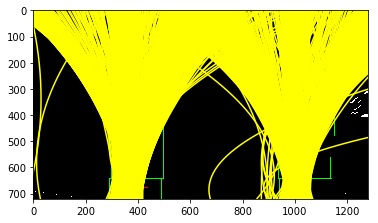

In [194]:
project_video_detector = LaneLineDetector(mtx, dist, src, dst)

project_video_clip = VideoFileClip(project_video_path)
project_video_output_clip = project_video_clip.fl_image(project_video_detector.process_image)
%time project_video_output_clip.write_videofile(project_video_output_path, audio=False)